### Importing all libraries

In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import warnings
import librosa
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook
from IPython.display import Audio

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cpu


### Recursively get all audio files

In [2]:
def audio_fetch(src,audio_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
                            
# For getting all possible classes along with their label encoding as a dictionary
def class_fetch(df: pd.DataFrame())->(list,dict):
    s=sorted(df[1].unique())
    
    toDel=[i for i in dict(df[1].value_counts(sort=True)).keys() if dict(df[1].value_counts(sort=True))[i]<3]
    for i in toDel:
        s.remove(i)
    d={}
    
    toDel_ids=[]
    for i in toDel:
        toDel_ids.extend(list(df[df[1]==i][0].values))
    
    
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d, toDel_ids

### Data Augmentation

In [3]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))
    

    return output_result


def extract_features(file_name):
    
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

### Dataset Class

In [4]:
class audio_dataset(Dataset):
    def __init__(self,
                 info: str,
                 audio_path=None,
                 audio_file_path=None,
                 audio_files=None,
                 audio_files_labels=None,
                 header=None) -> None:
        
        self.paths=[]
        self.audio_files=[]
        self.y=[]
        
        if (audio_path==None and audio_file_path==None and audio_files==None):
            raise Exception("audio_path, audio_file_path and audio_files cannot be None at the same time")

        if(audio_file_path==None and audio_files==None):
            audio_fetch(audio_path,self.paths)
        elif(audio_file_path!=None and audio_files==None):
            self.paths=audio_file_path
        else:
            self.audio_files=audio_files
            self.y=audio_files_labels
        
        self.patient=dict()
        self.paths.sort() 
        
        # We are going to remove all classes than 2 patient data

        for i in self.paths:
            index=int(i.split("/")[-1].split("_")[0])
            self.patient[index]=[]
        
        for i in range(len(self.paths)):
            self.patient[int(self.paths[i].split("/")[-1].split("_")[0])].append(self.paths[i])
        
        self.info_df=pd.read_csv(info,header=header)
        self.classes, self.class_to_idx, self.ids_to_remove = class_fetch(self.info_df)

        # After getting the patient ids to remove all the data from patient list is removed
        for i in self.ids_to_remove:
            if i in self.patient.keys():
                self.patient.pop(i)

        #Denotes sequence of audio files for a particular patient
        self.sequence=list(self.patient.values())

        # Audio path is updated after removing classing with small number of patients
        self.paths=[]
        for i in self.sequence:
            if(i!=[]):
                for j in i:
                    self.paths.append(j)

        self.scaler=StandardScaler()

    
    def get_class(self,file: str):
        return self.info_df[self.info_df[0]==int(file.split("/")[-1].split("_")[0])][1].values[0]
    
    def __len__(self) -> int:
        if(len(self.audio_files)==0):
            return len(self.paths)
        else:
            return len(self.y)


    def __getitem__(self, index: int) -> torch.Tensor():
        if(len(self.audio_files)==0):
            self.val=self.paths[index]
            self.class_val=self.class_to_idx[self.get_class(self.val)]
    
            self.signal, self.sr = librosa.load(self.val)
            self.signal = torch.unsqueeze(torch.from_numpy(np.squeeze(self.scaler.fit_transform(np.reshape(extract_process(self.signal, self.sr),newshape=(-1,1))))),dim=0).type(torch.float32)
    
            return self.signal,self.class_val
        else:
            return torch.unsqueeze(torch.tensor(self.audio_files[index]),dim=0).type(torch.float32),self.class_to_idx[self.y[index]]

##### Testing audio dataset

In [5]:
ds=audio_dataset(audio_path="../Sound_Classification/archive/Respiratory_Sound_Database/",info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
ds.class_to_idx

{'Bronchiectasis': 0,
 'Bronchiolitis': 1,
 'COPD': 2,
 'Healthy': 3,
 'Pneumonia': 4,
 'URTI': 5}

In [6]:
print(len(ds.sequence))
print(ds.get_class(ds.paths[3]))

123
COPD


### Dataloader

In [7]:
BATCH_SIZE=32
ds=[]
audio_fetch("../Sound_Classification/archive/respiratory_sound_database/",ds)

# Perform train test split
train_ds,temp_ds=train_test_split(ds,test_size=0.4,shuffle=True)
test_ds,val_ds=train_test_split(temp_ds,test_size=0.5,shuffle=True)

print(f"Before trimming:")
print(f"No. of audio files in train_ds: {len(train_ds)}\nNo. of audio files in test_ds: {len(test_ds)}\nNo. of audio files in val_ds: {len(val_ds)}")


train_ds=audio_dataset(audio_file_path=train_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
test_ds=audio_dataset(audio_file_path=test_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
val_ds=audio_dataset(audio_file_path=val_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")

print(f"\nAfter trimming:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")


features = []
labels = []
info_df=pd.read_csv("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None)

# Iterate through each sound file and extract the features
for file_name in train_ds.paths:
    data = extract_features(file_name)
    features.append(data)
    labels.append(info_df[info_df[0]==int(file_name.split("/")[-1].split("_")[0])][1].values[0])
    

print('\nFinished feature extraction from ', len(features), ' files')
features = np.array(features)
labels=np.array(labels)

augmented_features = np.reshape(features, (-1, 182))
augmented_labels = np.repeat(labels, 3)

train_ds.audio_files=augmented_features
train_ds.y=augmented_labels


print(f"\nAfter augmentaion:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")

train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)

Before trimming:
No. of audio files in train_ds: 552
No. of audio files in test_ds: 184
No. of audio files in val_ds: 184

After trimming:
No. of audio files in train_ds: 550
No. of audio files in test_ds: 184
No. of audio files in val_ds: 183

Finished feature extraction from  550  files

After augmentaion:
No. of audio files in train_ds: 1650
No. of audio files in test_ds: 184
No. of audio files in val_ds: 183


##### Checking dataloader

In [8]:
im=next(iter(train_loader))[0]
im.shape

torch.Size([32, 1, 182])

In [9]:
im[0].dtype

torch.float32

In [10]:
assert ((train_ds.classes==test_ds.classes and test_ds.classes==val_ds.classes))

### Setting up Tensorboard and performance metrics

In [11]:
log_dir = "../"+"performance"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

f1_fn=MulticlassF1Score(num_classes=len(train_ds.classes)).to(device)
cf_matrix=ConfusionMatrix(num_classes=len(train_ds.classes),task="multiclass")

### Model 1 (Simple Conv1D Network)

In [12]:
class auditory_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_embedding=nn.Sequential(nn.Conv1d(in_channels=1,out_channels=256,stride=1,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=256,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=1,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=128,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=128,out_channels=64,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=64,out_channels=32,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Dropout(p=0.2),
                                           nn.Flatten(),
                                           nn.ReLU(),
                                           nn.Linear(in_features=192,out_features=32,bias=True),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.3),
                                           nn.Linear(in_features=32,out_features=len(train_ds.classes),bias=True))

    def forward(self,x):
        return self.input_embedding(x)

#### Model 1 testing and training

In [13]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 182])

In [14]:
model=auditory_transformer().to(device)
with torch.inference_mode():
    print(model((next(iter(train_loader))[0]).to(device)).shape)

torch.Size([32, 6])


##### Optimizer and loss function

In [39]:
def get_class_weight(ds: audio_dataset) -> torch.Tensor():
    y=[]
    try:
        for i in range(ds.__len__()):
            y.append(ds.get_class(ds.paths[i]))
        class_weights = compute_class_weight('balanced', classes=ds.classes, y=y)
    except Exception as e:
        class_weights = compute_class_weight('balanced', classes=ds.classes, y=ds.y)
    return torch.from_numpy(class_weights).type(torch.float32).to(device)

optimizer=torch.optim.Adam(params=model.parameters())
loss_fn=nn.CrossEntropyLoss(weight=get_class_weight(train_ds))

print(f"Taking class weights:\n{get_class_weight(train_ds)}\n{train_ds.classes}")

Taking class weights:
tensor([10.1852, 11.4583,  0.1906,  4.3651,  3.8194, 13.0952])
['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']


##### Training Function

In [40]:
def train_model(model,epochs):
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        test_preds=torch.tensor([])
        train_actual=torch.tensor([])
        test_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and test data
        temp_train_accuracy=[]
        temp_test_accuracy=[]
        temp_train_loss=[]
        temp_test_loss=[]
        temp_train_f1=[]
        temp_test_f1=[]
    
        net_train_accuracy=0
        net_test_accuracy=0
        net_train_loss=0
        net_test_loss=0
        net_train_f1=0
        net_test_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(logits.squeeze(),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        writer.add_scalar("Train Loss",net_train_loss,i)
        writer.add_scalar("Train F1 Score",net_train_f1)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(test_loader)) as pbar2:
            for x,y in test_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    test_preds=torch.hstack((test_preds,preds.to("cpu")))
                    test_actual=torch.hstack((test_actual,y.to("cpu")))
                    accuracy_test=accuracy_fn(logits,y)
                    f1_test=f1_fn(preds,y)
                    temp_test_accuracy.append(accuracy_test)
                    temp_test_loss.append(loss.item())
                    temp_test_f1.append(f1_test.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
        net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
        net_test_f1=sum(temp_test_f1)/len(temp_test_f1)
        writer.add_scalar("Test Accuracy",net_test_accuracy,i)
        writer.add_scalar("Test Loss",net_test_loss,i)
        writer.add_scalar("Test F1 Score",net_test_f1,i)

        '''
        #Saving the model
        try:
            os.makedirs(f"./{model_name}_feature_extractor/")
        except Exception as e:
            pass
        torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
        '''
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nTrain F1 Score: {net_train_f1}\n\nTest Accuracy: {net_test_accuracy}\n\nTest Loss: {net_test_loss}\n\nTest F1 Score: {net_test_f1}")

        #Plotting confusion matrix
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(train_preds,train_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Train confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(test_preds,test_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Test confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()

##### Training Model 1

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.8253205128205128

Train Loss: 1.6630954788281367

Train F1 Score: 0.2974553976494532

Test Accuracy: 0.84375

Test Loss: 1.848235825697581

Test F1 Score: 0.25637207676966983




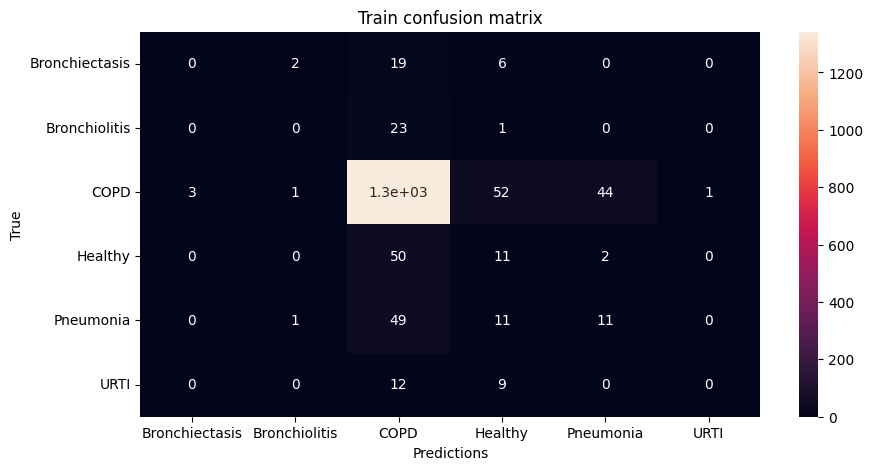

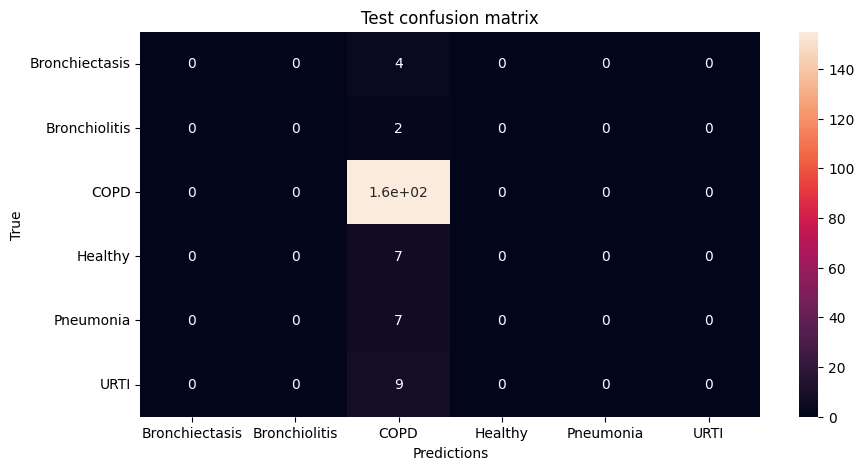


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.740718482905983

Train Loss: 1.5351141954843814

Train F1 Score: 0.3201898797773398

Test Accuracy: 0.84375

Test Loss: 1.8816069960594177

Test F1 Score: 0.21373150497674942




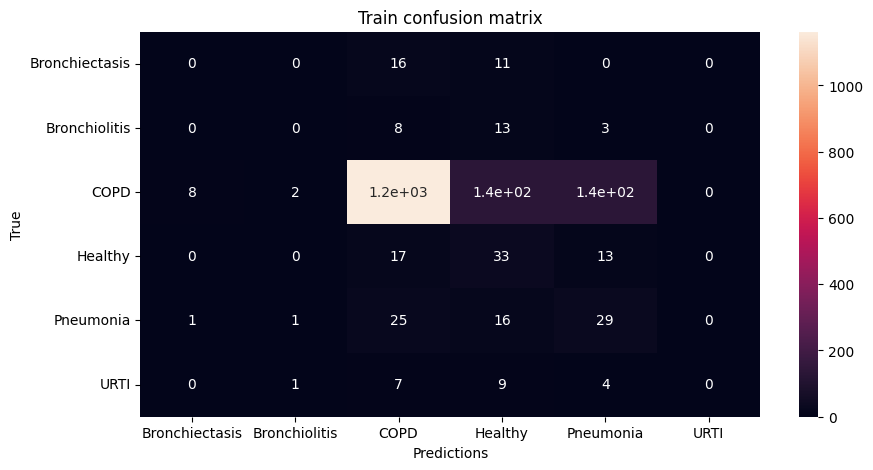

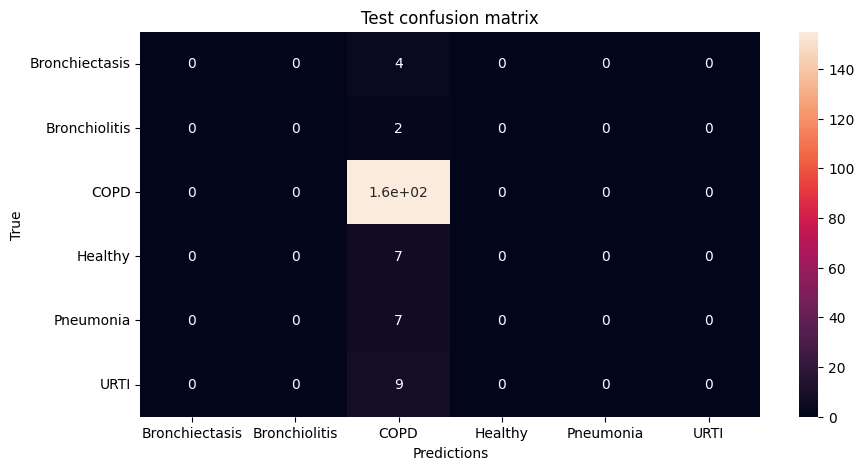


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.7347756410256411

Train Loss: 1.5039630337403371

Train F1 Score: 0.3215766219565502

Test Accuracy: 0.84375

Test Loss: 1.8470404346783955

Test F1 Score: 0.23482386271158853




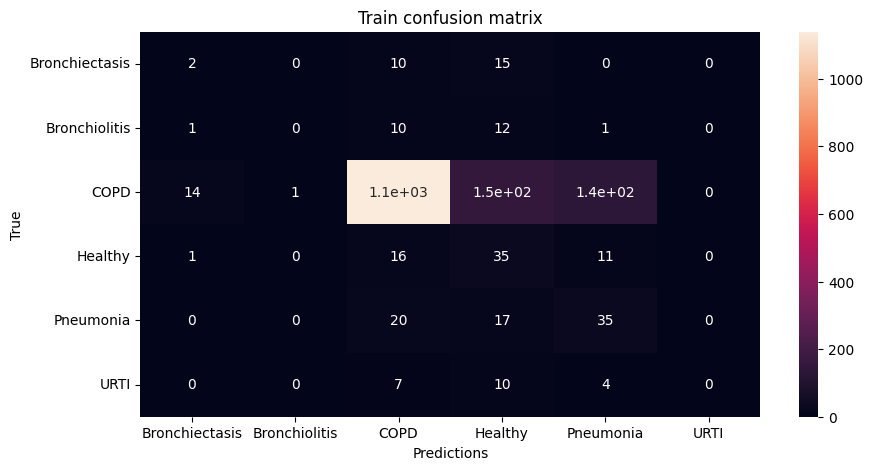

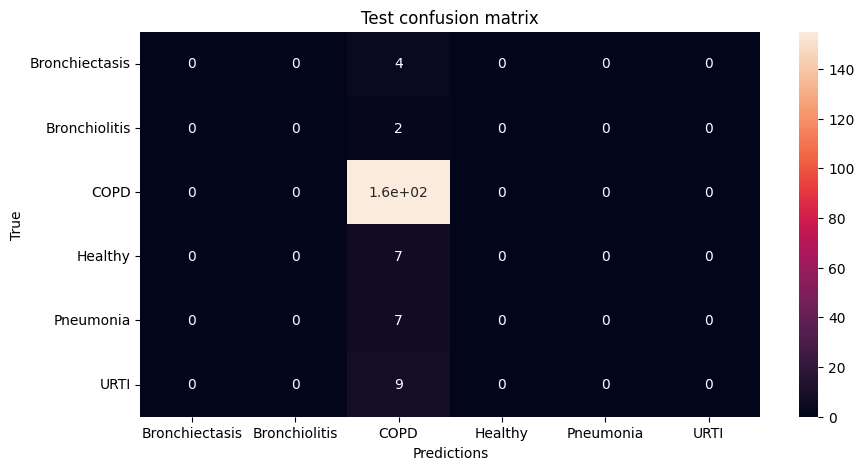


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.7392494658119658

Train Loss: 1.4531175585893483

Train F1 Score: 0.3495381147815631

Test Accuracy: 0.84375

Test Loss: 1.8853335579236348

Test F1 Score: 0.25344480325778324




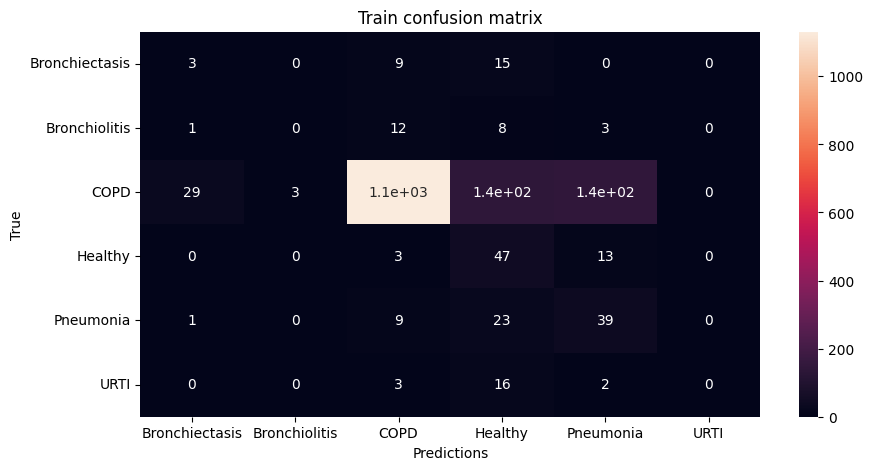

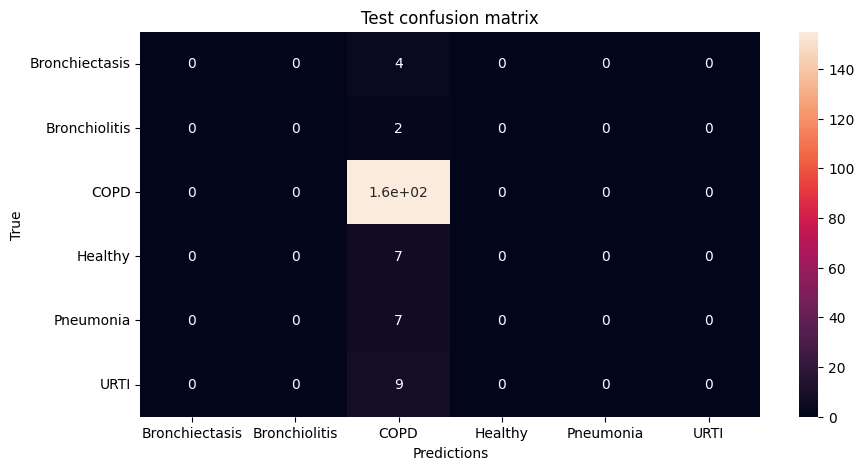


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.7248931623931624

Train Loss: 1.391587753708546

Train F1 Score: 0.3105393708325349

Test Accuracy: 0.8420138888888888

Test Loss: 1.9882916410764058

Test F1 Score: 0.23383869230747223




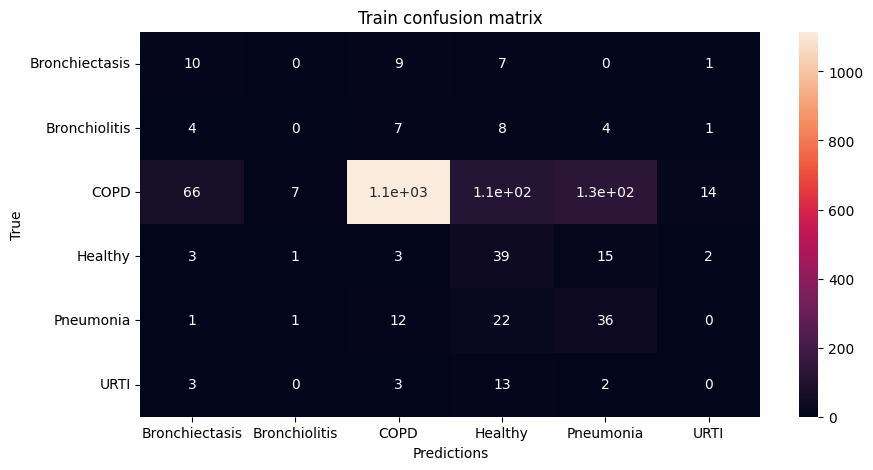

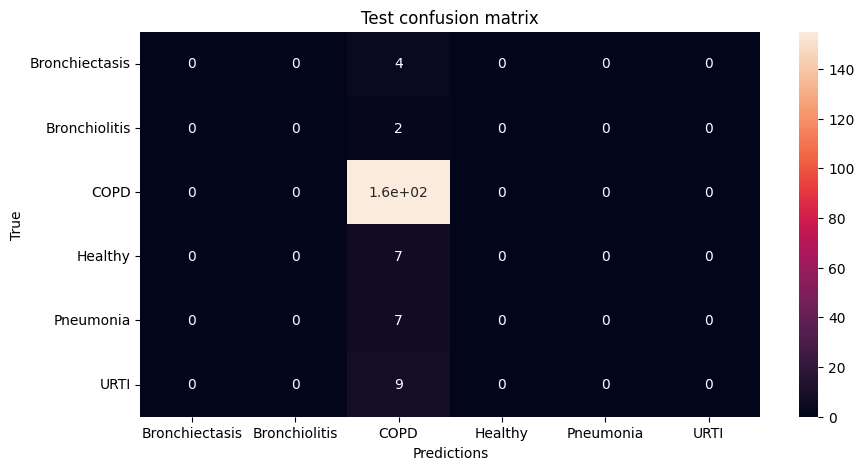


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.7126736111111112

Train Loss: 1.4657401958337197

Train F1 Score: 0.3097366988658905

Test Accuracy: 0.84375

Test Loss: 1.8646105527877808

Test F1 Score: 0.20698068042596182




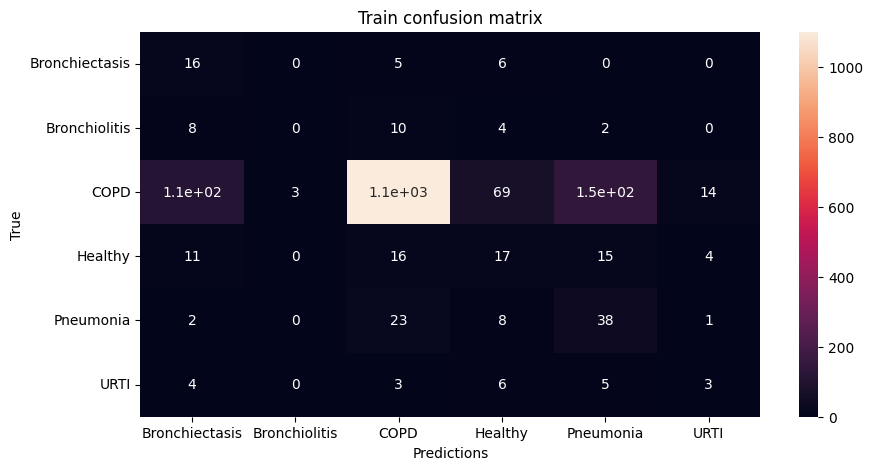

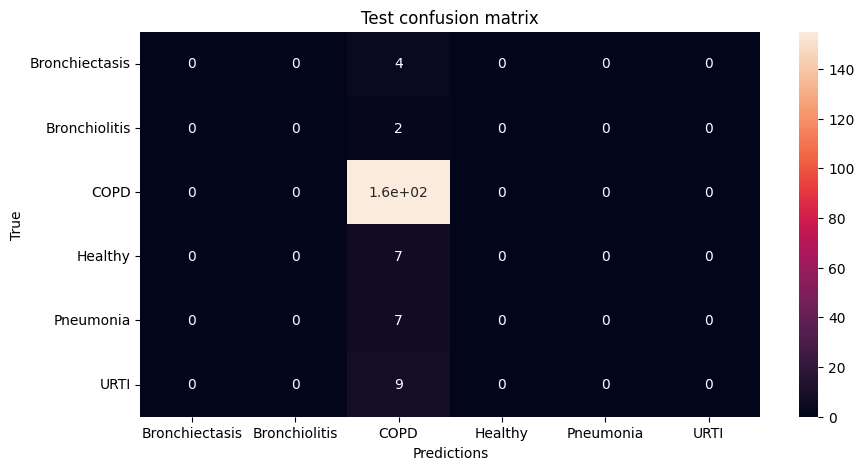


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.6746794871794872

Train Loss: 1.5017532660410955

Train F1 Score: 0.31156009163420934

Test Accuracy: 0.8402777777777778

Test Loss: 1.8300224741299946

Test F1 Score: 0.22075572858254114




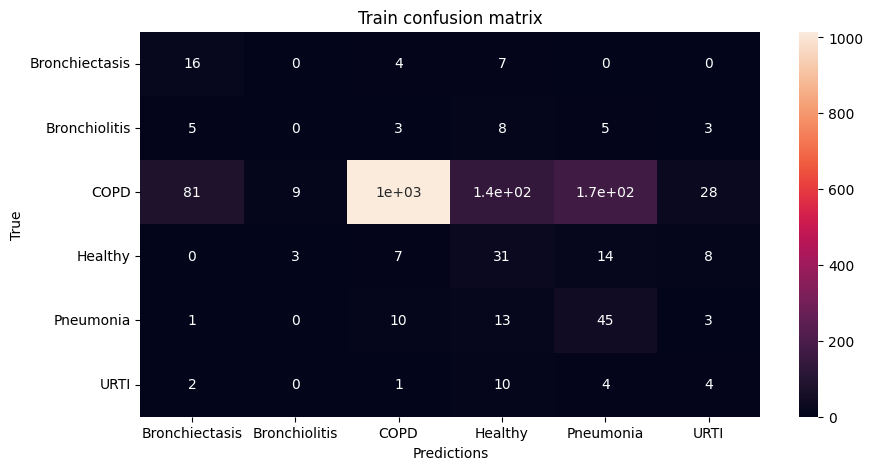

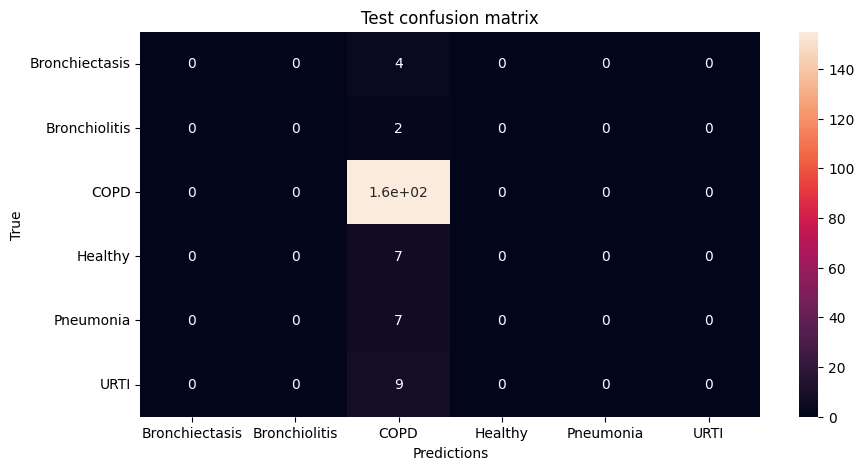


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.7220219017094016

Train Loss: 1.3706022953757873

Train F1 Score: 0.285139931509128

Test Accuracy: 0.8420138888888888

Test Loss: 1.7815500299135845

Test F1 Score: 0.22680073728164038




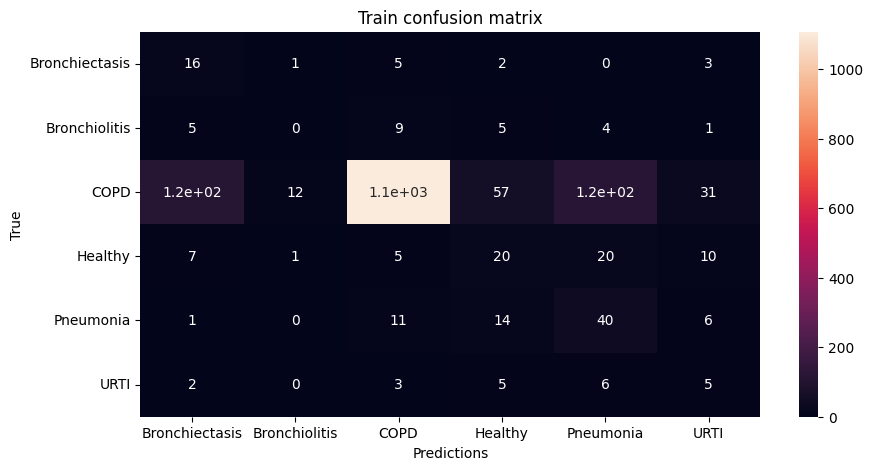

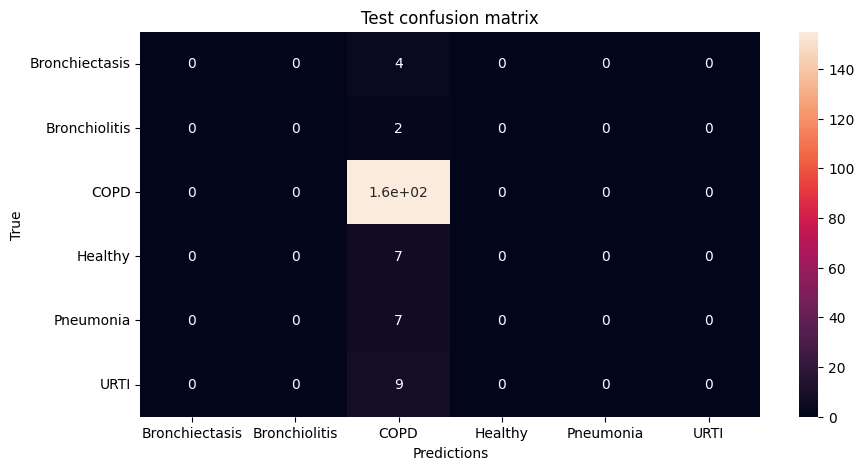


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.6875667735042735

Train Loss: 1.4250348588595023

Train F1 Score: 0.27439750931583917

Test Accuracy: 0.8420138888888888

Test Loss: 1.834119399388631

Test F1 Score: 0.25388501584529877




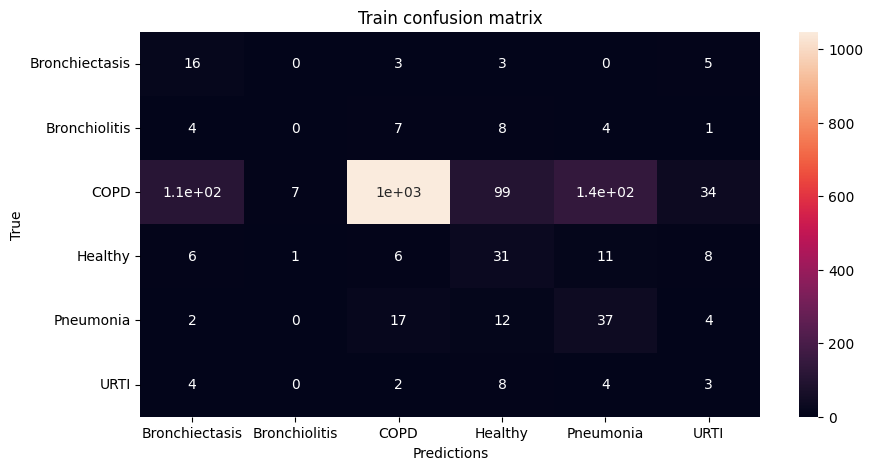

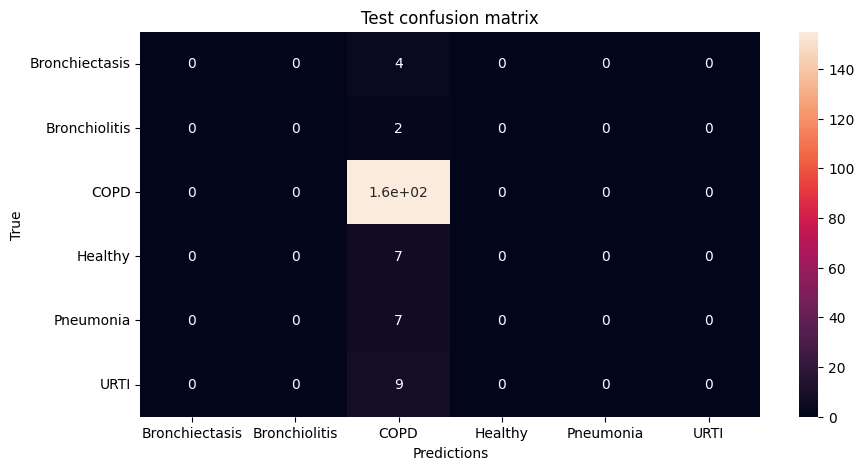


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.6758146367521368

Train Loss: 1.3286564218310208

Train F1 Score: 0.3226057859854056

Test Accuracy: 0.84375

Test Loss: 1.8359097441037495

Test F1 Score: 0.2411178375283877




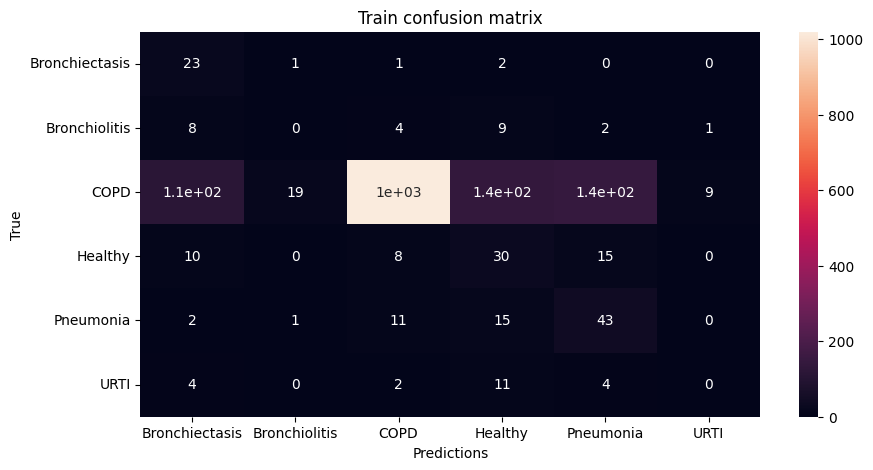

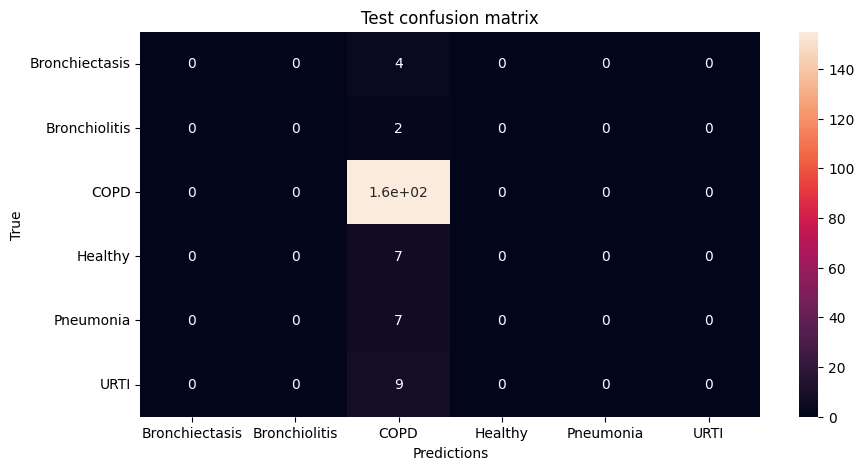


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.7234909188034189

Train Loss: 1.4922003963818917

Train F1 Score: 0.320661047903391

Test Accuracy: 0.8454861111111112

Test Loss: 1.8303122917811077

Test F1 Score: 0.24822300424178442




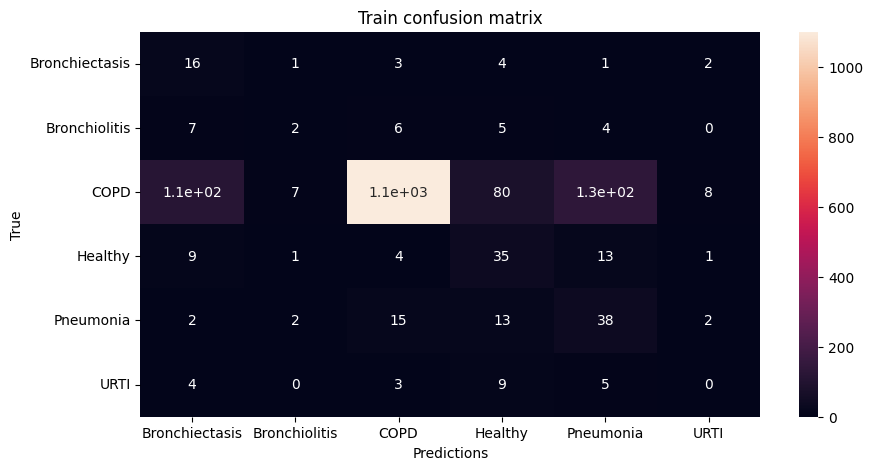

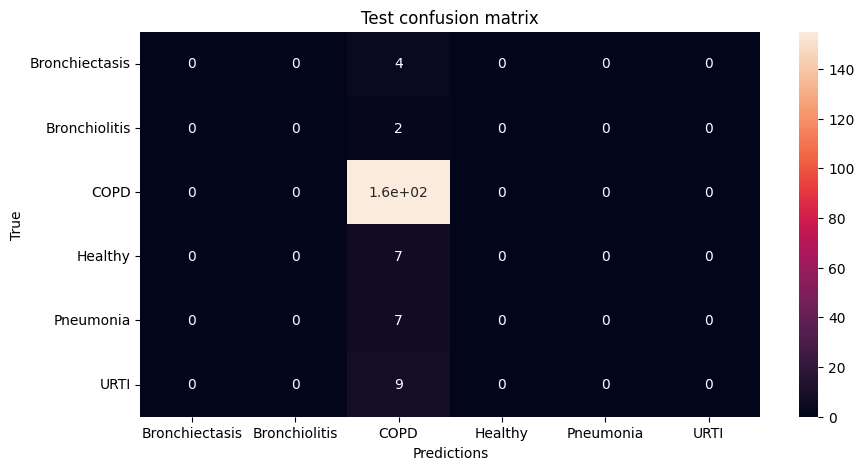


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.6859642094017093

Train Loss: 1.3666812811906521

Train F1 Score: 0.3048939217741673

Test Accuracy: 0.84375

Test Loss: 1.8436177968978882

Test F1 Score: 0.24142722537120184




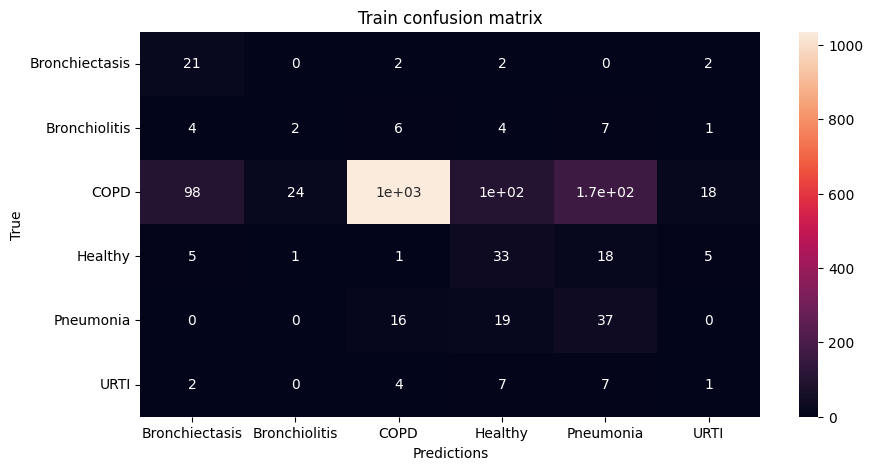

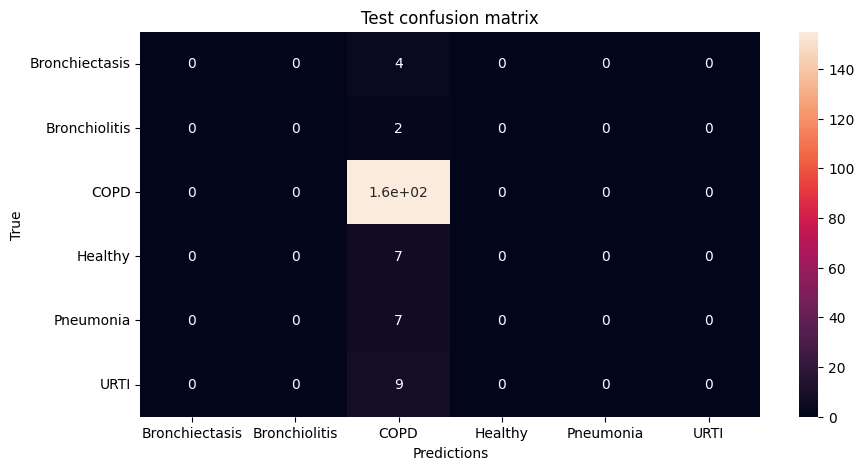


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.6786858974358974

Train Loss: 1.3240079409801042

Train F1 Score: 0.2966731253724832

Test Accuracy: 0.8420138888888888

Test Loss: 1.8385566274325054

Test F1 Score: 0.23445618400971094




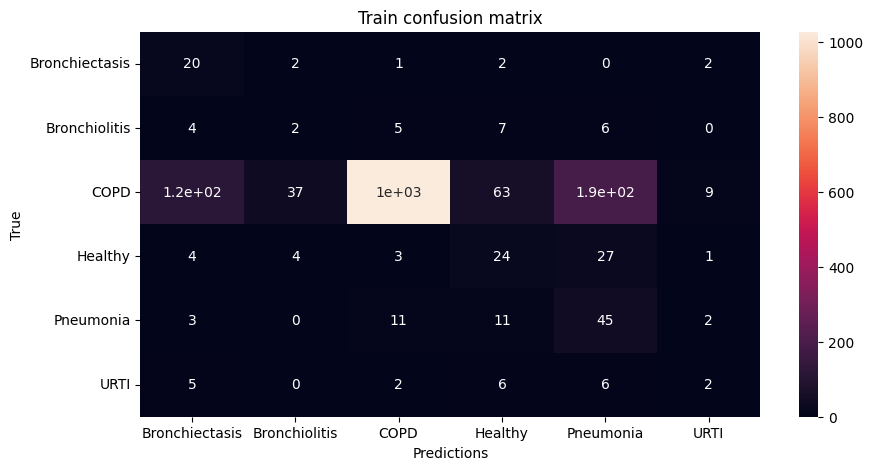

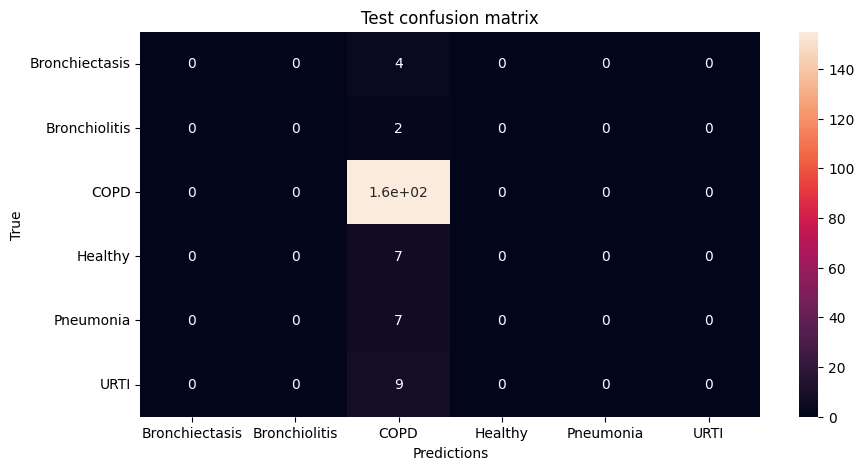


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.6428952991452992

Train Loss: 1.6073195802477689

Train F1 Score: 0.27000656723976135

Test Accuracy: 0.7621527777777778

Test Loss: 1.7471980253855388

Test F1 Score: 0.23834127436081567




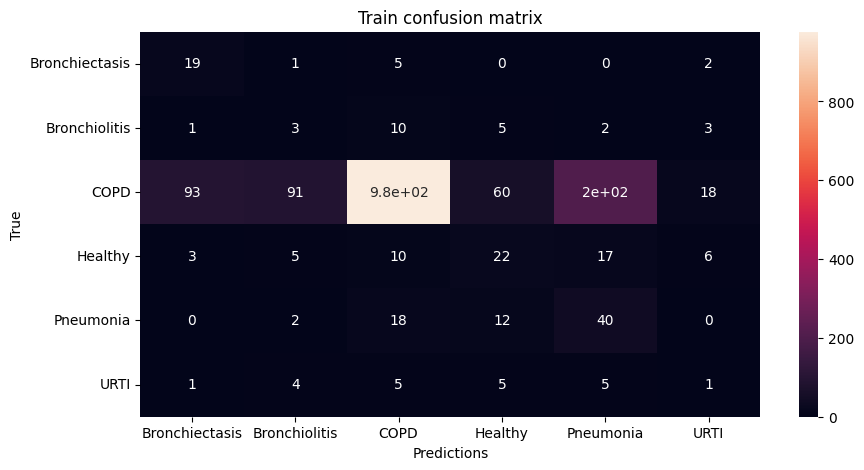

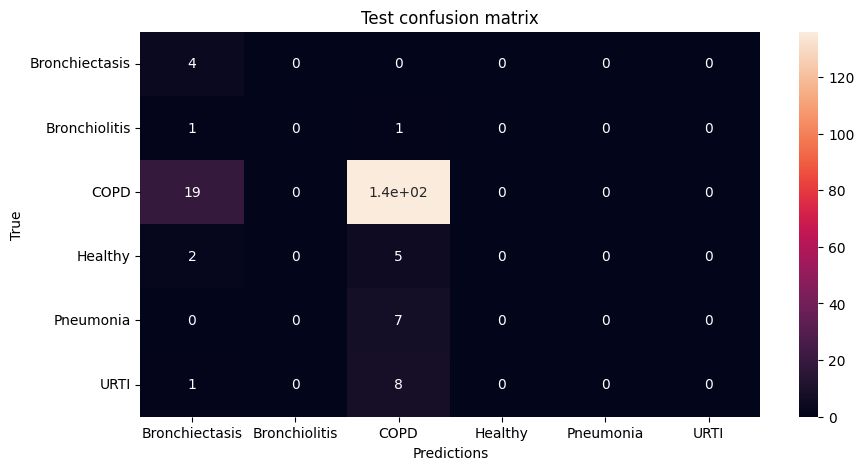


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.7444577991452992

Train Loss: 1.4740048257204204

Train F1 Score: 0.27095115270752174

Test Accuracy: 0.7708333333333334

Test Loss: 1.7760387857755024

Test F1 Score: 0.2130457932750384




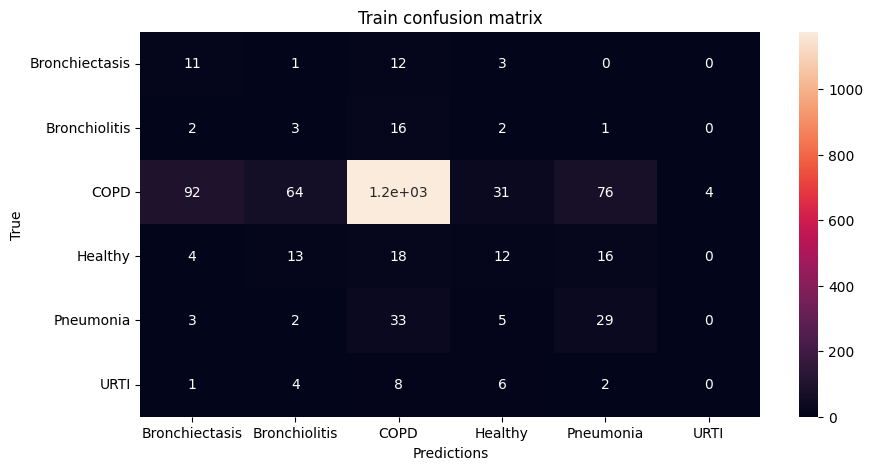

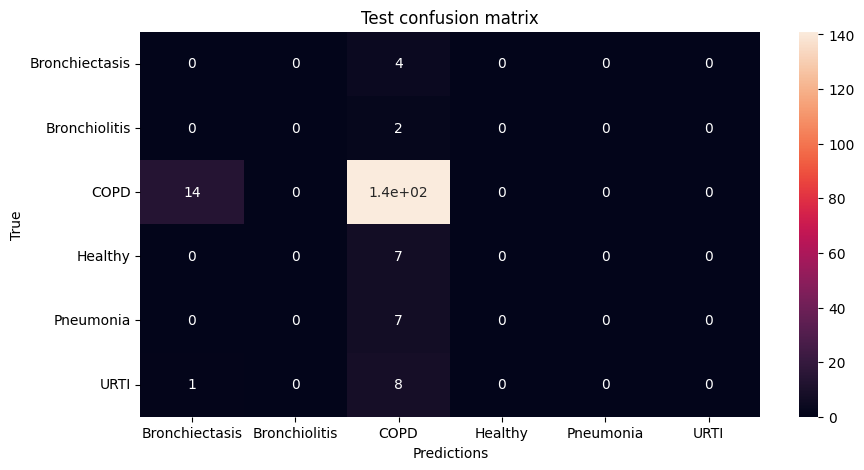


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.696113782051282

Train Loss: 1.33006059550322

Train F1 Score: 0.29720113283166516

Test Accuracy: 0.7934027777777778

Test Loss: 1.8016418814659119

Test F1 Score: 0.22757255285978317




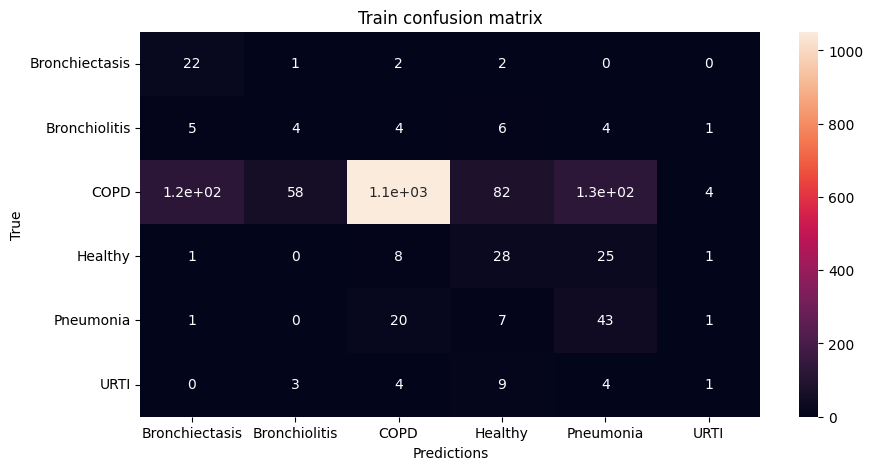

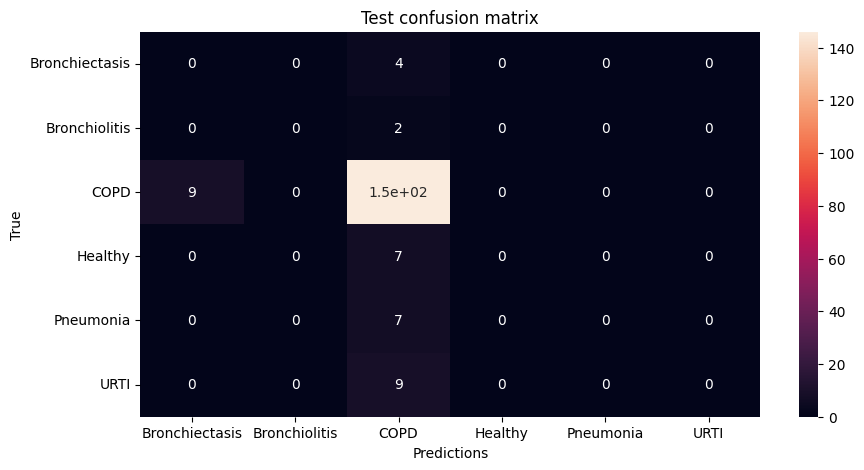


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.6923744658119658

Train Loss: 1.3505558165220113

Train F1 Score: 0.2665625624358654

Test Accuracy: 0.71875

Test Loss: 1.773625870545705

Test F1 Score: 0.17829537143309912




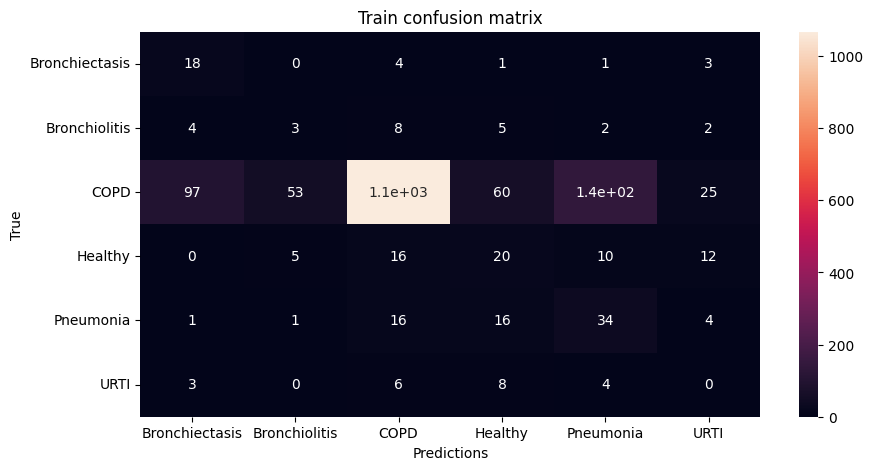

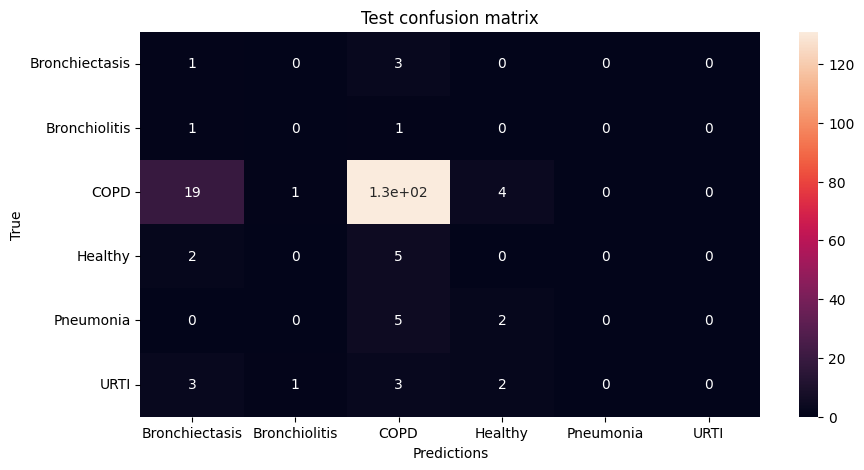


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.6768162393162392

Train Loss: 1.370138813669865

Train F1 Score: 0.32318770770843214

Test Accuracy: 0.7569444444444445

Test Loss: 1.9080656170845032

Test F1 Score: 0.1904849410057068




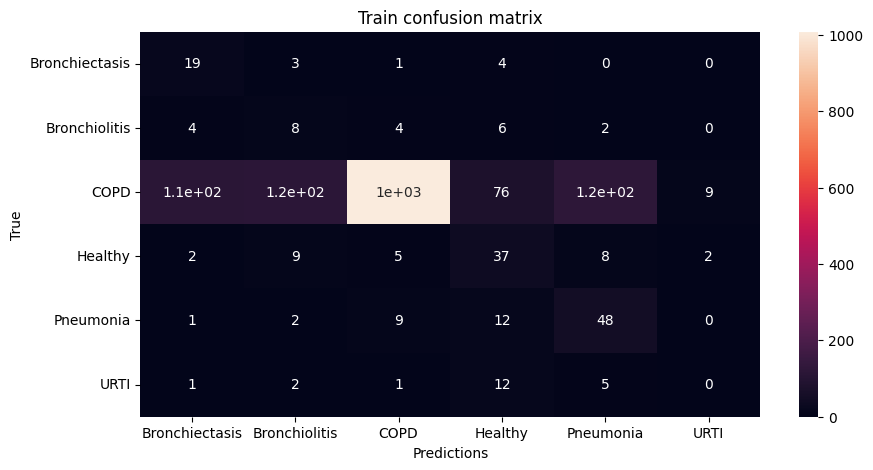

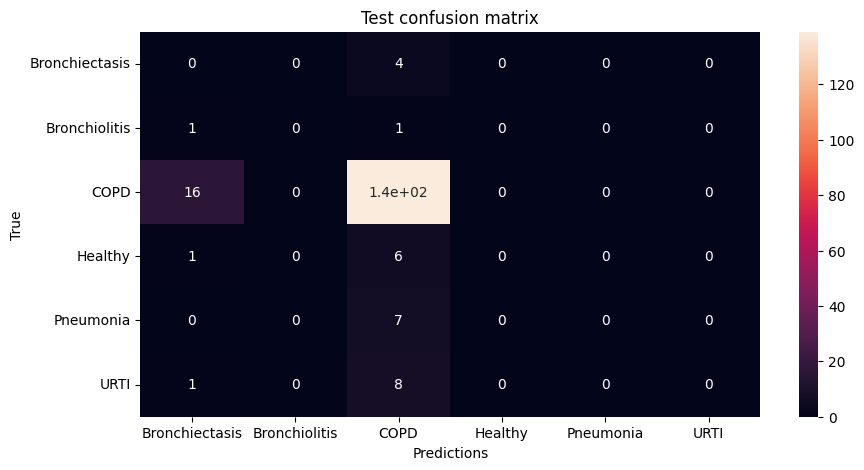


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 19:

Train Accuracy: 0.6586538461538461

Train Loss: 1.2662532318096895

Train F1 Score: 0.2861892864681207

Test Accuracy: 0.7847222222222222

Test Loss: 1.7983405987421672

Test F1 Score: 0.22508620222409567




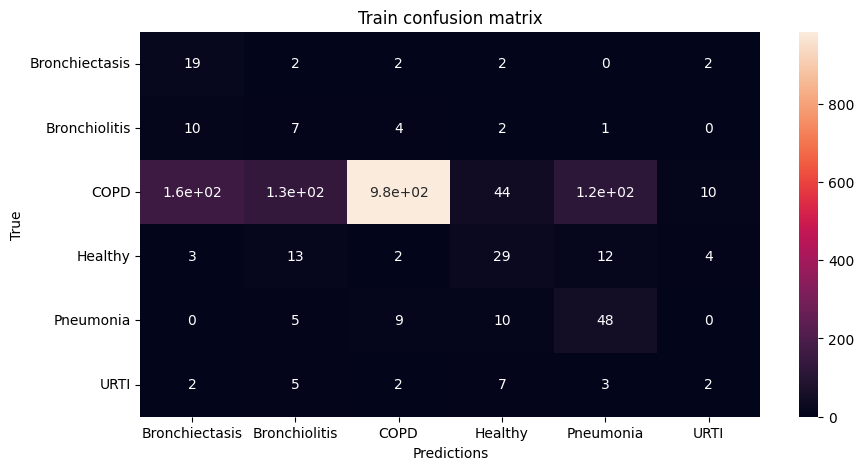

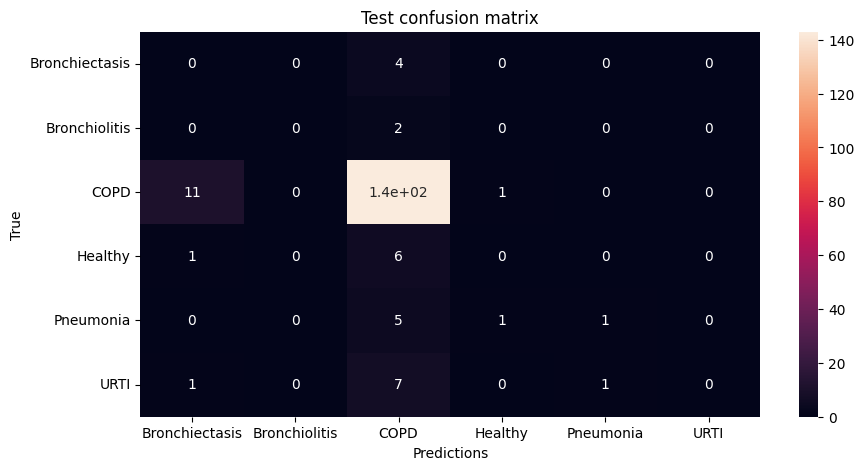


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 0.6931757478632478

Train Loss: 1.1779121510111368

Train F1 Score: 0.3280887487702645

Test Accuracy: 0.8333333333333334

Test Loss: 1.8006182710329692

Test F1 Score: 0.21860270698865256




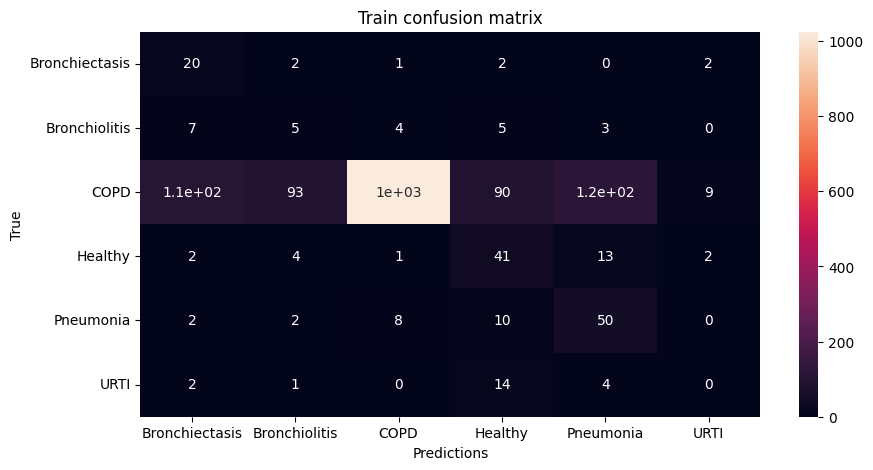

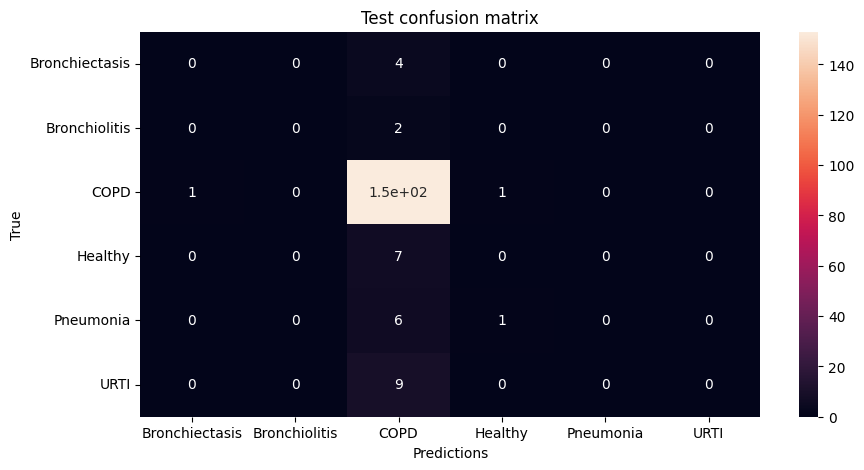


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 21:

Train Accuracy: 0.7091346153846154

Train Loss: 1.1612926710110445

Train F1 Score: 0.3069042655137869

Test Accuracy: 0.8263888888888888

Test Loss: 1.7706790765126545

Test F1 Score: 0.30921387175718945




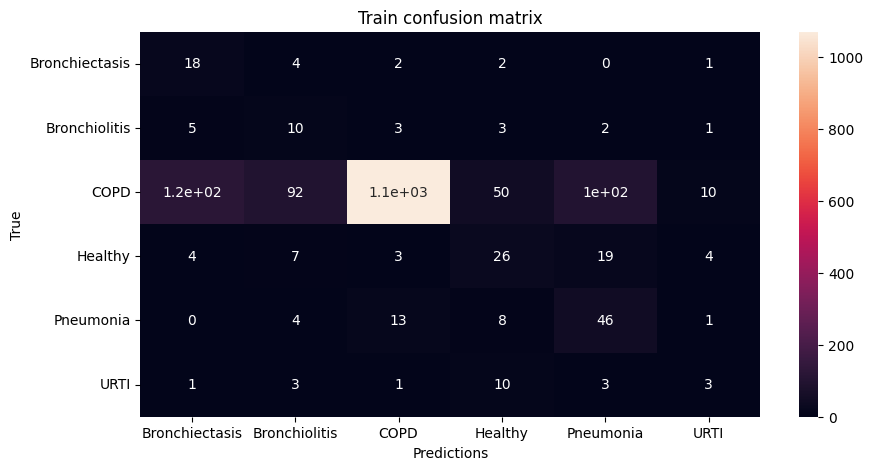

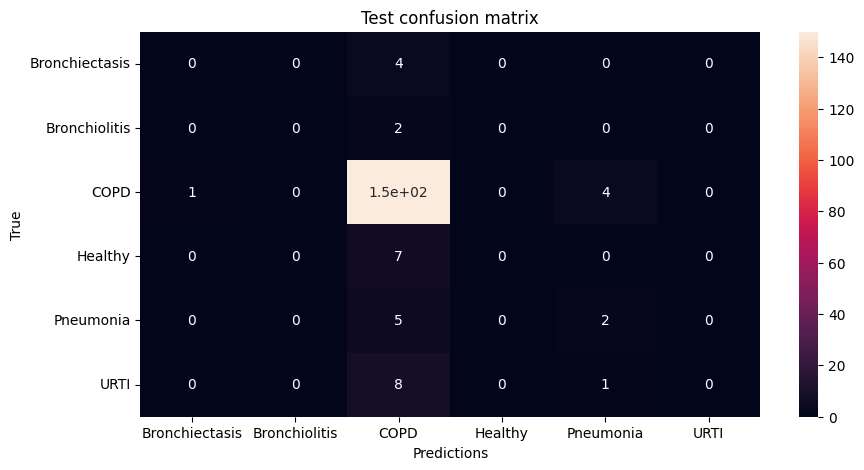


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 22:

Train Accuracy: 0.6661992521367522

Train Loss: 1.1616577993218715

Train F1 Score: 0.32030396048839277

Test Accuracy: 0.8211805555555555

Test Loss: 1.7864789565404255

Test F1 Score: 0.28978221366802853




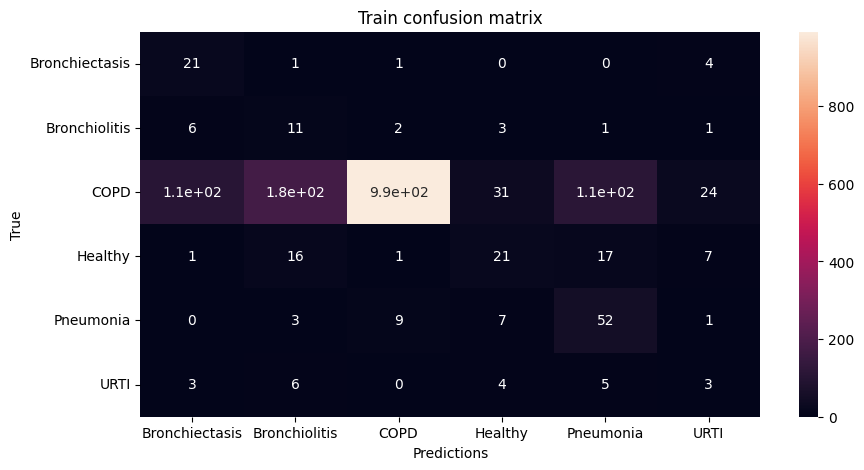

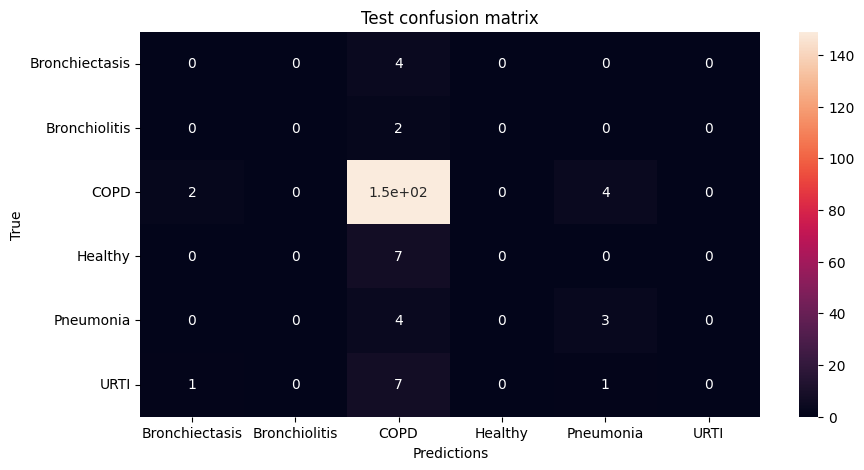


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 23:

Train Accuracy: 0.6916399572649573

Train Loss: 1.22516846542175

Train F1 Score: 0.2896469413087918

Test Accuracy: 0.8211805555555555

Test Loss: 1.8330940405527751

Test F1 Score: 0.20390232900778452




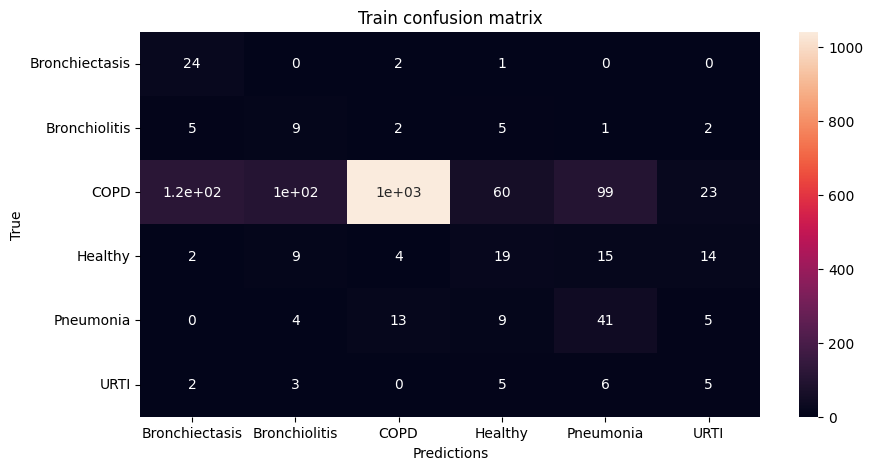

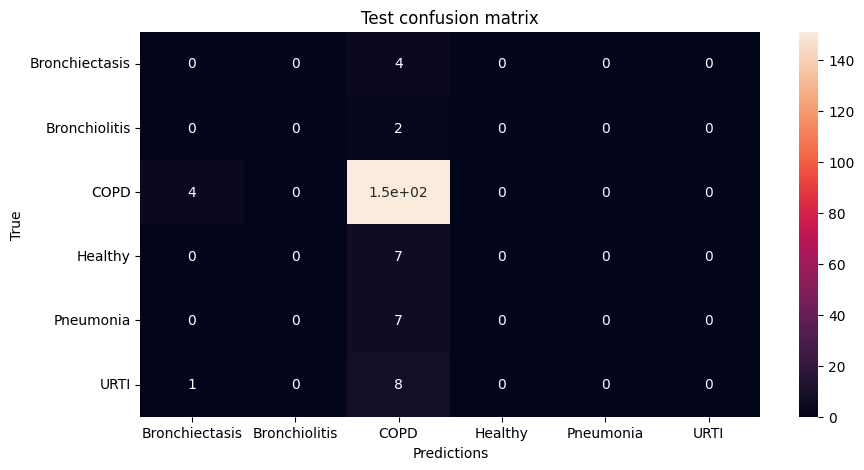


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 24:

Train Accuracy: 0.6929754273504274

Train Loss: 1.1379019245505333

Train F1 Score: 0.30965878613866293

Test Accuracy: 0.8055555555555555

Test Loss: 1.899479349454244

Test F1 Score: 0.20799053212006888




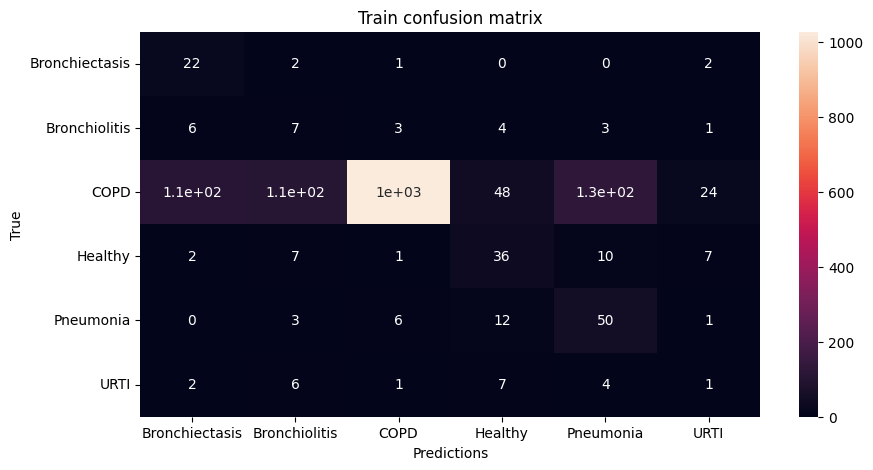

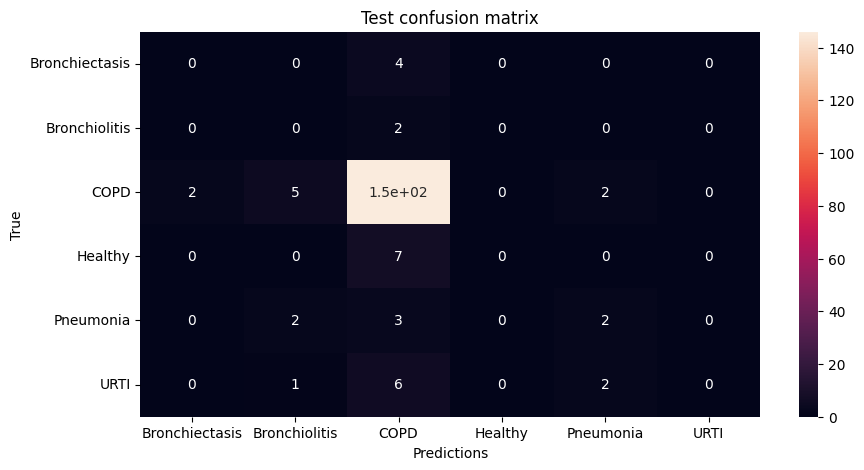


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 25:

Train Accuracy: 0.6683360042735043

Train Loss: 1.1044518426060677

Train F1 Score: 0.3300187215209007

Test Accuracy: 0.8298611111111112

Test Loss: 1.80125492811203

Test F1 Score: 0.3362969160079956




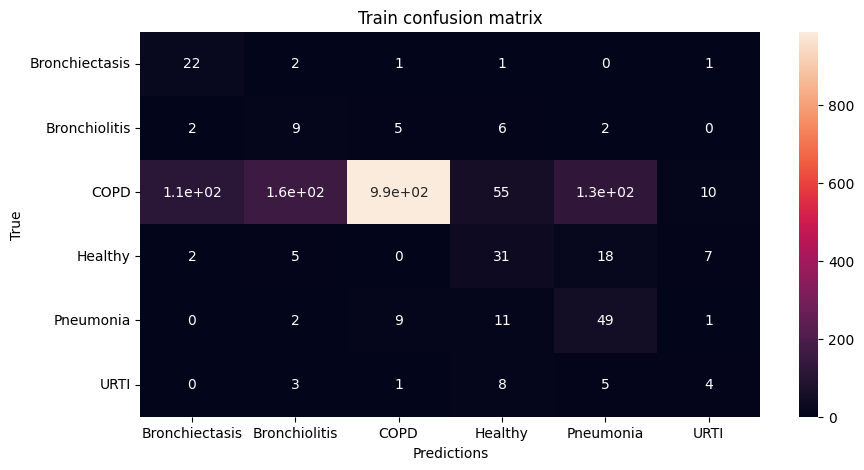

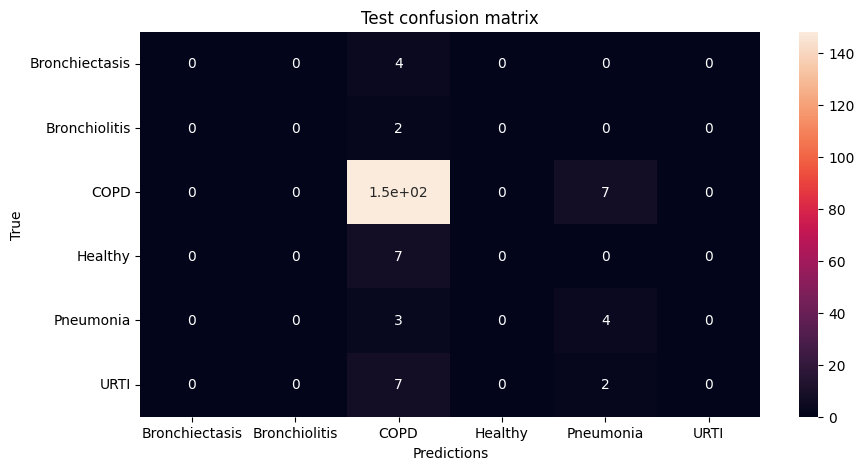


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 26:

Train Accuracy: 0.6434962606837608

Train Loss: 1.217837132513523

Train F1 Score: 0.2844030298292637

Test Accuracy: 0.8315972222222222

Test Loss: 1.825814962387085

Test F1 Score: 0.22509664545456567




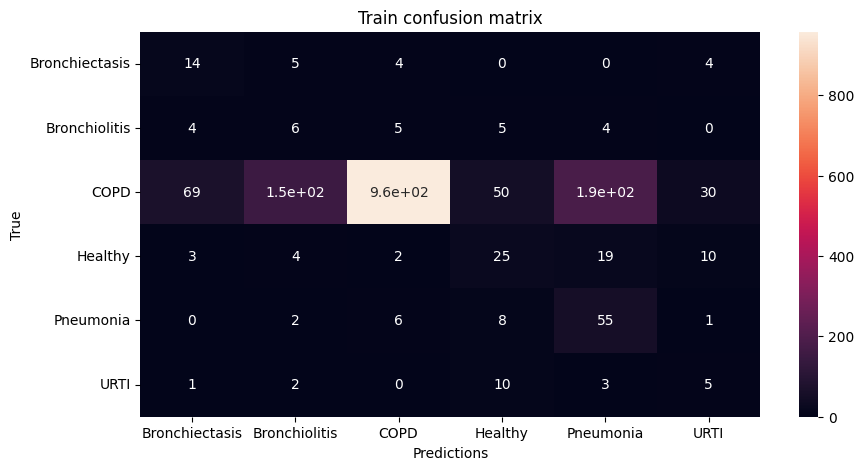

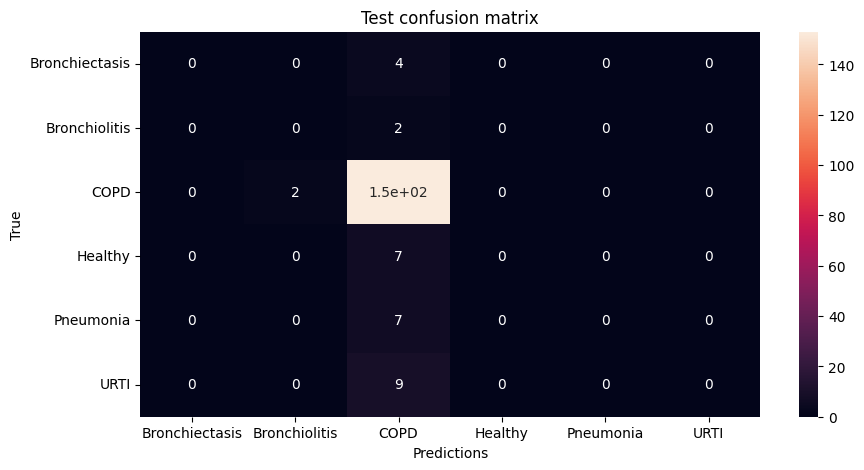


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 27:

Train Accuracy: 0.6528445512820512

Train Loss: 1.17890481536205

Train F1 Score: 0.28205132842637026

Test Accuracy: 0.8194444444444445

Test Loss: 1.7888470888137817

Test F1 Score: 0.2172713503241539




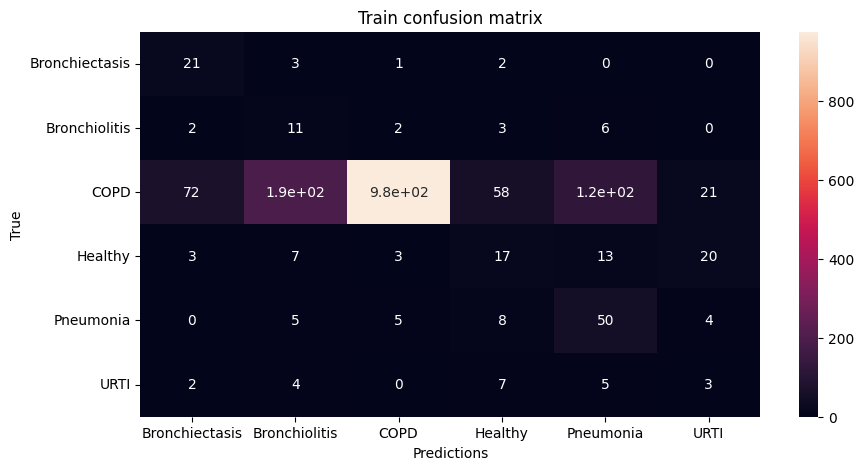

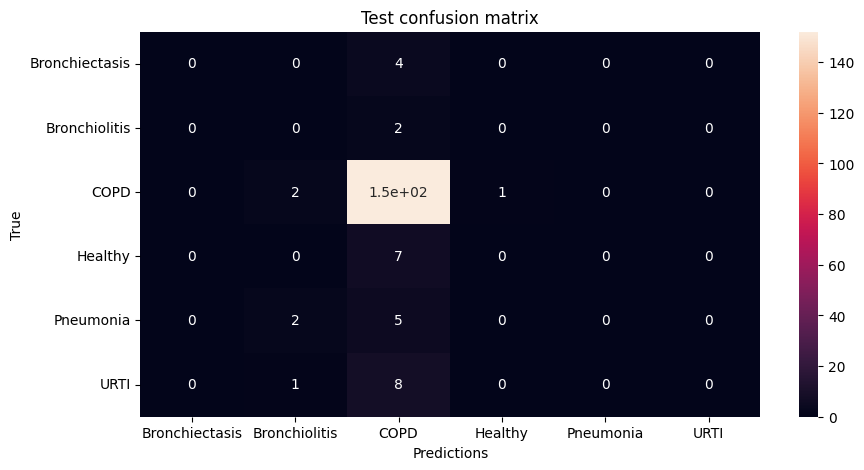


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 28:

Train Accuracy: 0.6913060897435896

Train Loss: 1.0849675753941903

Train F1 Score: 0.33020834968640256

Test Accuracy: 0.8402777777777778

Test Loss: 1.9371198018391926

Test F1 Score: 0.25412678718566895




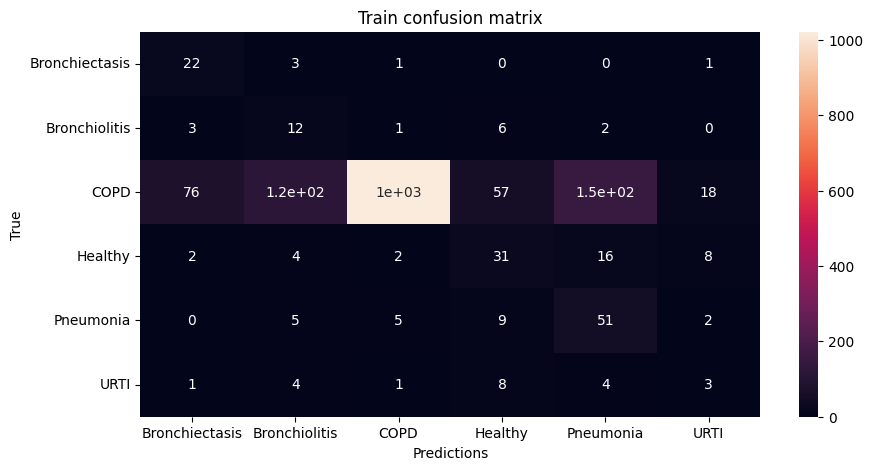

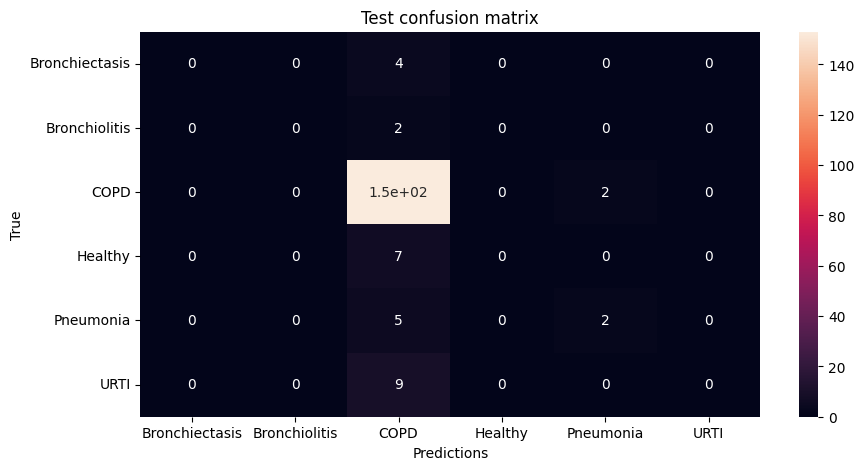


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 29:

Train Accuracy: 0.6435630341880342

Train Loss: 1.040676816724814

Train F1 Score: 0.31048452796844334

Test Accuracy: 0.8350694444444445

Test Loss: 1.7733429670333862

Test F1 Score: 0.2827234665552775




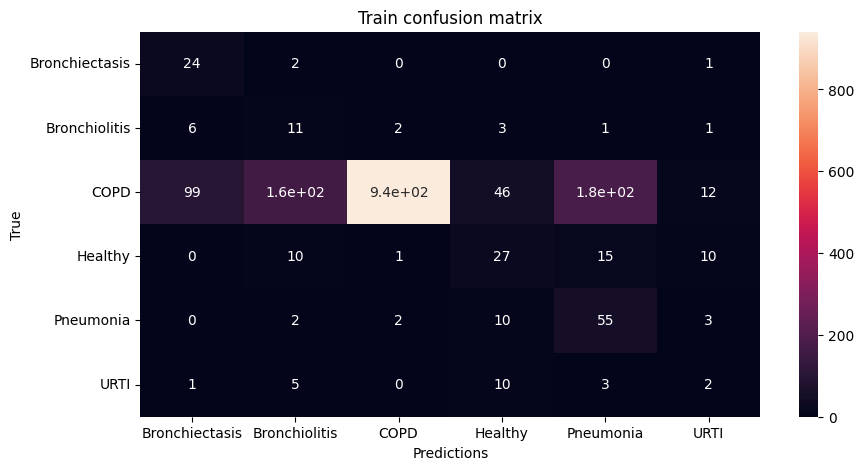

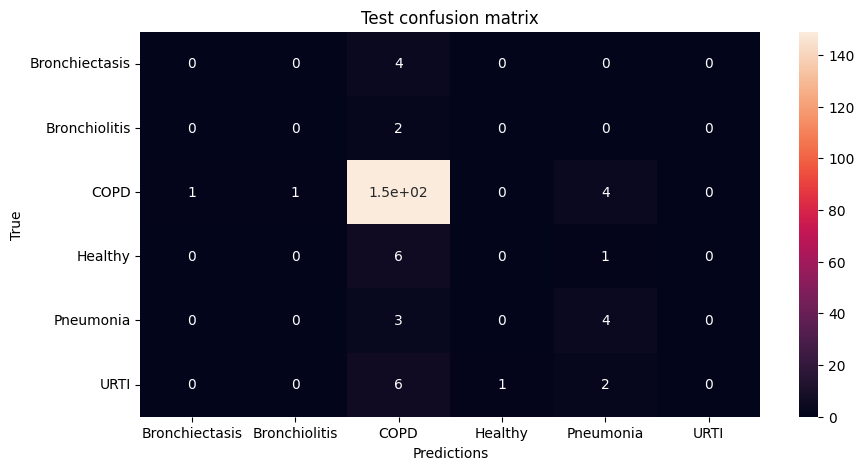


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 30:

Train Accuracy: 0.6675347222222222

Train Loss: 1.031720474935495

Train F1 Score: 0.3227091090610394

Test Accuracy: 0.7934027777777778

Test Loss: 1.8745994369188945

Test F1 Score: 0.23776169369618097




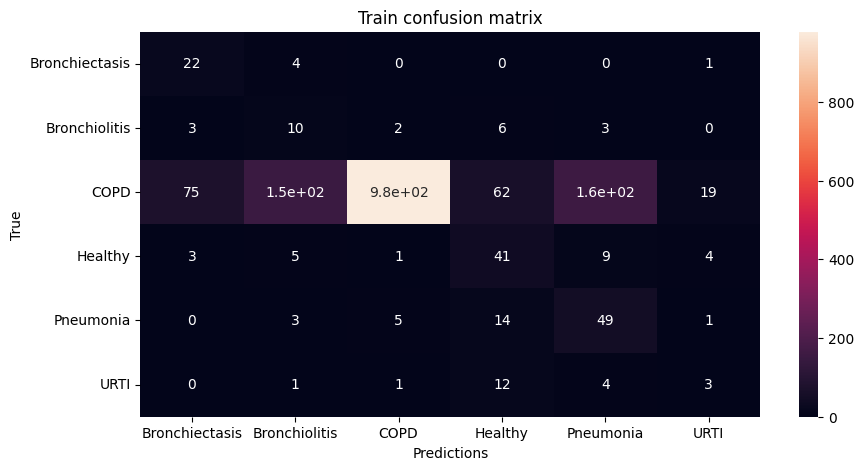

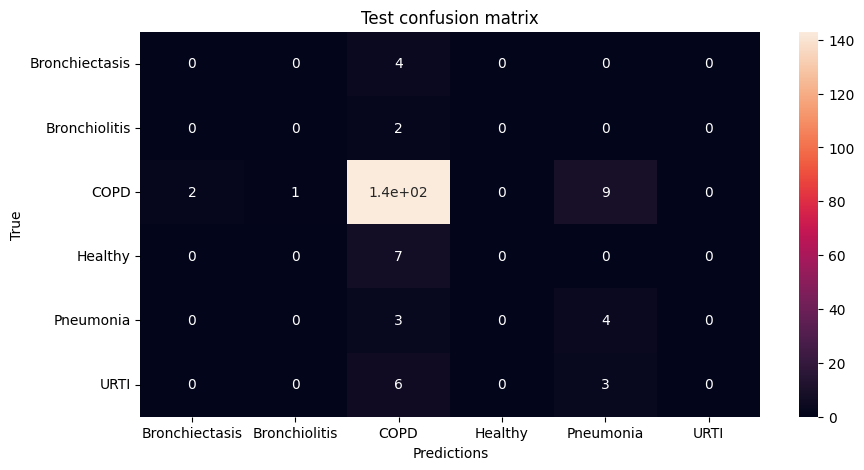


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 31:

Train Accuracy: 0.6631944444444445

Train Loss: 1.06041241895694

Train F1 Score: 0.3293278142809868

Test Accuracy: 0.7395833333333334

Test Loss: 1.8228878577550252

Test F1 Score: 0.21770456433296204




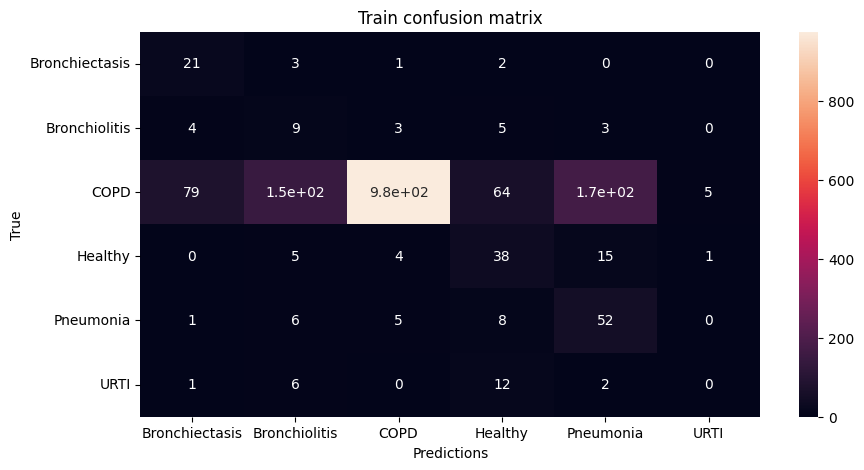

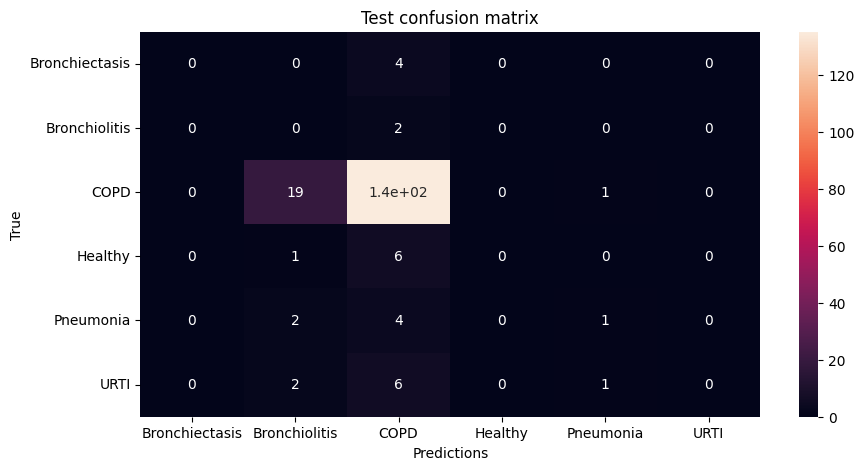


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 32:

Train Accuracy: 0.6724759615384616

Train Loss: 1.0696675760241656

Train F1 Score: 0.32323718586793315

Test Accuracy: 0.7777777777777778

Test Loss: 1.8966116309165955

Test F1 Score: 0.3156984994808833




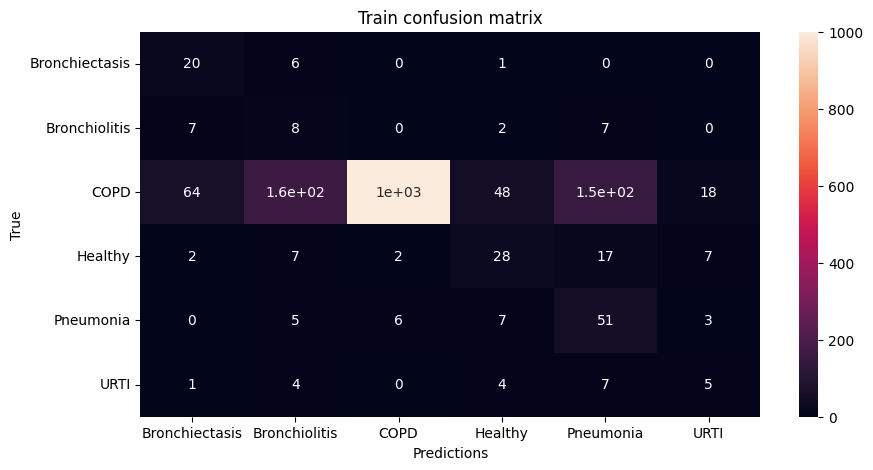

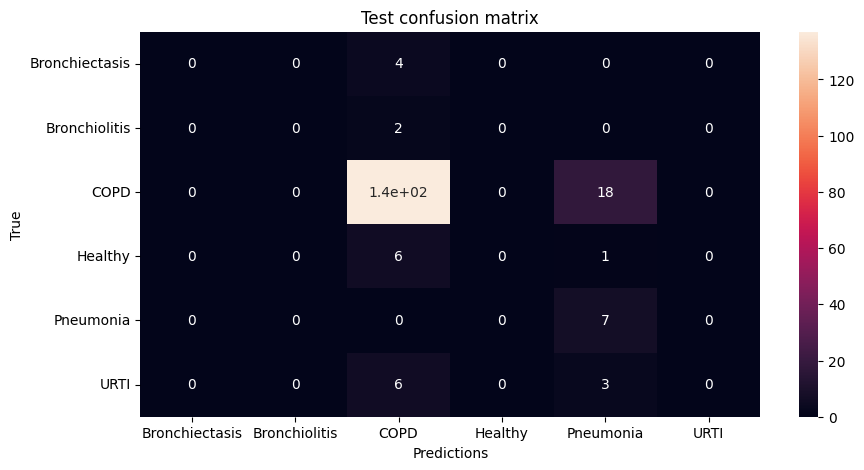


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 33:

Train Accuracy: 0.6490384615384616

Train Loss: 1.1334111753564615

Train F1 Score: 0.31324674661916035

Test Accuracy: 0.734375

Test Loss: 1.6856082876523335

Test F1 Score: 0.3033885384599368




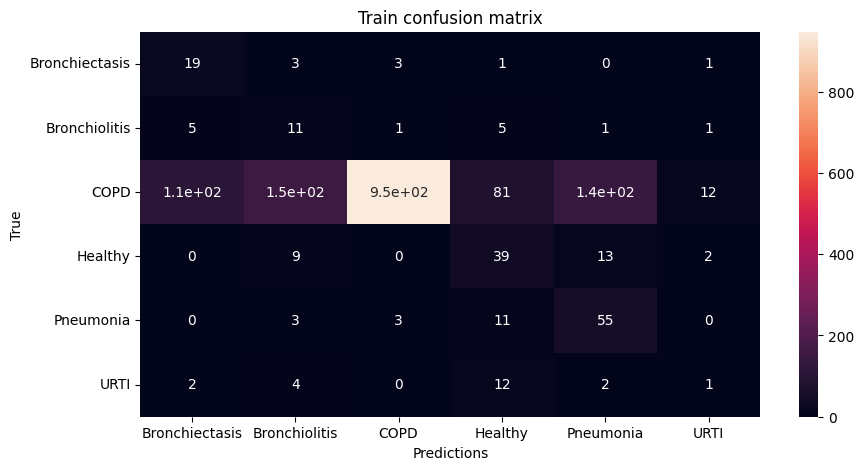

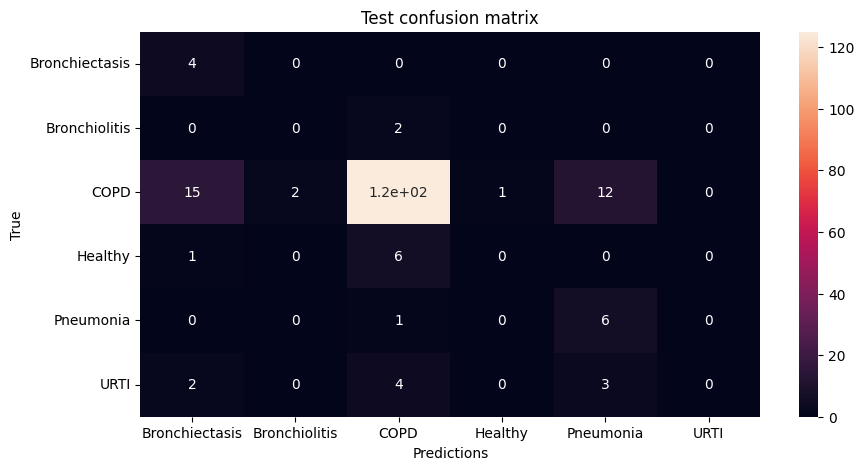


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 34:

Train Accuracy: 0.6583867521367522

Train Loss: 1.1345798075199127

Train F1 Score: 0.3160066736432222

Test Accuracy: 0.6805555555555555

Test Loss: 1.7690686980883281

Test F1 Score: 0.21417607615391412




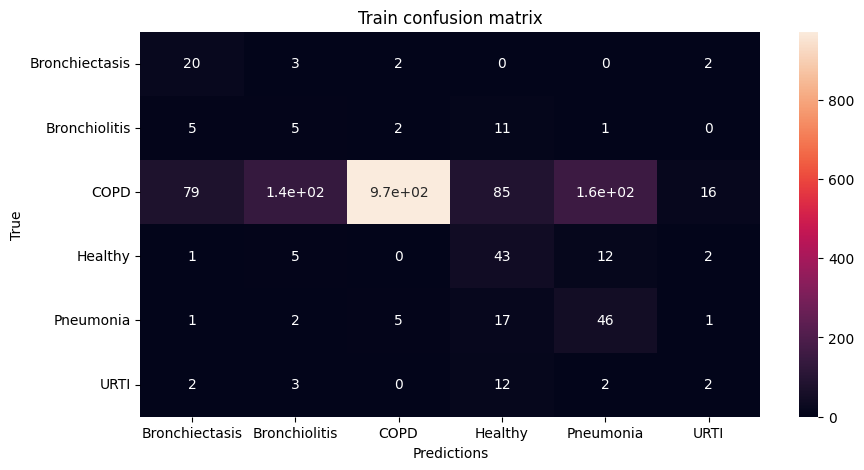

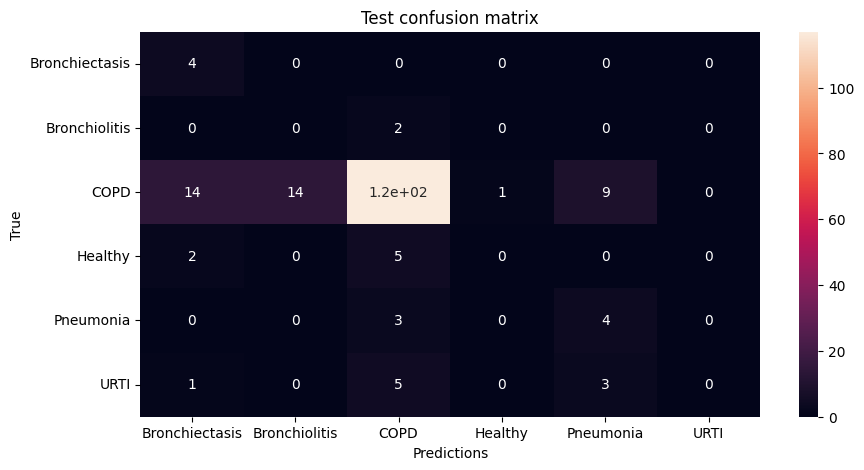


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 35:

Train Accuracy: 0.6615251068376069

Train Loss: 1.1286843980734165

Train F1 Score: 0.303531560760278

Test Accuracy: 0.6371527777777778

Test Loss: 1.7148863275845845

Test F1 Score: 0.18167448292175928




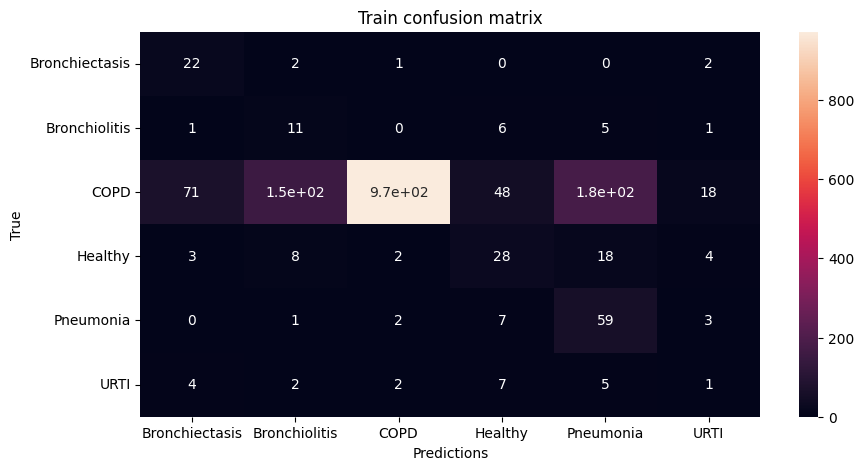

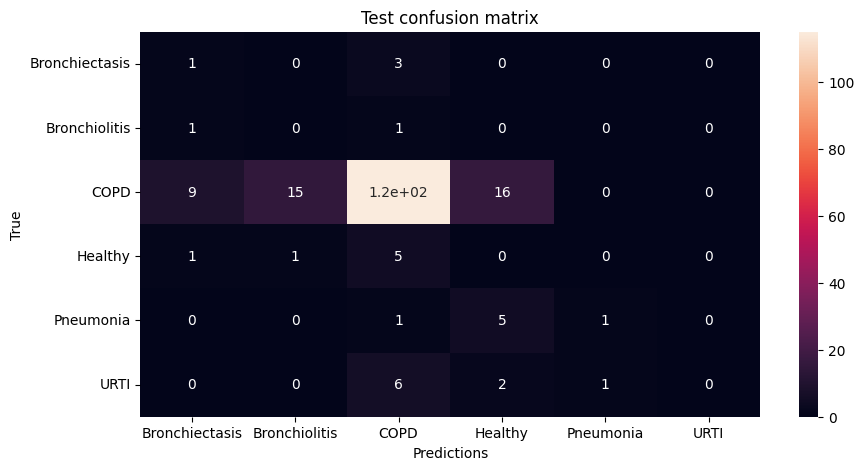


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 36:

Train Accuracy: 0.6893696581196581

Train Loss: 0.9518954249528738

Train F1 Score: 0.3511293877202731

Test Accuracy: 0.579861111111111

Test Loss: 1.7929639021555583

Test F1 Score: 0.24481909225384393




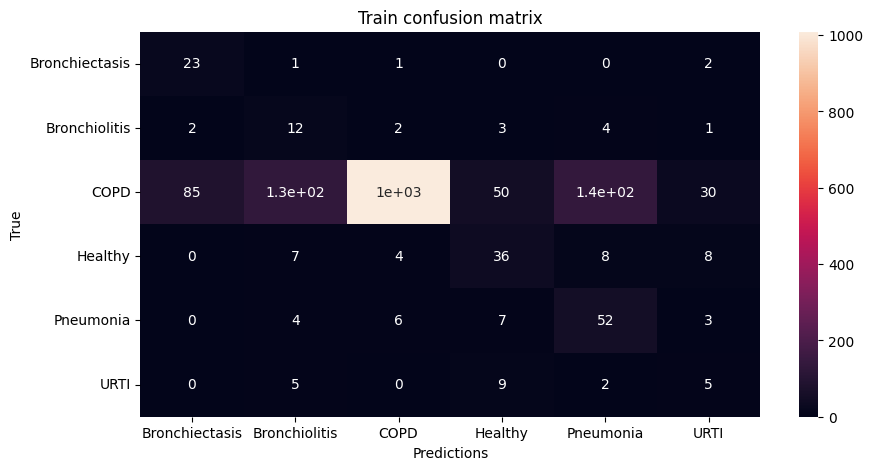

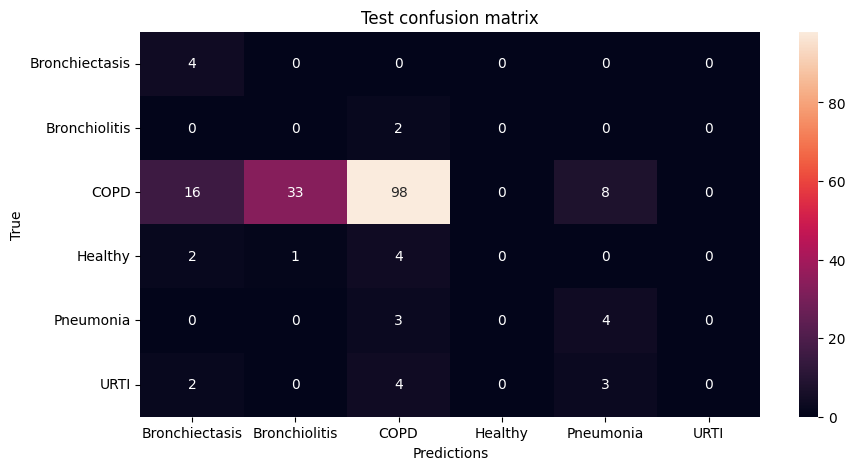


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 37:

Train Accuracy: 0.6856303418803419

Train Loss: 1.0253633332367127

Train F1 Score: 0.31646931228729397

Test Accuracy: 0.7690972222222222

Test Loss: 1.8642241954803467

Test F1 Score: 0.30198277284701663




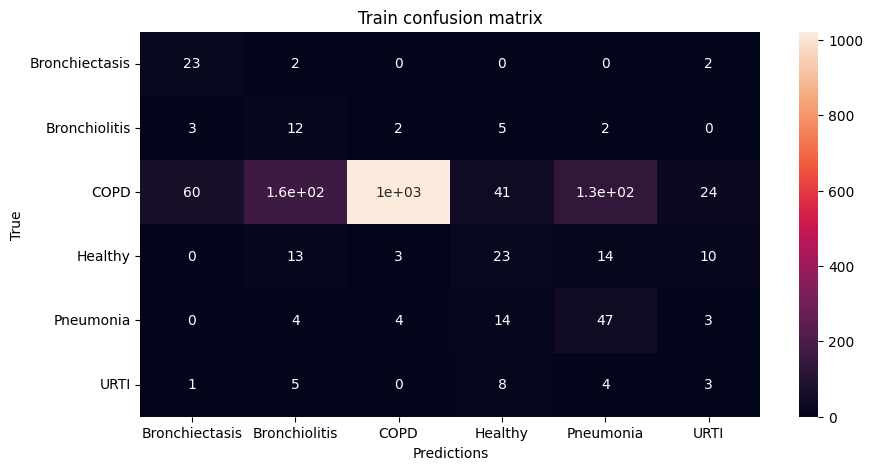

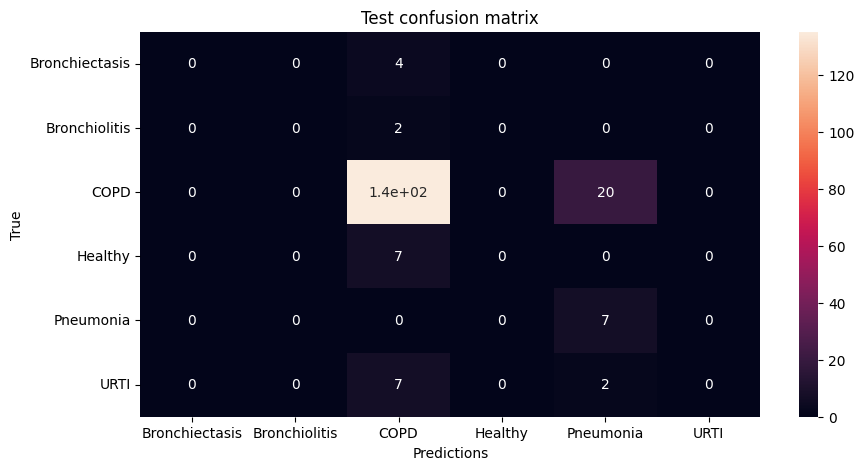


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 38:

Train Accuracy: 0.7201522435897435

Train Loss: 1.0132396496259248

Train F1 Score: 0.36664045315522414

Test Accuracy: 0.5711805555555556

Test Loss: 1.919023056825002

Test F1 Score: 0.22873125970363617




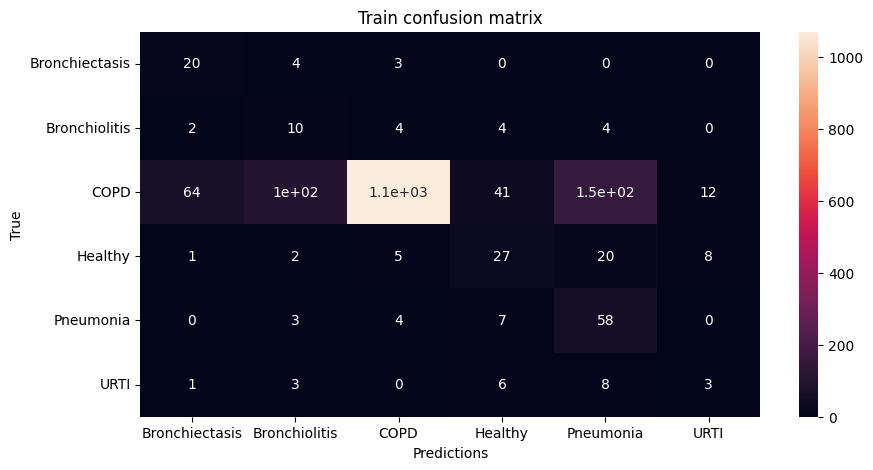

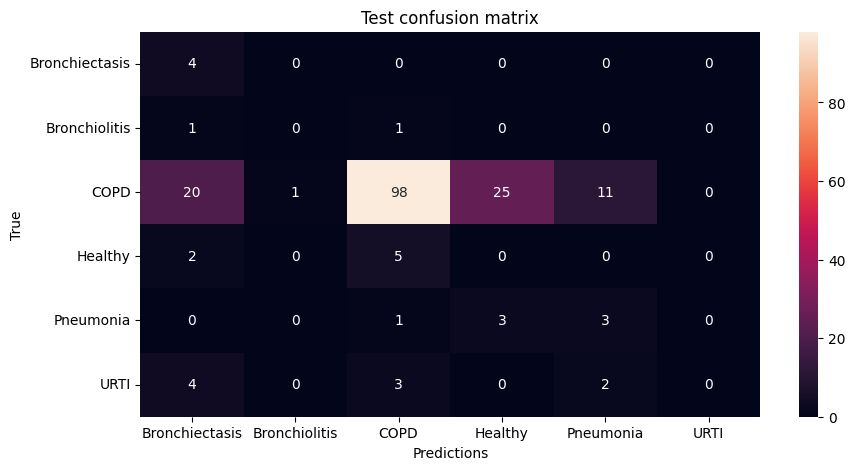


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 39:

Train Accuracy: 0.6639957264957265

Train Loss: 0.9841983902912873

Train F1 Score: 0.3146014101803303

Test Accuracy: 0.545138888888889

Test Loss: 1.8648361166318257

Test F1 Score: 0.20373612021406493




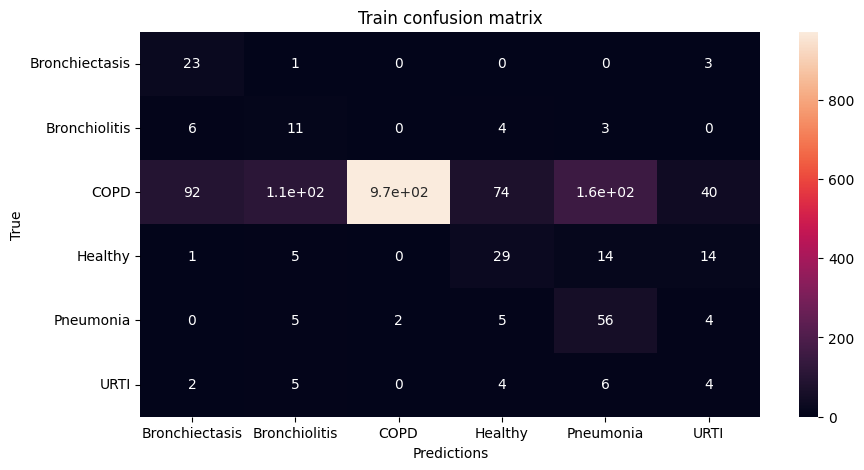

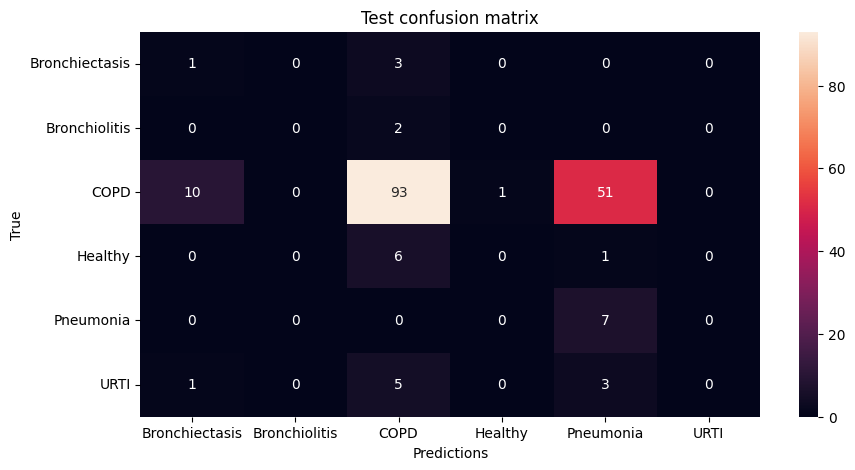


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 40:

Train Accuracy: 0.6522435897435896

Train Loss: 1.0821722430678515

Train F1 Score: 0.30682730560119337

Test Accuracy: 0.5104166666666666

Test Loss: 1.7703582644462585

Test F1 Score: 0.23217513908942541




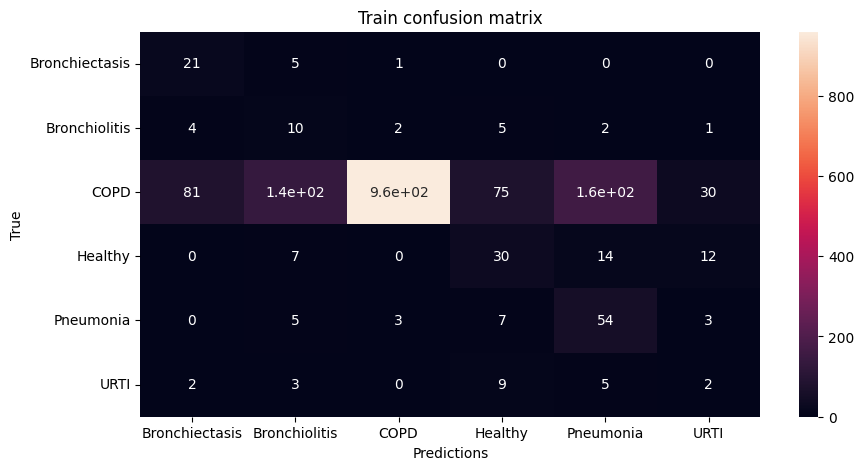

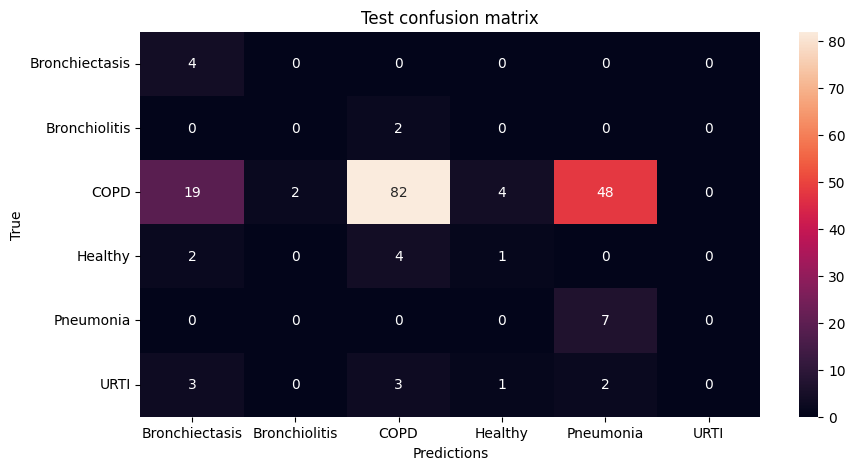


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 41:

Train Accuracy: 0.6680689102564104

Train Loss: 0.9649217604444578

Train F1 Score: 0.3305097053257319

Test Accuracy: 0.71875

Test Loss: 1.9827910860379536

Test F1 Score: 0.28372902671496075




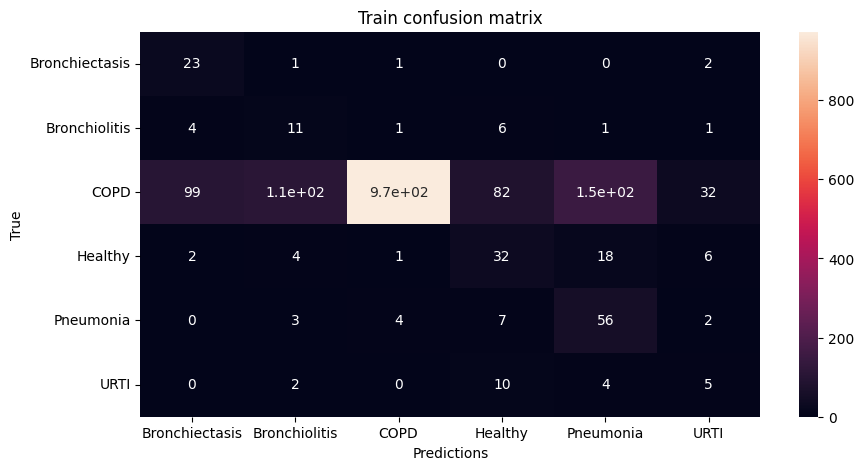

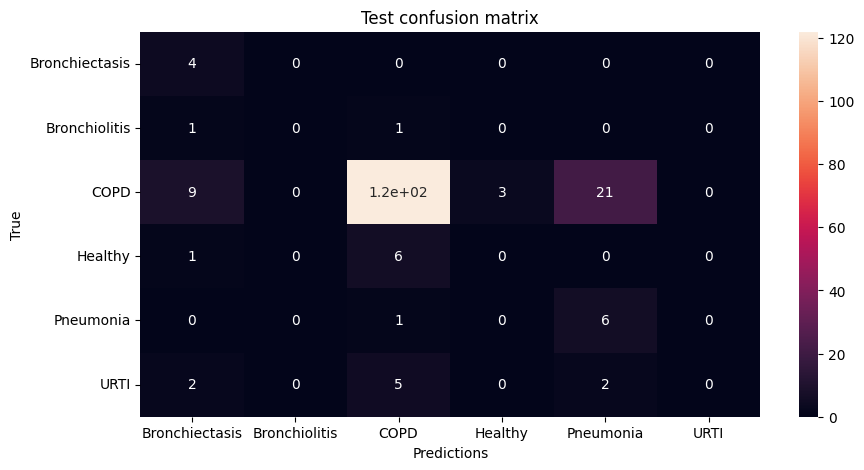


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 42:

Train Accuracy: 0.6722088675213675

Train Loss: 1.0330829035777311

Train F1 Score: 0.3280863350687119

Test Accuracy: 0.5399305555555556

Test Loss: 2.042132000128428

Test F1 Score: 0.2104168807466825




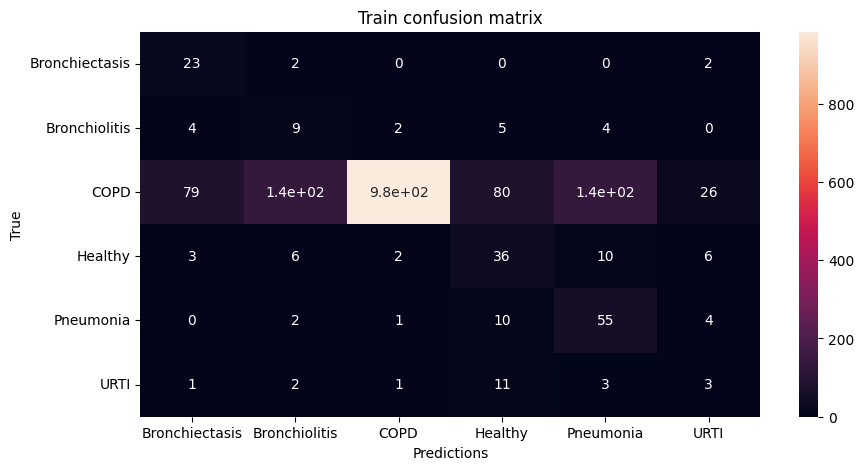

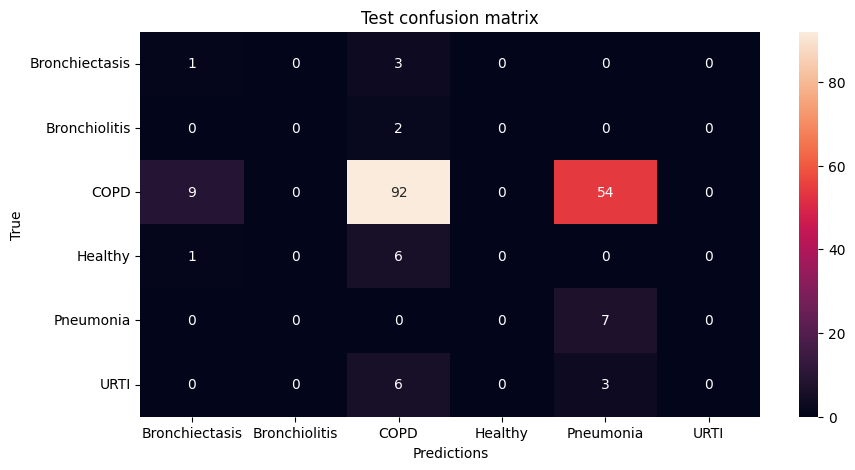


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 43:

Train Accuracy: 0.7142094017094016

Train Loss: 0.9662851685514817

Train F1 Score: 0.34005622135905117

Test Accuracy: 0.6840277777777778

Test Loss: 2.0661723812421164

Test F1 Score: 0.2751152391235034




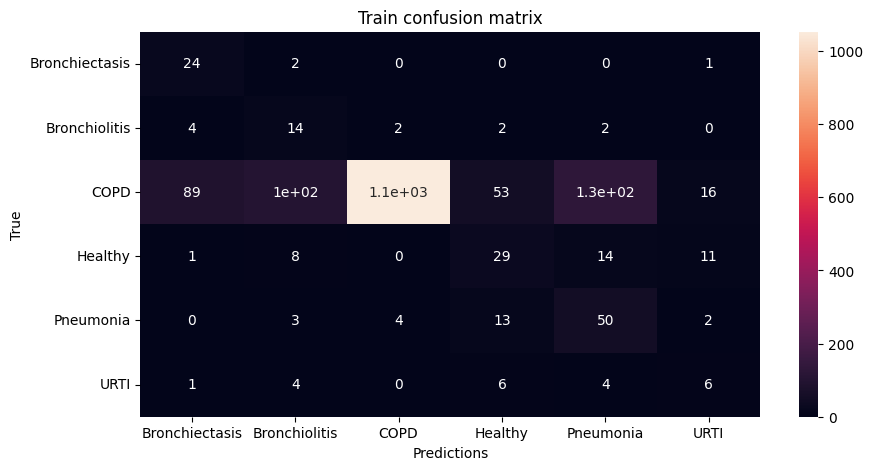

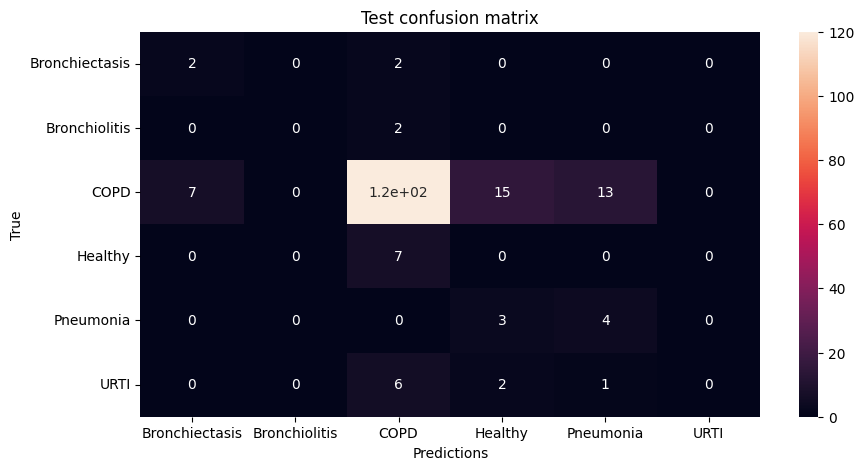


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 44:

Train Accuracy: 0.6674011752136753

Train Loss: 0.9707853656548721

Train F1 Score: 0.3090996720756476

Test Accuracy: 0.654513888888889

Test Loss: 1.9315858284632366

Test F1 Score: 0.24724491933981577




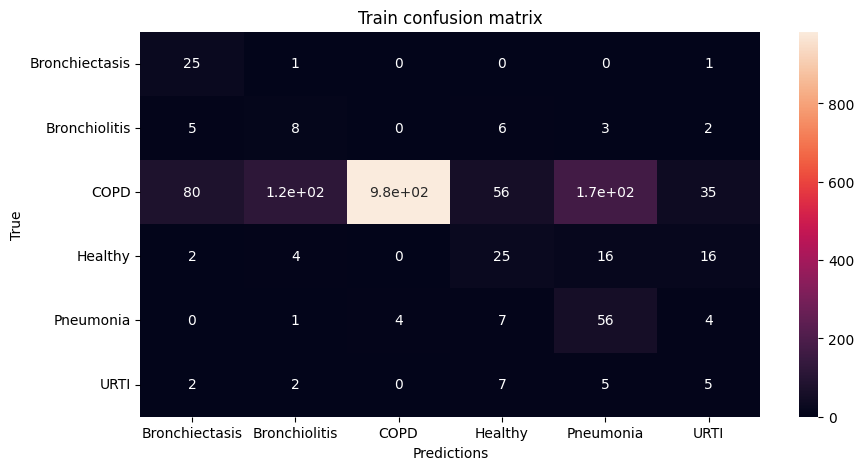

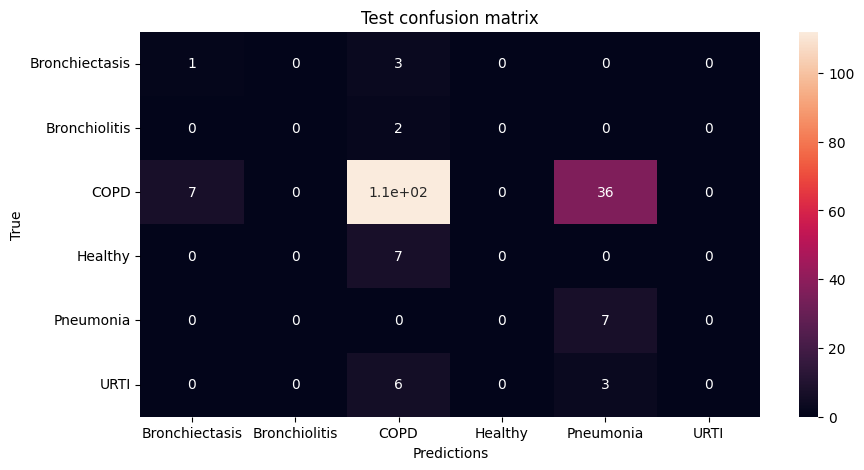


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 45:

Train Accuracy: 0.6875

Train Loss: 1.0104019550176768

Train F1 Score: 0.34558465245824593

Test Accuracy: 0.6284722222222222

Test Loss: 1.9837979475657146

Test F1 Score: 0.23936617374420166




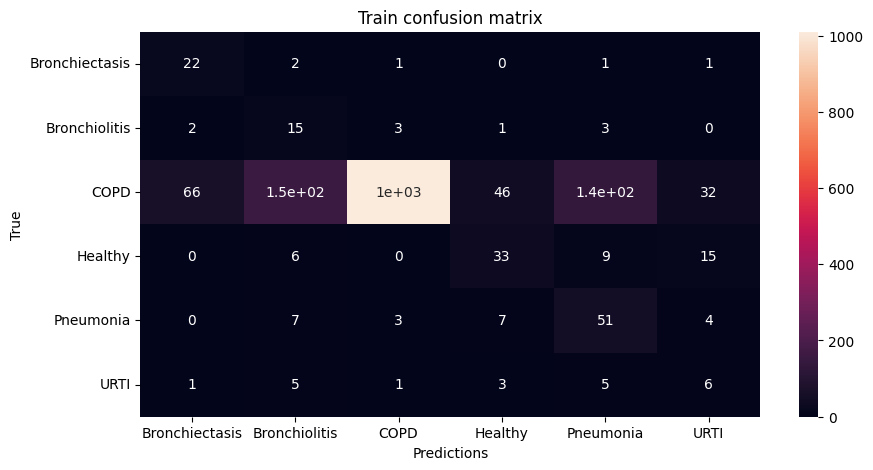

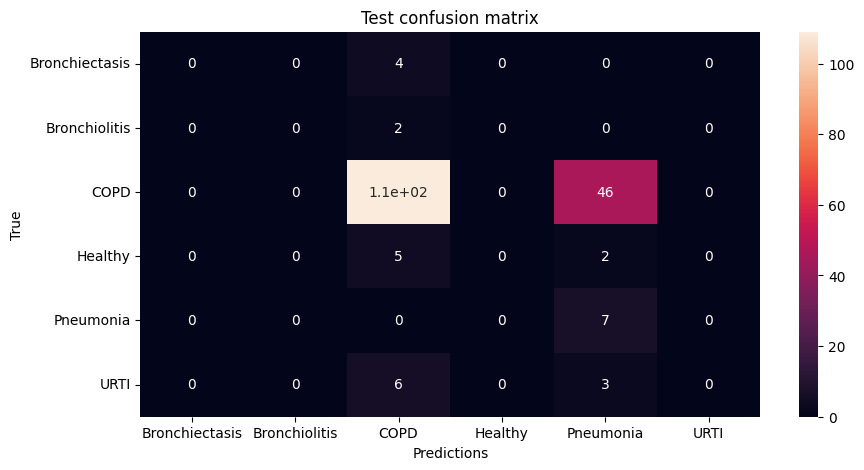


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 46:

Train Accuracy: 0.6646634615384616

Train Loss: 1.0652936267165036

Train F1 Score: 0.3244206730562907

Test Accuracy: 0.5677083333333334

Test Loss: 2.2085015177726746

Test F1 Score: 0.19072404752175012




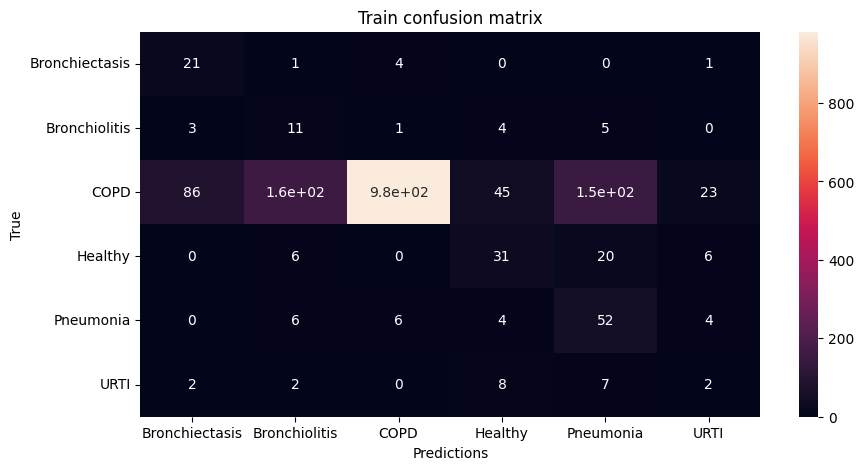

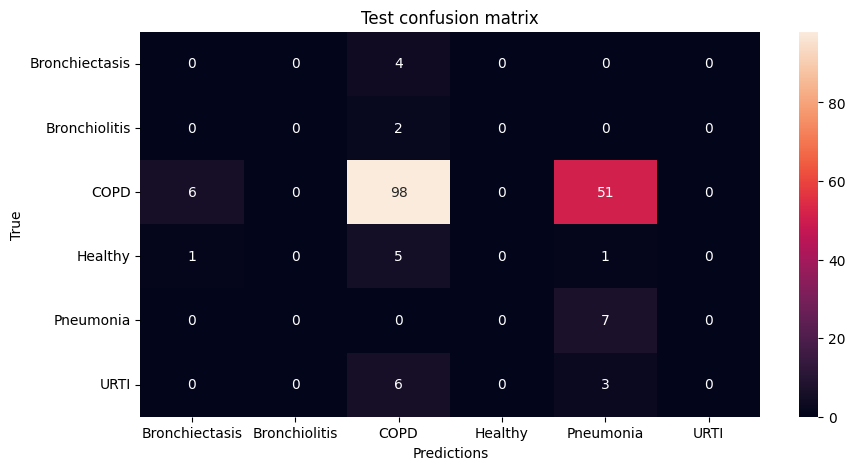


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 47:

Train Accuracy: 0.6937099358974359

Train Loss: 0.9416454726686845

Train F1 Score: 0.37304319785191464

Test Accuracy: 0.6875

Test Loss: 2.1918015678723655

Test F1 Score: 0.2594826693336169




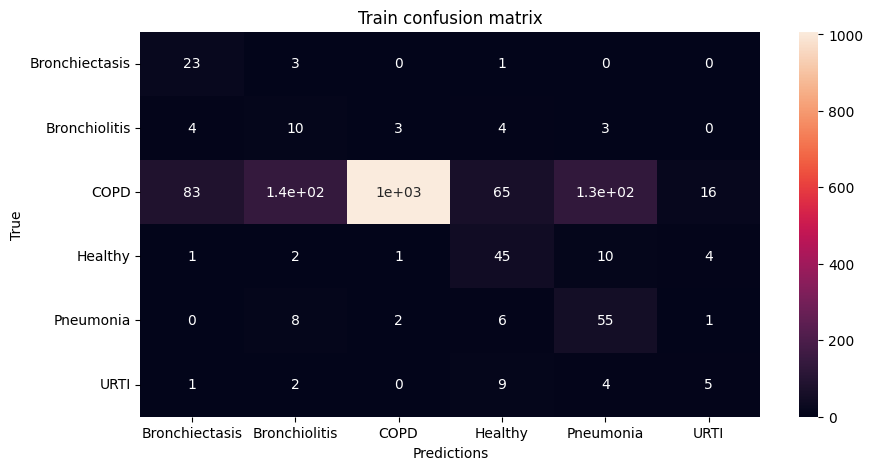

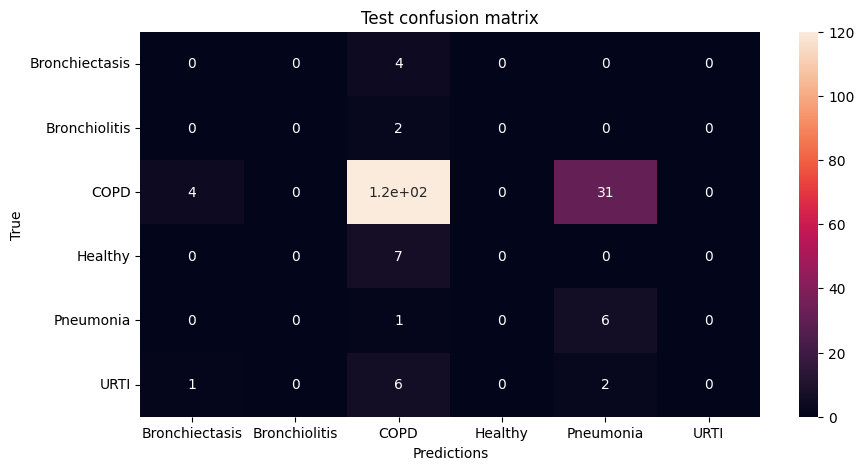


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 48:

Train Accuracy: 0.6887686965811965

Train Loss: 0.9637454593410859

Train F1 Score: 0.34421618497715545

Test Accuracy: 0.6510416666666666

Test Loss: 1.894025444984436

Test F1 Score: 0.189779723683993




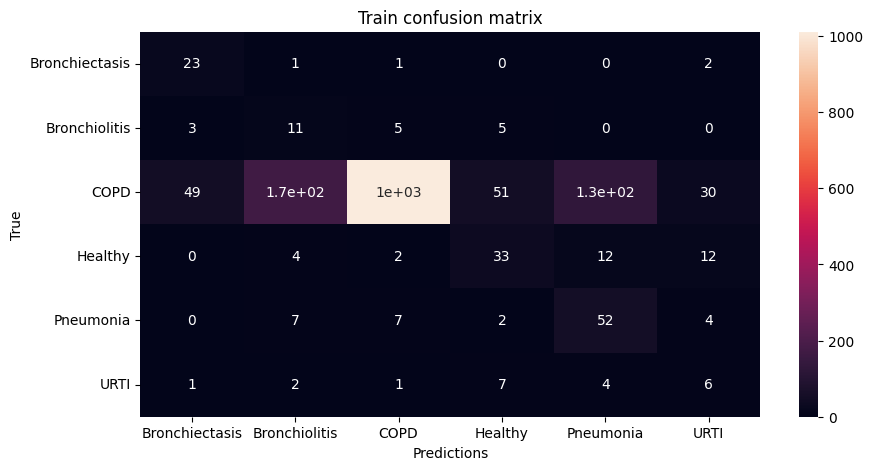

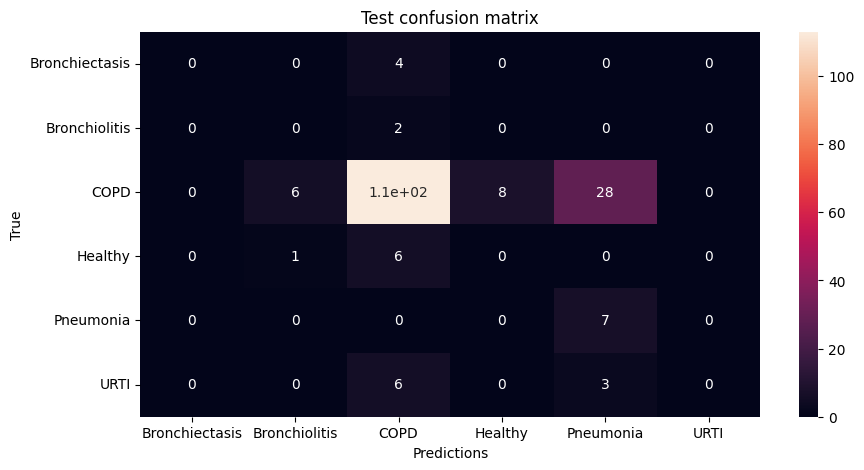


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 49:

Train Accuracy: 0.6623931623931624

Train Loss: 0.9642991016690547

Train F1 Score: 0.3468083512897675

Test Accuracy: 0.53125

Test Loss: 1.8376815517743428

Test F1 Score: 0.19929653406143188




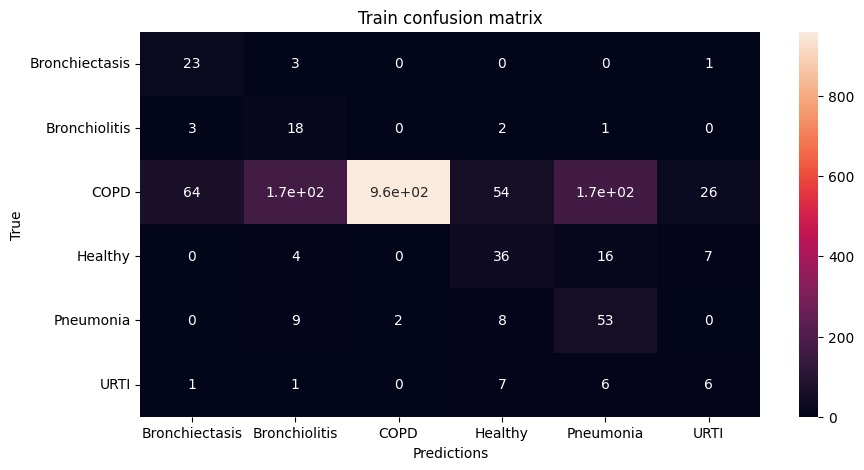

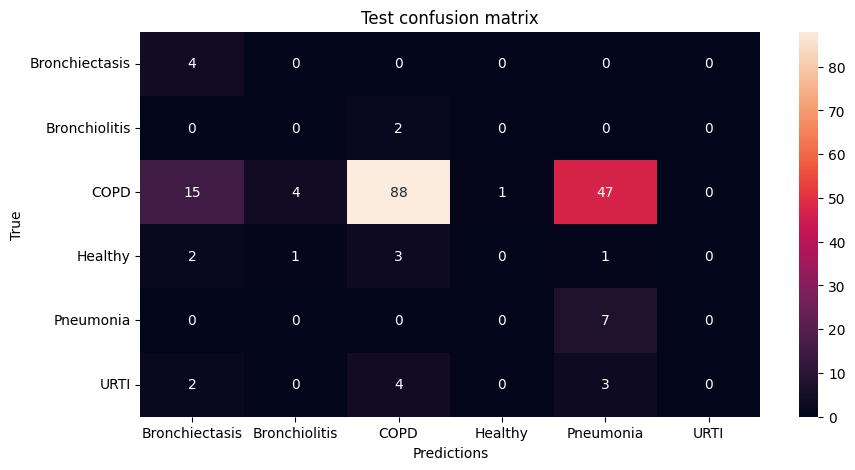


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 50:

Train Accuracy: 0.6758146367521368

Train Loss: 0.9287890760371318

Train F1 Score: 0.34171699130764377

Test Accuracy: 0.642361111111111

Test Loss: 2.004047433535258

Test F1 Score: 0.19725307077169418




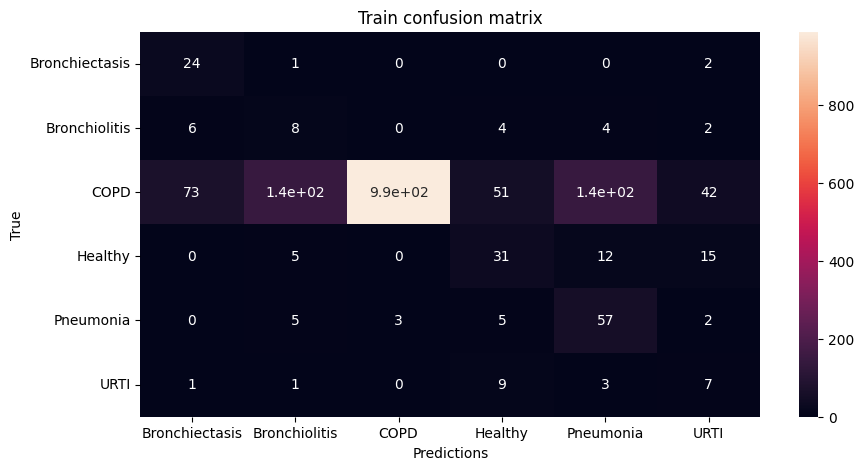

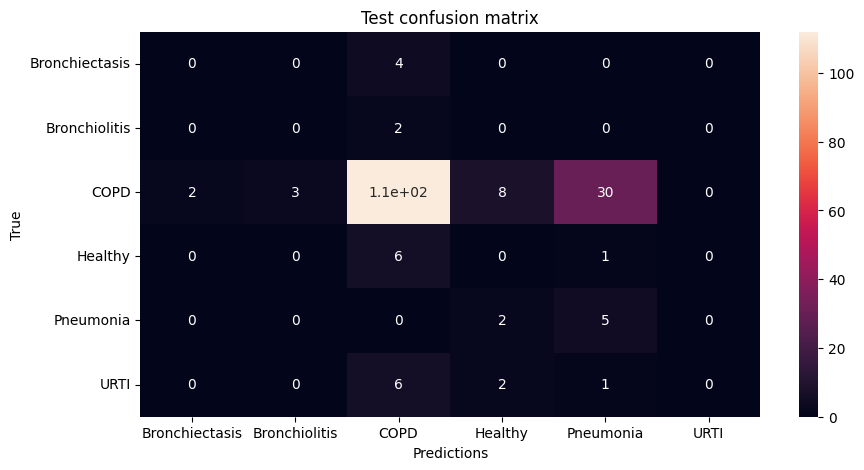


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 51:

Train Accuracy: 0.6639957264957265

Train Loss: 0.9985229625151708

Train F1 Score: 0.3457581883726212

Test Accuracy: 0.5399305555555556

Test Loss: 2.1300891637802124

Test F1 Score: 0.18531444172064462




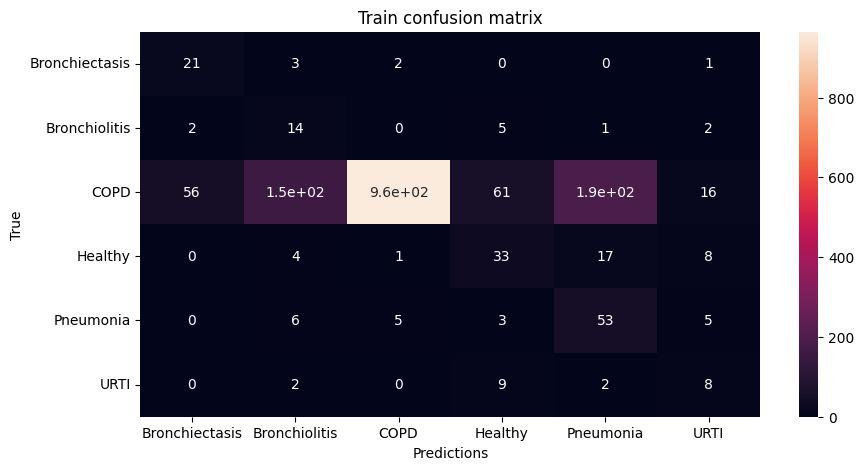

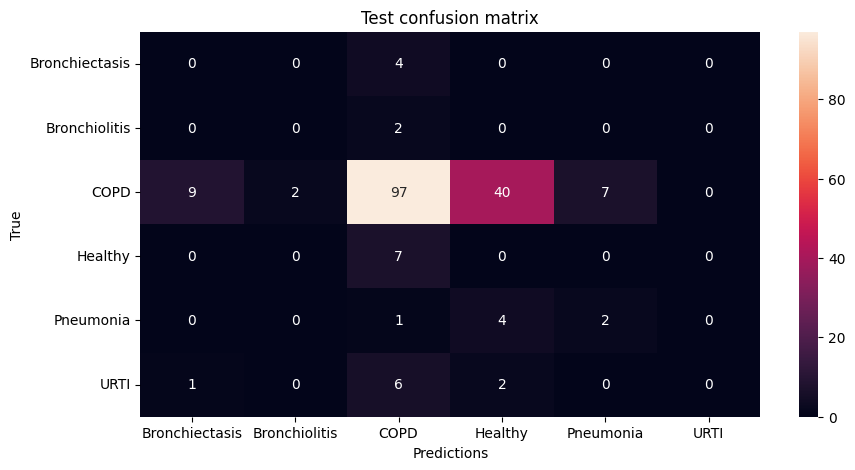


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 52:

Train Accuracy: 0.702457264957265

Train Loss: 0.873594724214994

Train F1 Score: 0.3547199205137216

Test Accuracy: 0.6684027777777778

Test Loss: 2.1288930575052896

Test F1 Score: 0.23101759950319925




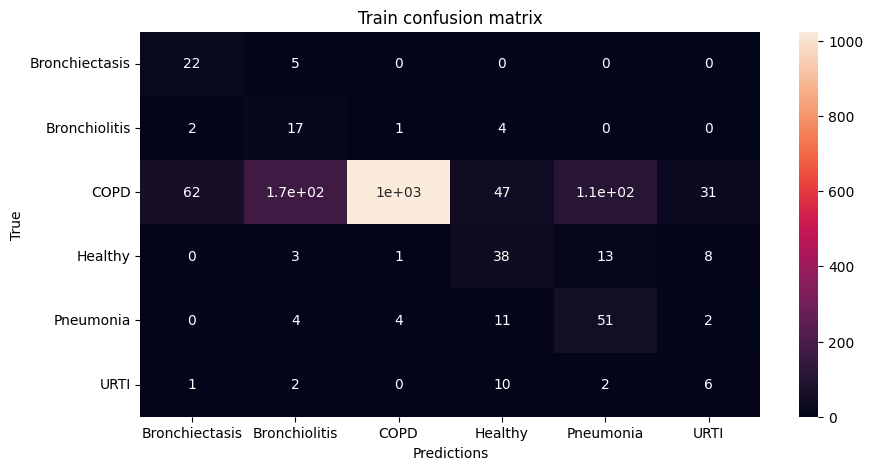

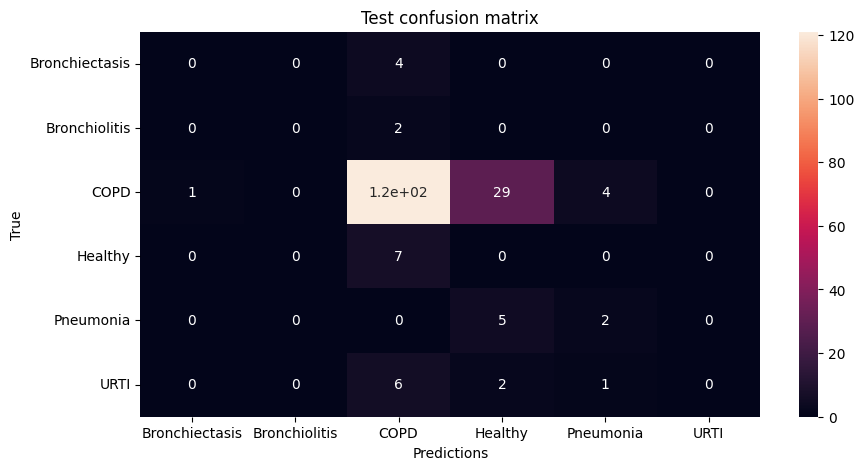


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 53:

Train Accuracy: 0.7120726495726496

Train Loss: 0.9196686045481608

Train F1 Score: 0.34620708571030545

Test Accuracy: 0.48784722222222227

Test Loss: 1.9699625968933105

Test F1 Score: 0.22646386673053107




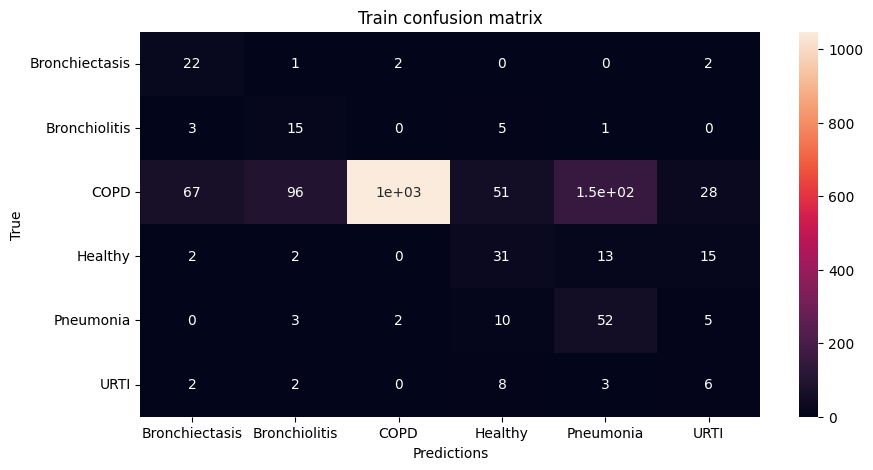

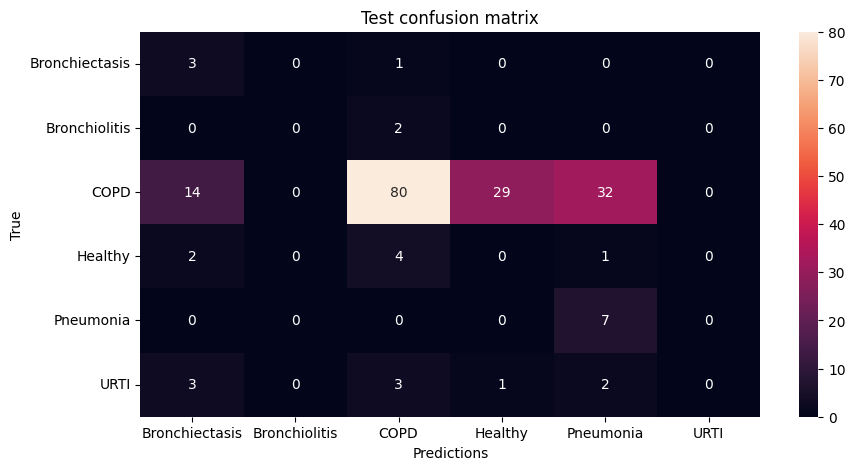


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 54:

Train Accuracy: 0.6838274572649573

Train Loss: 0.8955281723577243

Train F1 Score: 0.34242344246460843

Test Accuracy: 0.626736111111111

Test Loss: 2.4447422424952188

Test F1 Score: 0.19461051871379217




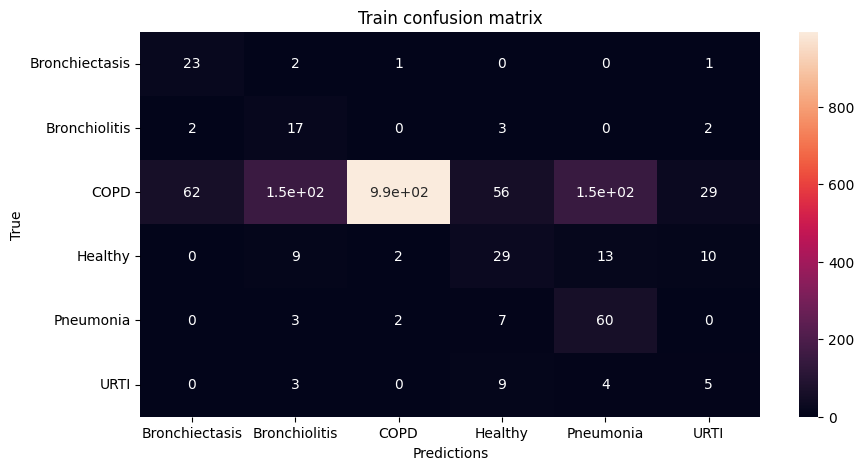

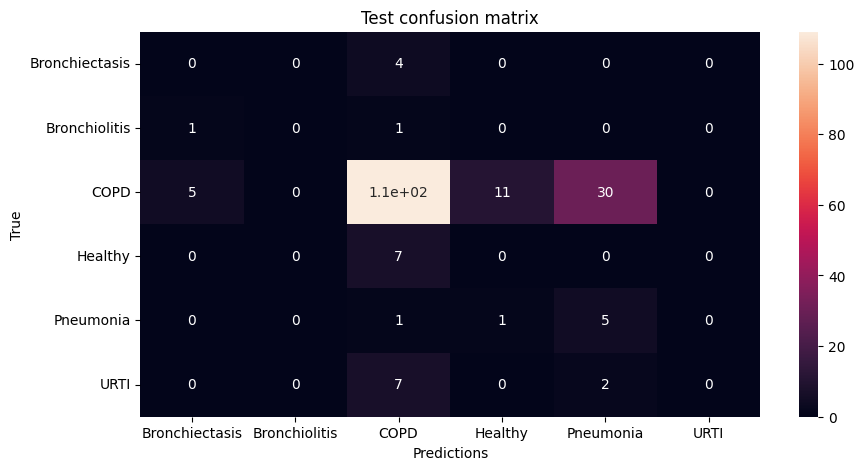


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 55:

Train Accuracy: 0.7057291666666666

Train Loss: 0.8448770811351446

Train F1 Score: 0.3791259438372575

Test Accuracy: 0.8385416666666666

Test Loss: 3.464237908522288

Test F1 Score: 0.24864598860343298




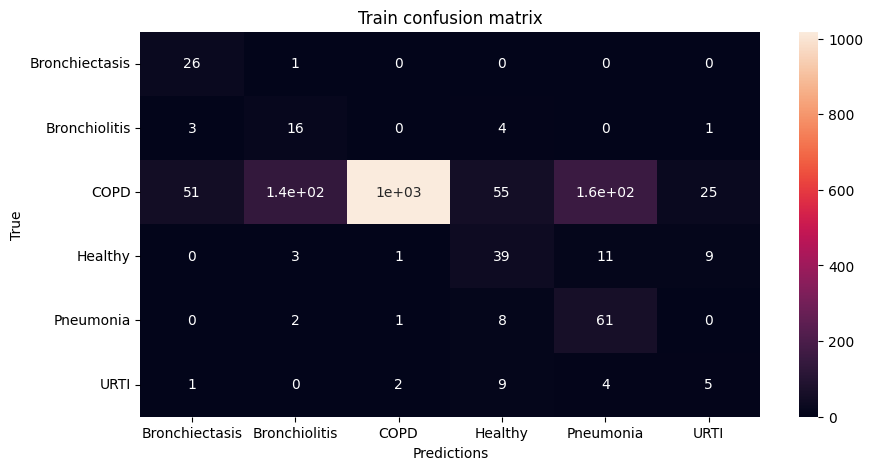

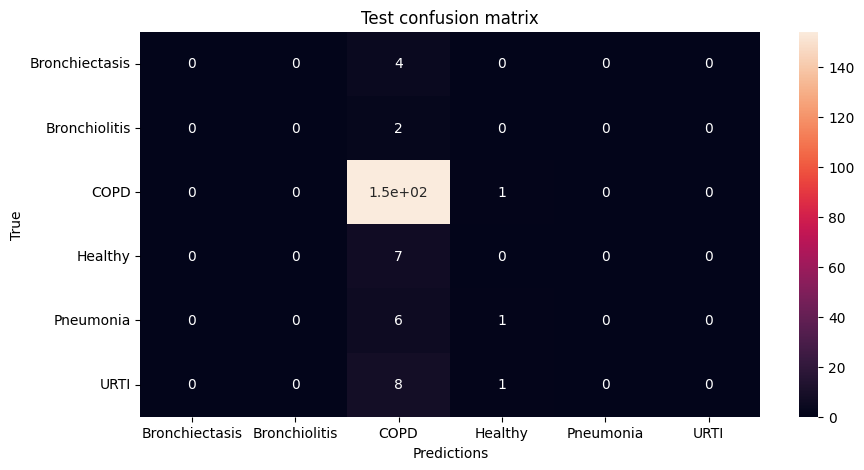


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 56:

Train Accuracy: 0.7234241452991453

Train Loss: 0.9755289097531483

Train F1 Score: 0.36658162165146607

Test Accuracy: 0.6215277777777778

Test Loss: 1.9107051491737366

Test F1 Score: 0.2611847147345543




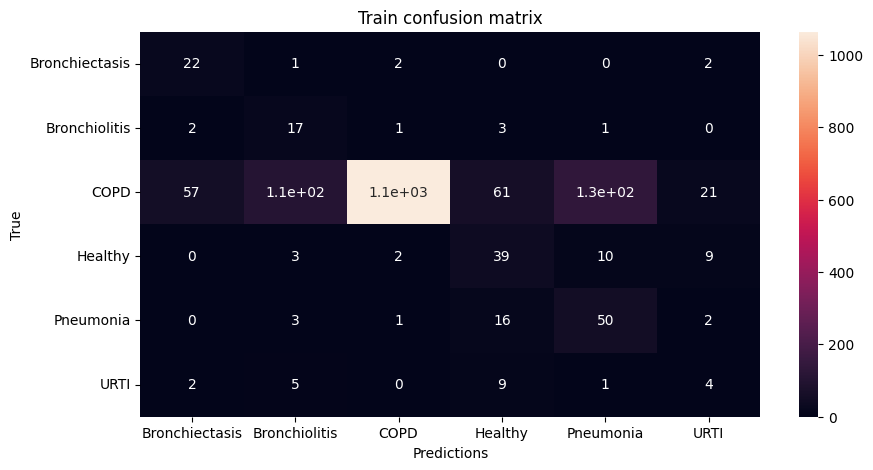

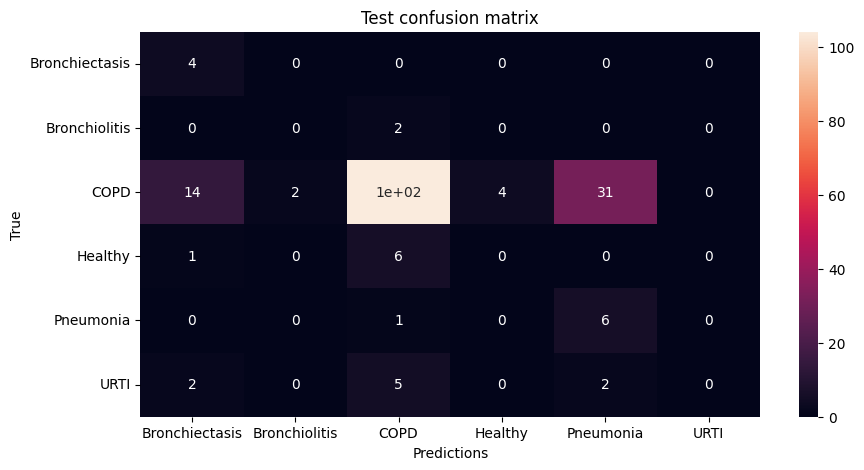


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 57:

Train Accuracy: 0.7068643162393162

Train Loss: 0.8888125501286525

Train F1 Score: 0.3431905470788479

Test Accuracy: 0.4947916666666667

Test Loss: 2.0937182704607644

Test F1 Score: 0.19410415366292




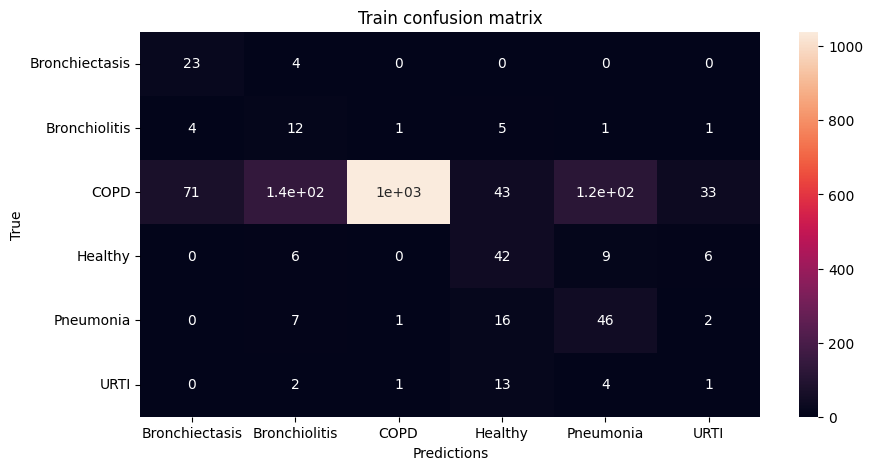

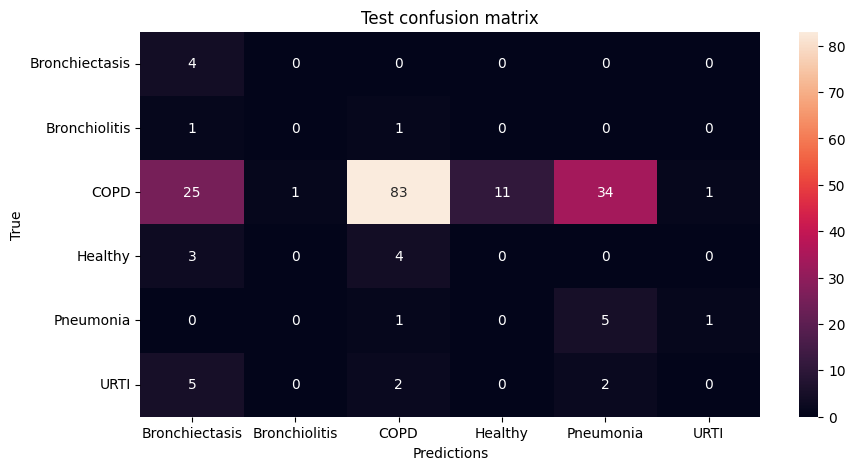


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 58:

Train Accuracy: 0.6965811965811965

Train Loss: 0.8441770816078553

Train F1 Score: 0.35039992057360136

Test Accuracy: 0.5868055555555556

Test Loss: 2.0474786957105002

Test F1 Score: 0.26381410161654156




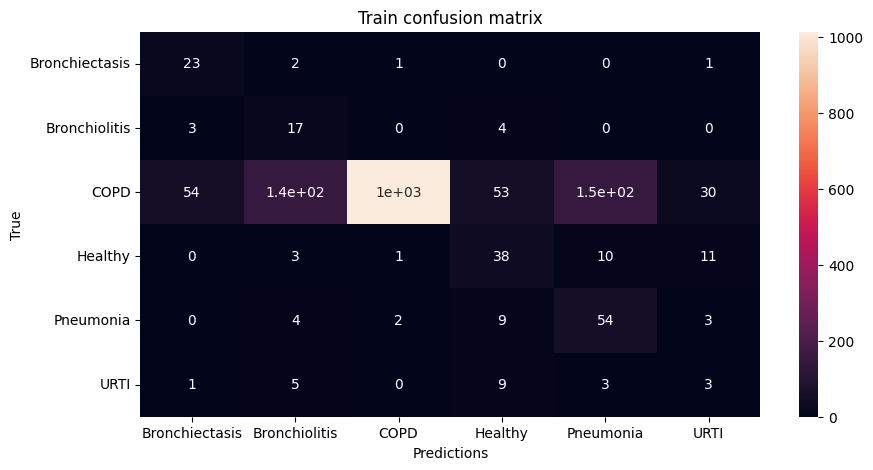

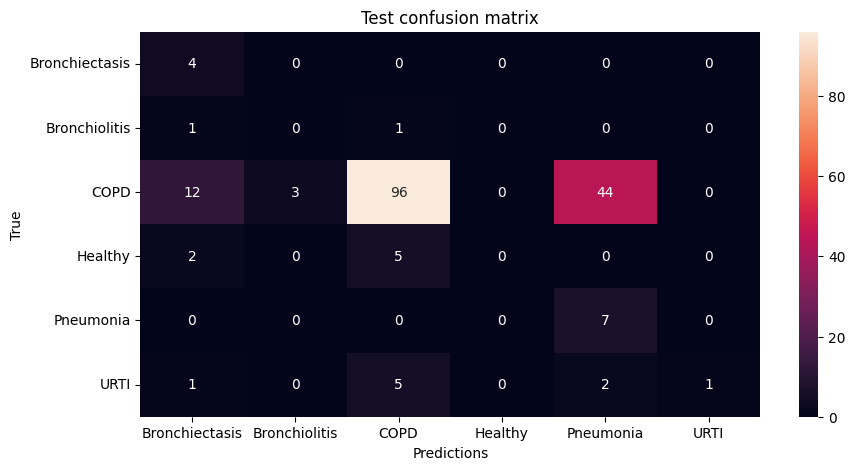


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 59:

Train Accuracy: 0.6963808760683761

Train Loss: 0.9146705023371257

Train F1 Score: 0.34629759622307926

Test Accuracy: 0.6024305555555556

Test Loss: 2.1695514718691506

Test F1 Score: 0.21288125216960907




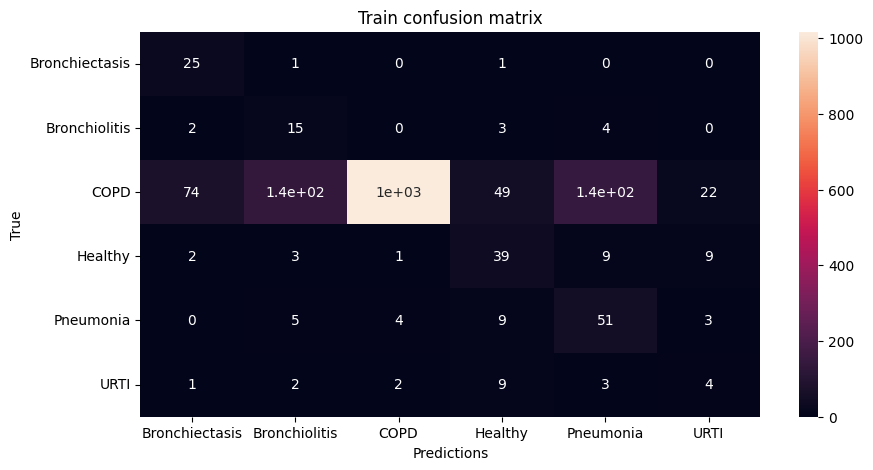

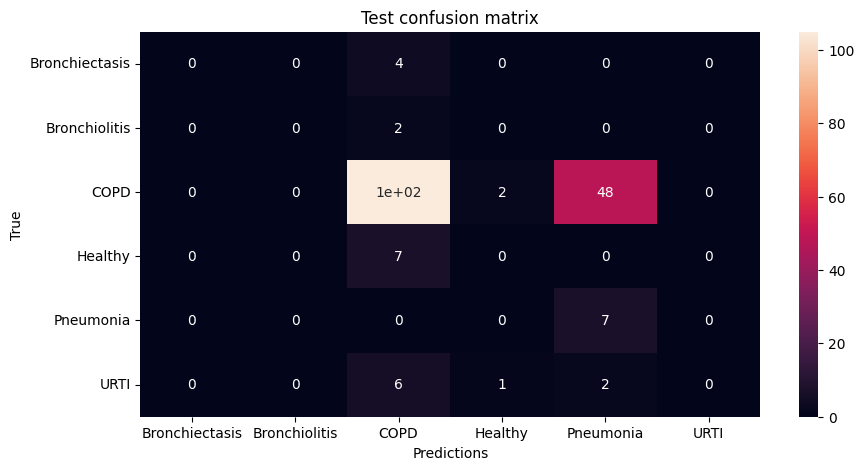


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 60:

Train Accuracy: 0.6913060897435896

Train Loss: 0.9107172380273159

Train F1 Score: 0.3580716268087809

Test Accuracy: 0.5885416666666666

Test Loss: 2.372066915035248

Test F1 Score: 0.19300459076960882




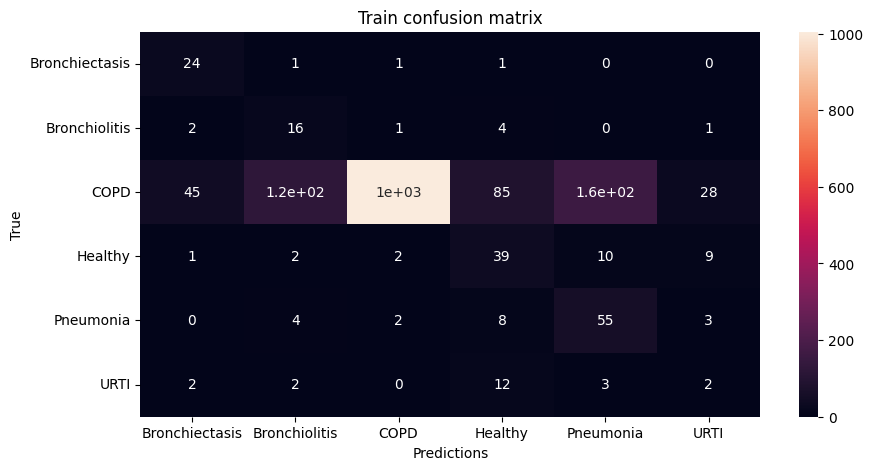

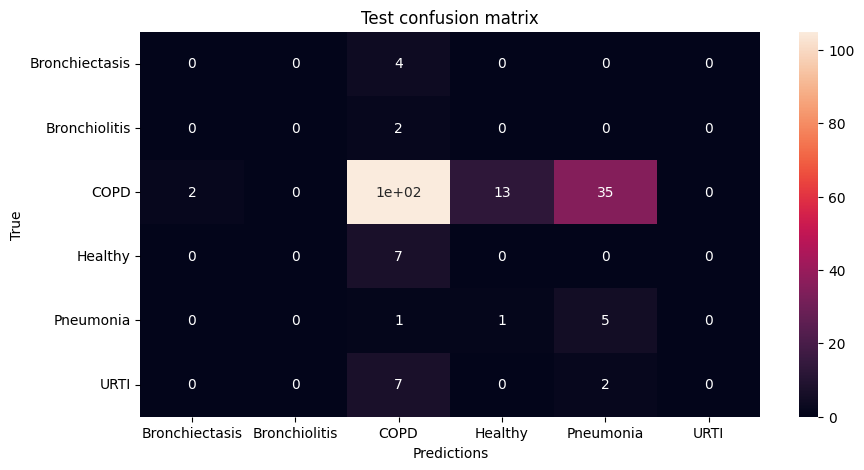


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 61:

Train Accuracy: 0.703659188034188

Train Loss: 0.8766888801295024

Train F1 Score: 0.36244199310357755

Test Accuracy: 0.7847222222222222

Test Loss: 2.3584766189257302

Test F1 Score: 0.33828890571991604




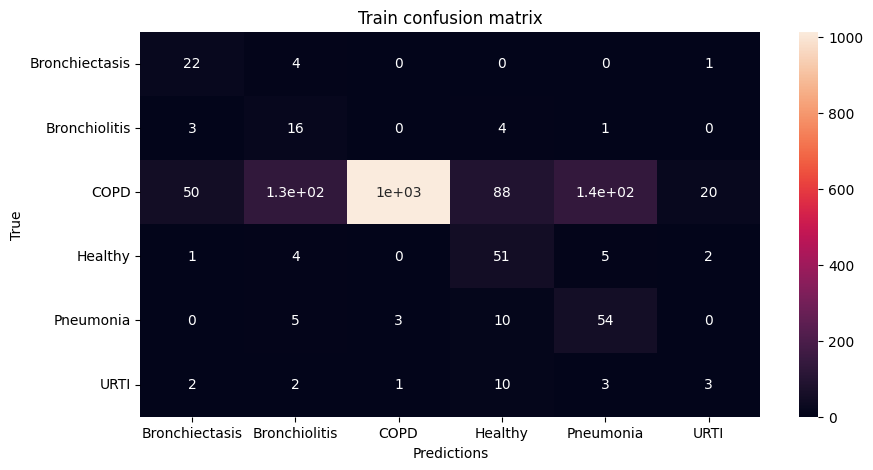

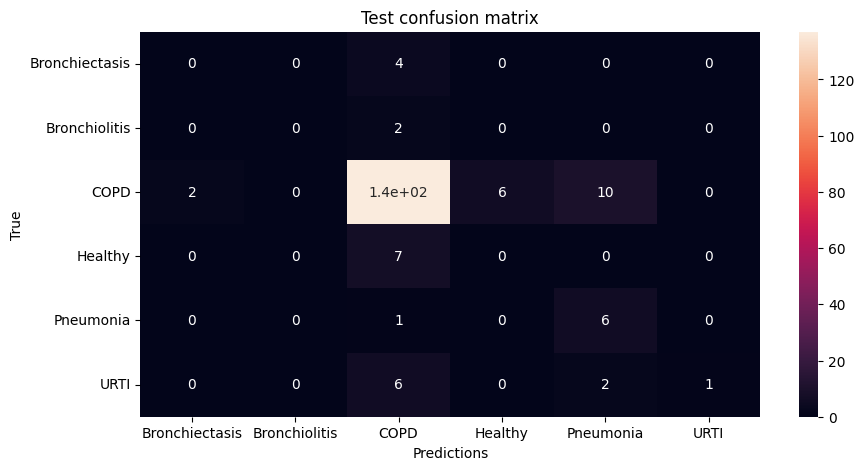


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 62:

Train Accuracy: 0.7303685897435896

Train Loss: 0.7723884932123698

Train F1 Score: 0.40208551875100684

Test Accuracy: 0.7621527777777778

Test Loss: 3.279503126939138

Test F1 Score: 0.2779151275753975




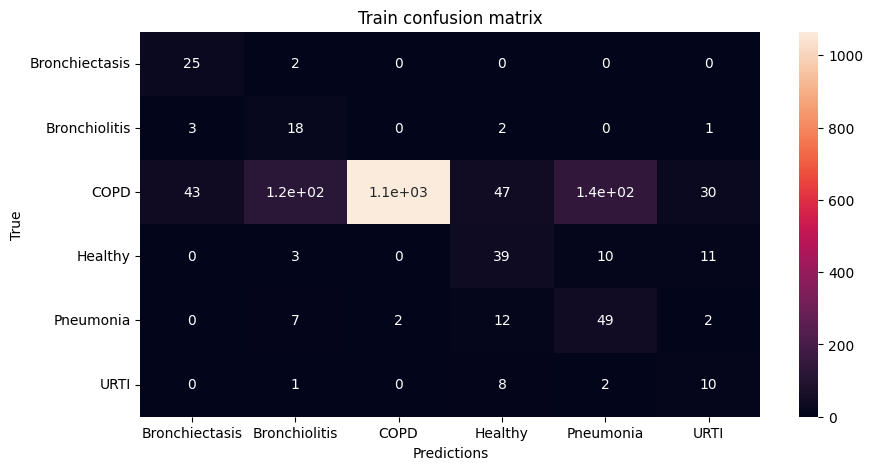

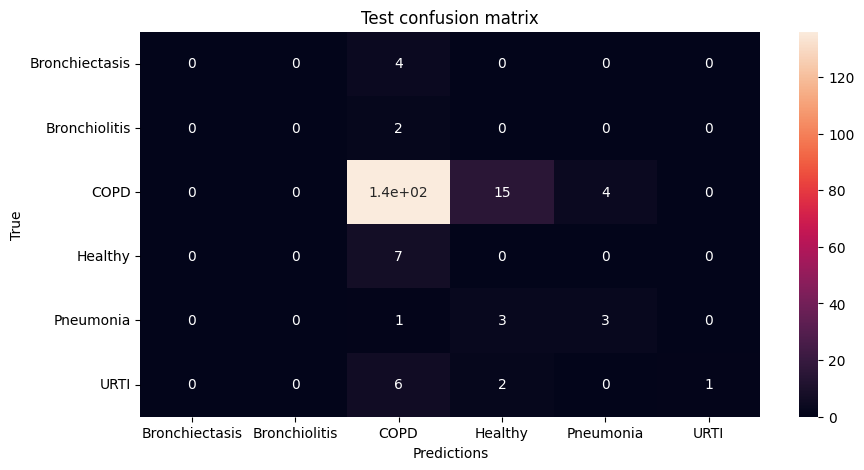


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 63:

Train Accuracy: 0.7414529914529915

Train Loss: 0.7934698648750782

Train F1 Score: 0.3778627976202048

Test Accuracy: 0.7621527777777778

Test Loss: 2.654688537120819

Test F1 Score: 0.25259370853503543




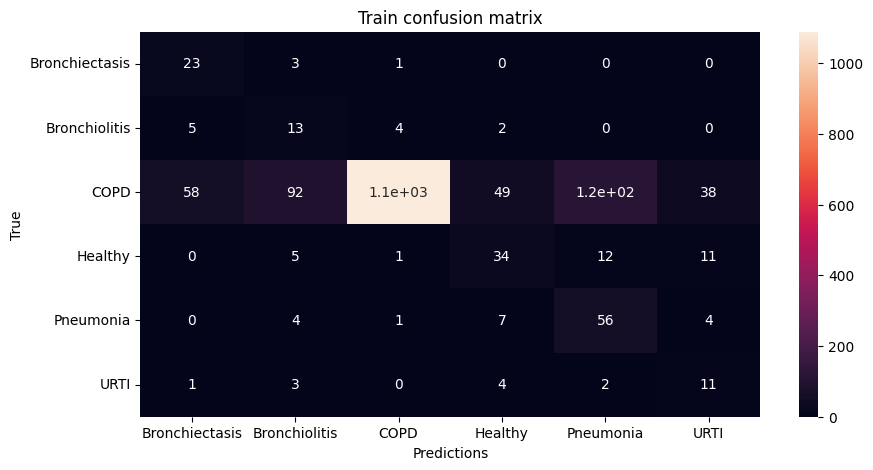

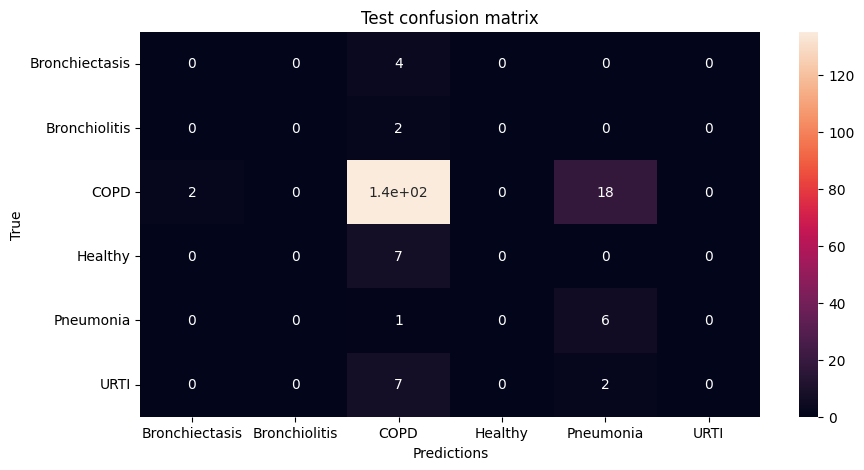


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 64:

Train Accuracy: 0.6633279914529915

Train Loss: 1.2221557750151708

Train F1 Score: 0.36453790962696075

Test Accuracy: 0.3697916666666667

Test Loss: 1.6767486333847046

Test F1 Score: 0.19573591525355974




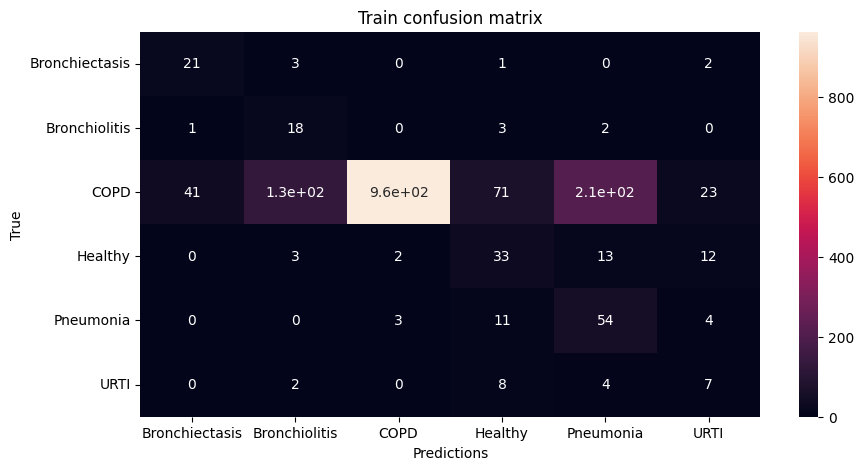

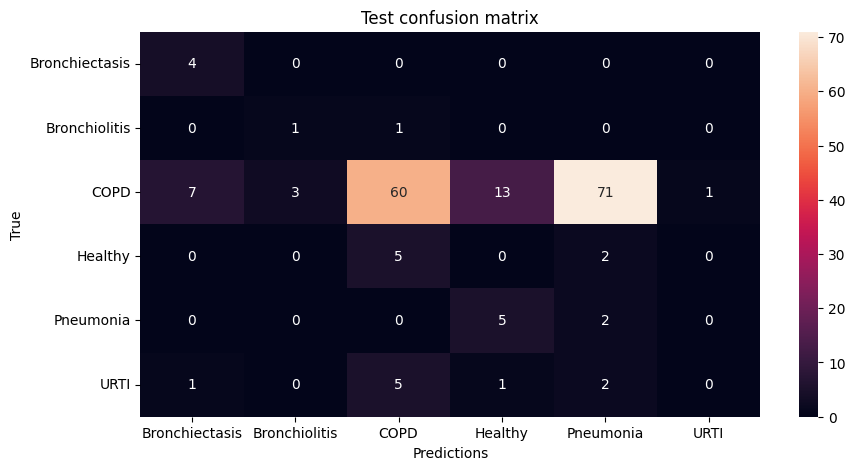


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 65:

Train Accuracy: 0.585803952991453

Train Loss: 1.2873759584931226

Train F1 Score: 0.2838522827682587

Test Accuracy: 0.4079861111111111

Test Loss: 1.7846606175104778

Test F1 Score: 0.1799073355893294




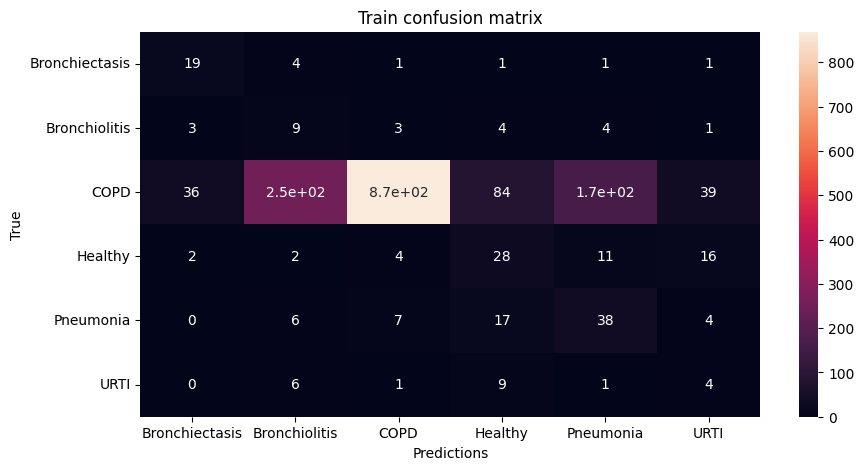

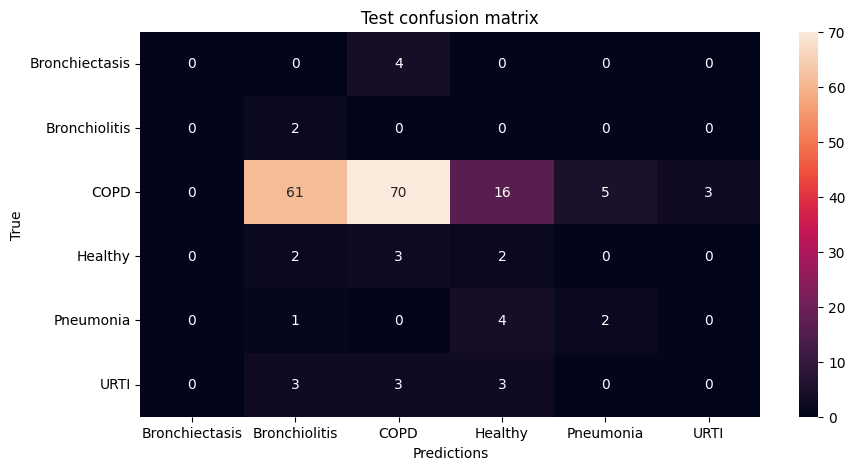


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 66:

Train Accuracy: 0.5811965811965811

Train Loss: 1.1385367002624731

Train F1 Score: 0.28064711592518365

Test Accuracy: 0.3975694444444444

Test Loss: 1.7824430465698242

Test F1 Score: 0.20149947454531988




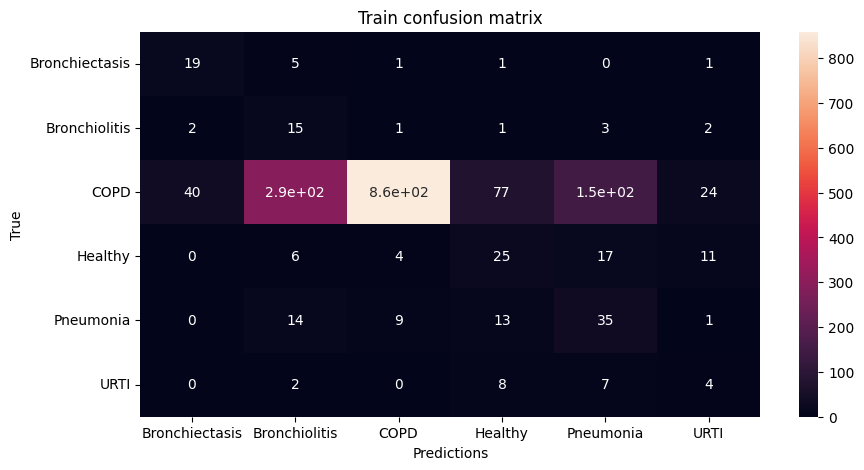

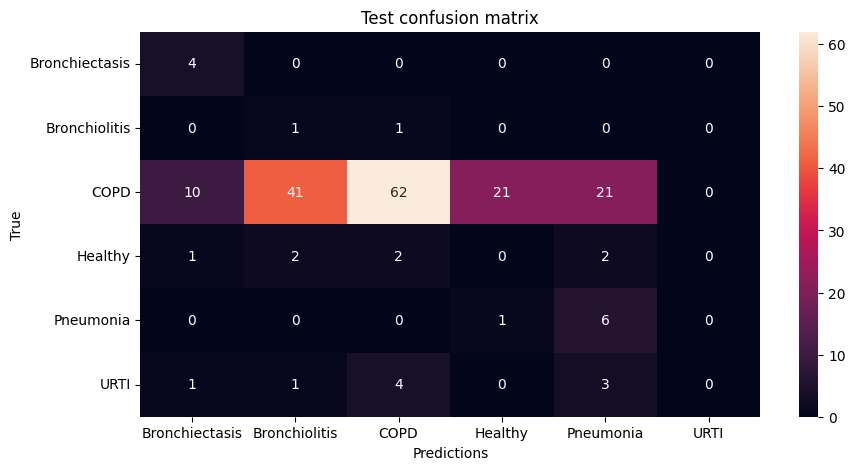


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 67:

Train Accuracy: 0.6183226495726496

Train Loss: 1.052437270490023

Train F1 Score: 0.3258829489350319

Test Accuracy: 0.46527777777777773

Test Loss: 1.7088542580604553

Test F1 Score: 0.21545040607452393




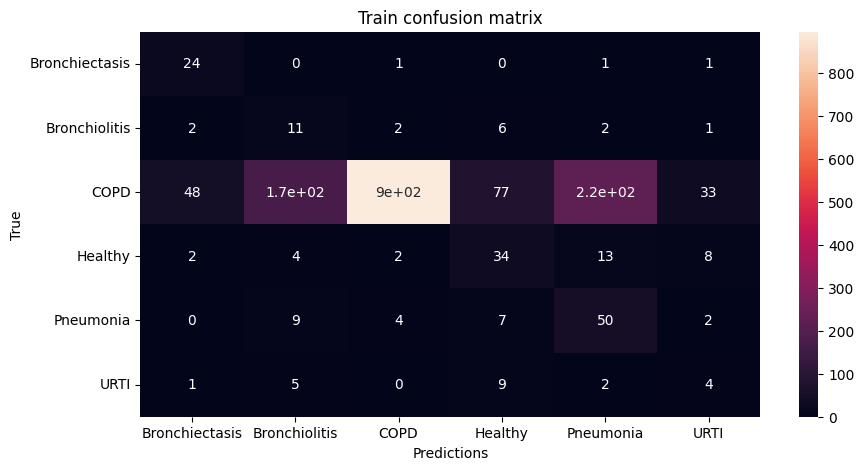

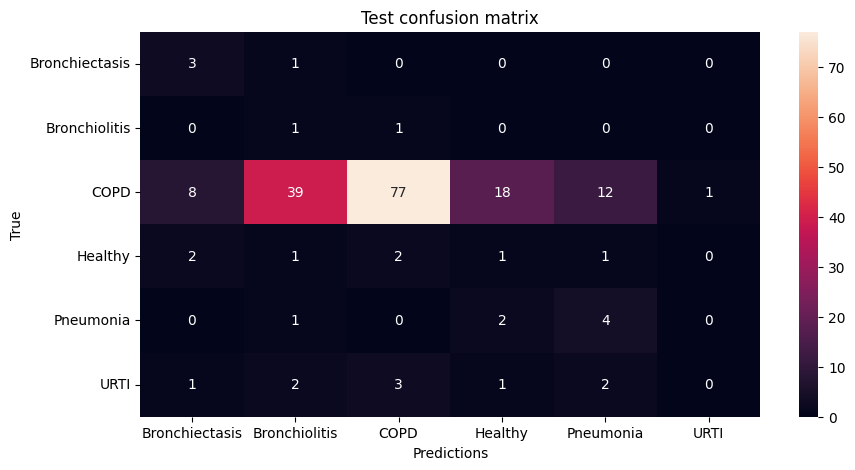


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 68:

Train Accuracy: 0.6288060897435896

Train Loss: 1.0160999974379172

Train F1 Score: 0.3165434319525957

Test Accuracy: 0.548611111111111

Test Loss: 2.230178793271383

Test F1 Score: 0.1812913455069065




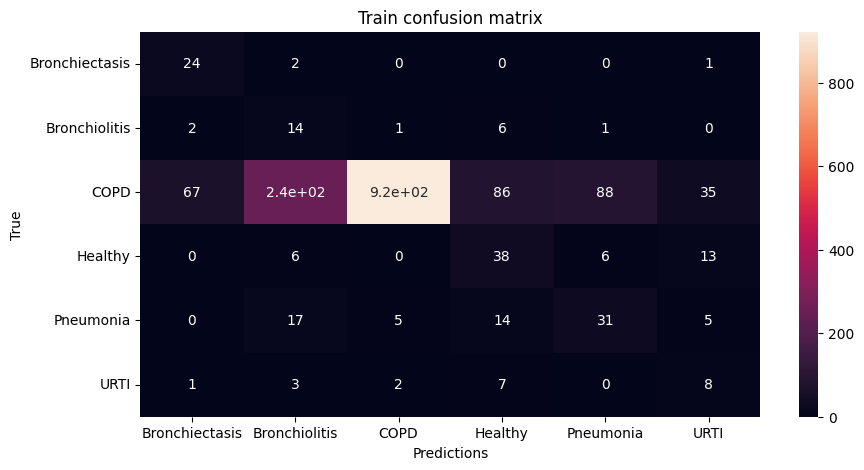

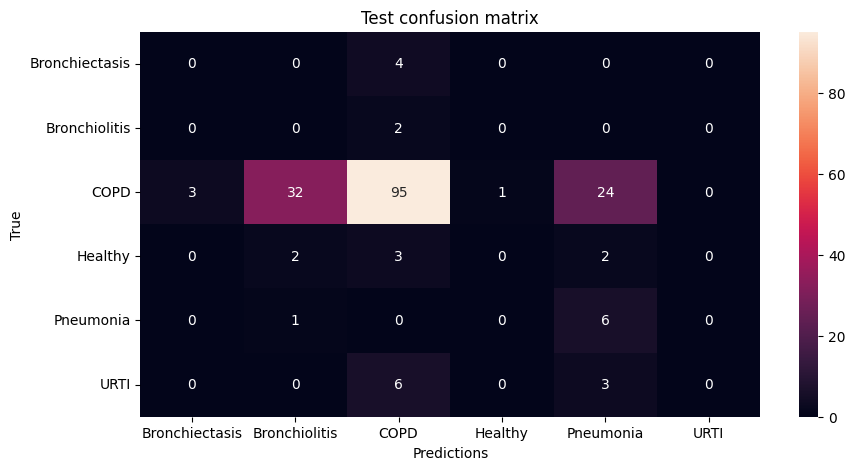


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 69:

Train Accuracy: 0.6447649572649573

Train Loss: 0.9492611140012741

Train F1 Score: 0.34545224675765407

Test Accuracy: 0.4548611111111111

Test Loss: 2.281664550304413

Test F1 Score: 0.15156065672636032




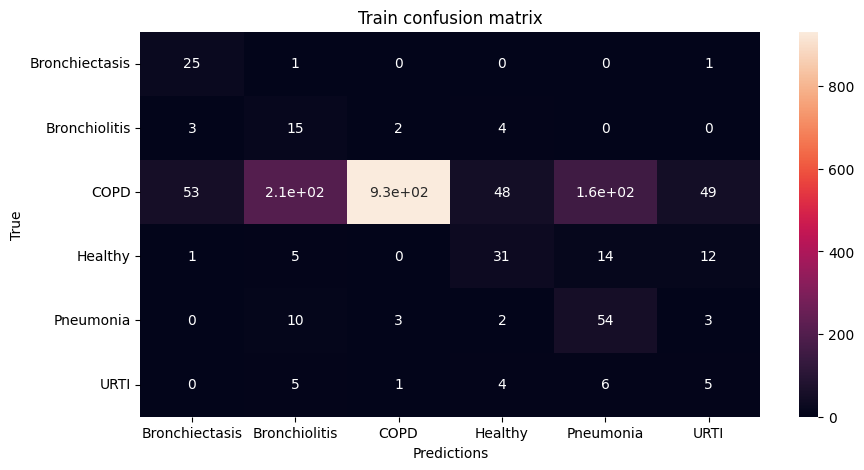

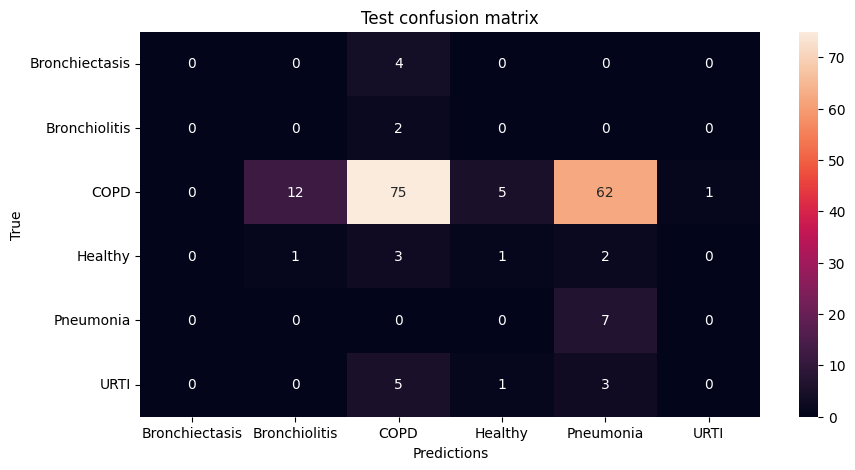


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 70:

Train Accuracy: 0.5910790598290598

Train Loss: 1.0146577971485944

Train F1 Score: 0.2885800756227512

Test Accuracy: 0.4913194444444444

Test Loss: 2.115427613258362

Test F1 Score: 0.230657576272885




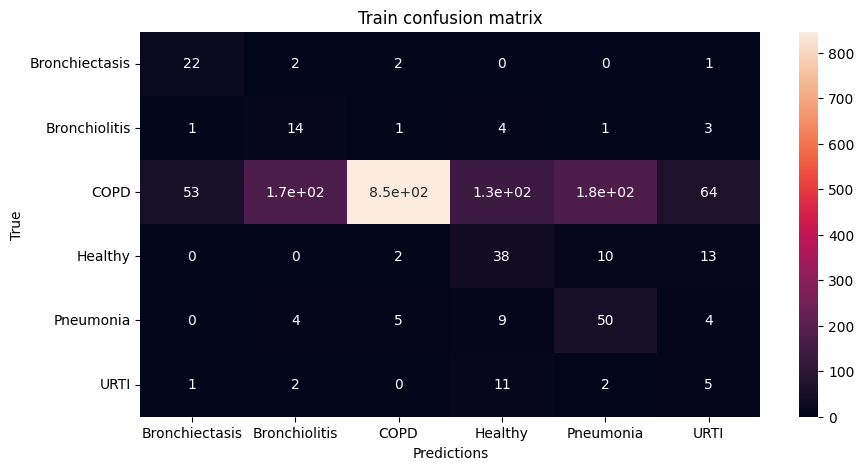

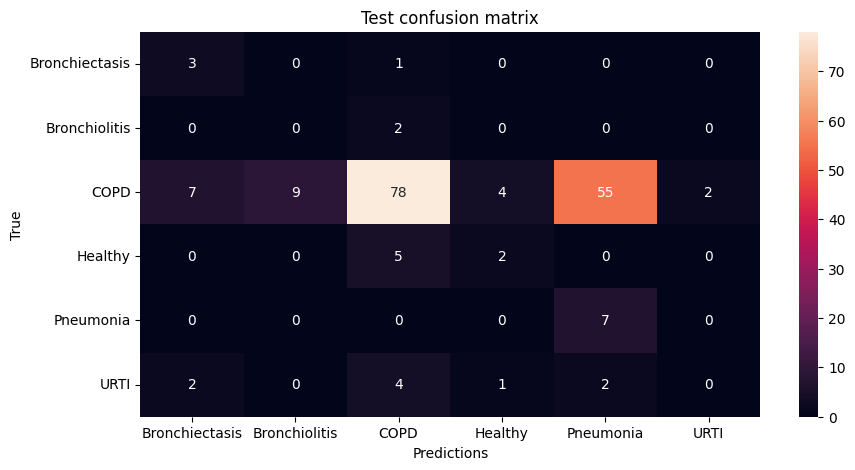


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 71:

Train Accuracy: 0.6162526709401709

Train Loss: 1.1720701060616052

Train F1 Score: 0.29998765140771866

Test Accuracy: 0.5190972222222222

Test Loss: 2.5186066031455994

Test F1 Score: 0.1860197608669599




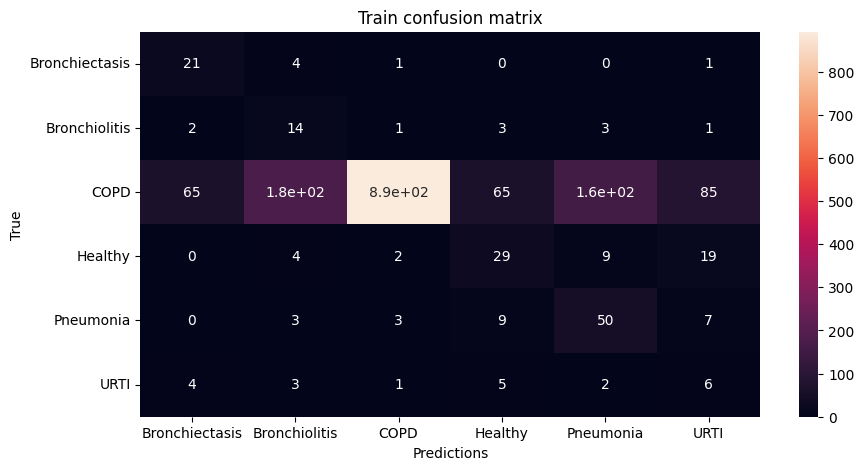

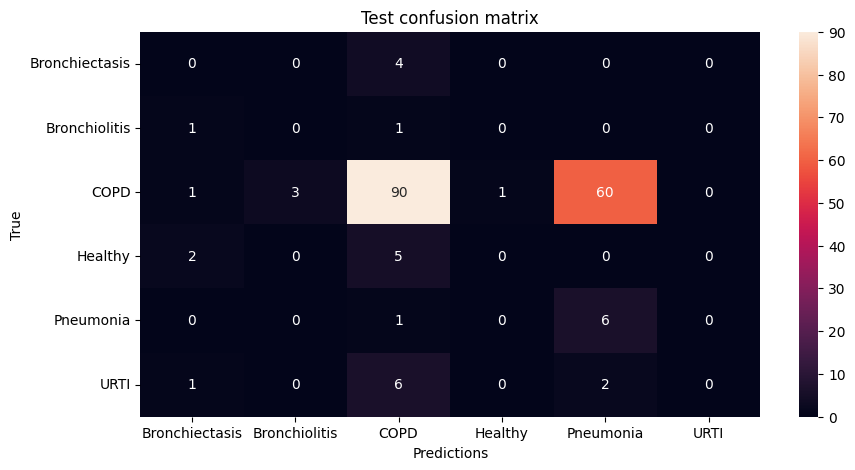


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 72:

Train Accuracy: 0.6290064102564104

Train Loss: 1.058753068630512

Train F1 Score: 0.294115069680489

Test Accuracy: 0.5225694444444444

Test Loss: 2.2651695211728415

Test F1 Score: 0.19025017321109772




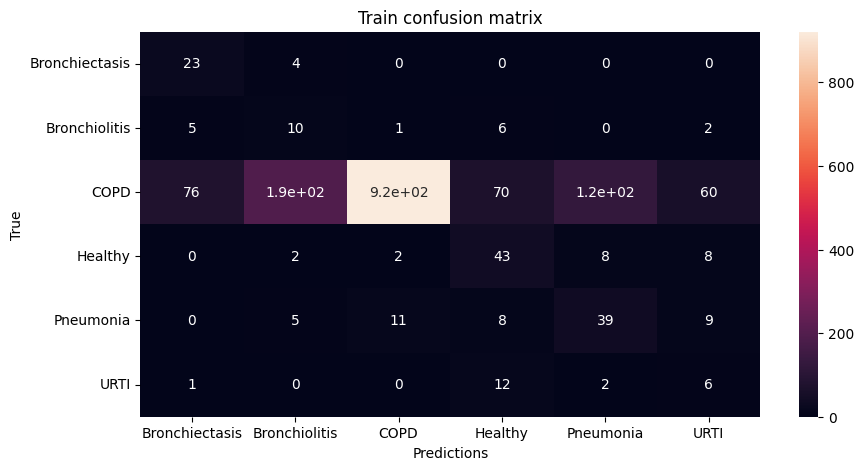

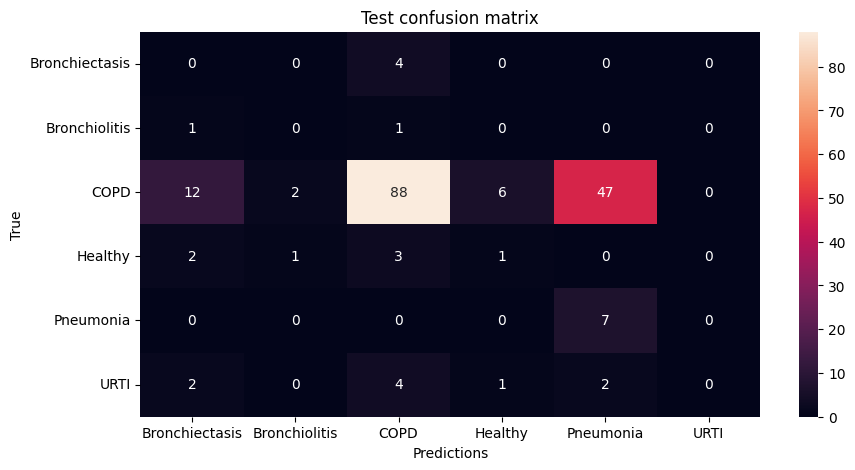


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 73:

Train Accuracy: 0.6290064102564104

Train Loss: 0.9490462002845911

Train F1 Score: 0.3143082084850623

Test Accuracy: 0.5086805555555556

Test Loss: 2.433105766773224

Test F1 Score: 0.16330891475081444




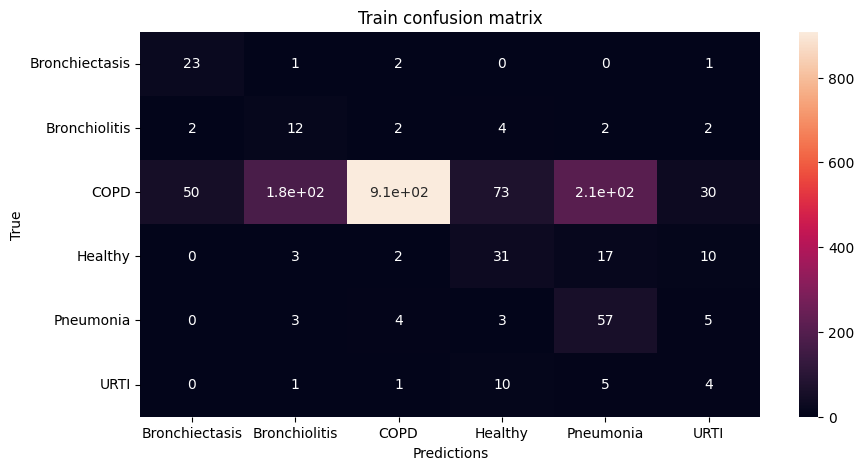

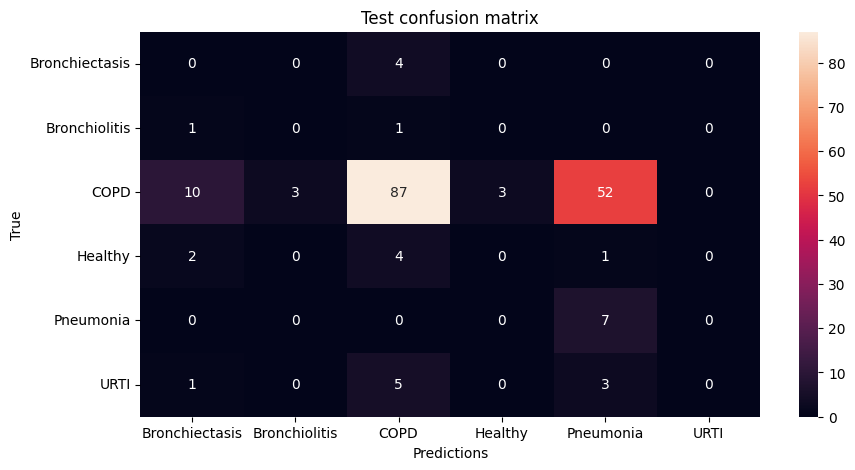


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 74:

Train Accuracy: 0.6919070512820512

Train Loss: 0.8116853933494824

Train F1 Score: 0.35712082497775555

Test Accuracy: 0.595486111111111

Test Loss: 3.981587012608846

Test F1 Score: 0.2056109383702278




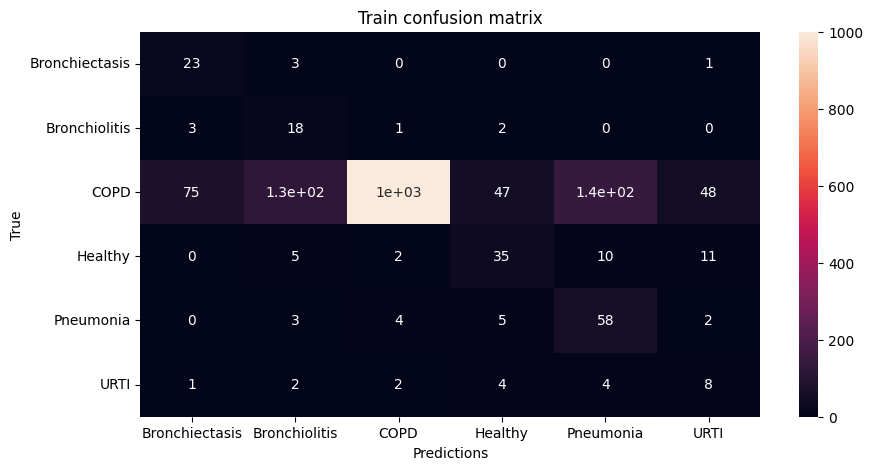

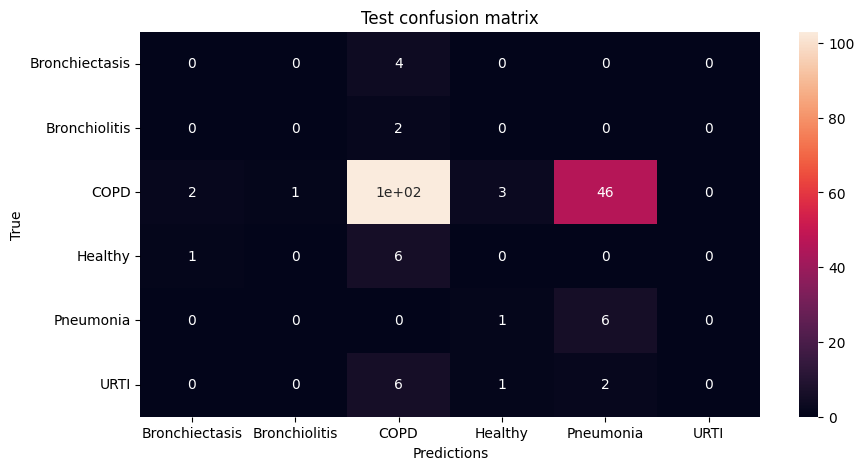


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 75:

Train Accuracy: 0.7178819444444445

Train Loss: 0.7800753331528261

Train F1 Score: 0.37031181815725106

Test Accuracy: 0.6319444444444444

Test Loss: 6.091842929522197

Test F1 Score: 0.2585883339246114




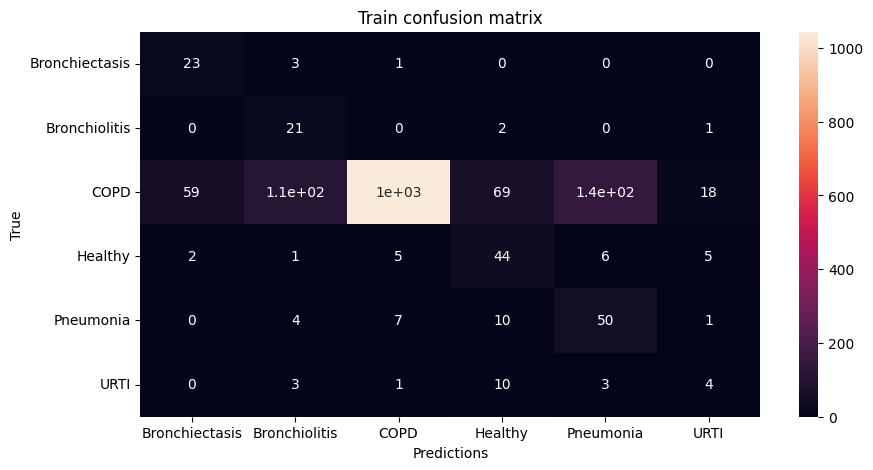

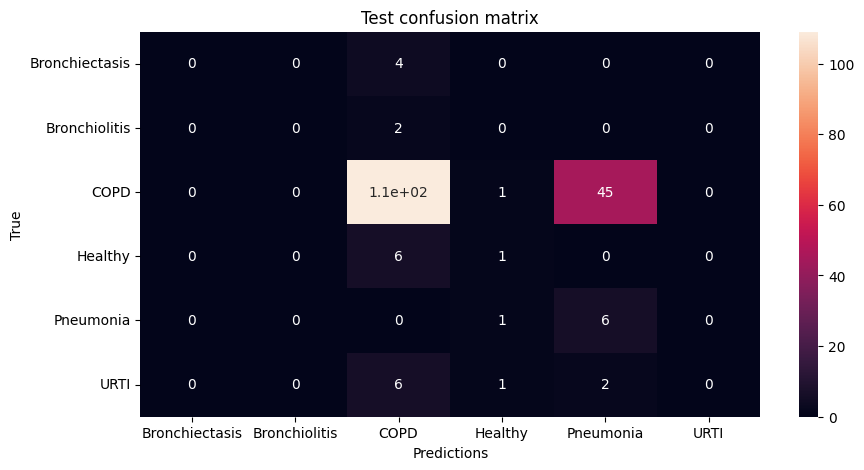


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 76:

Train Accuracy: 0.6874332264957265

Train Loss: 0.8728858639414494

Train F1 Score: 0.35899575942983997

Test Accuracy: 0.6059027777777778

Test Loss: 2.3382548292477927

Test F1 Score: 0.2901523560285568




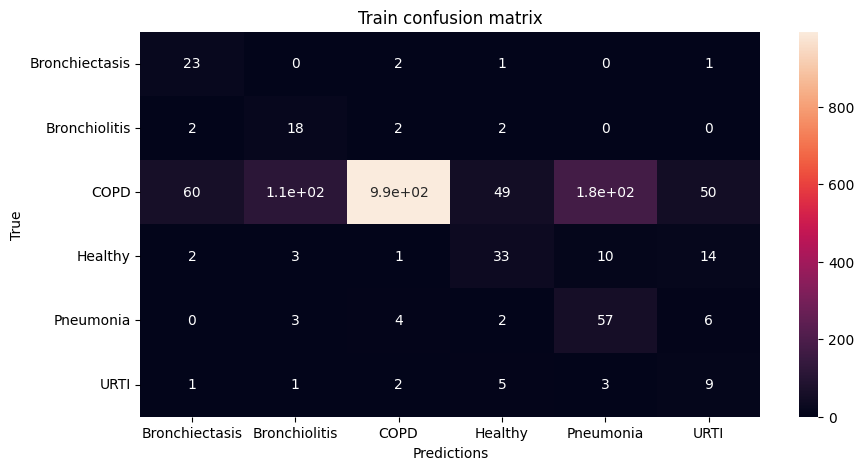

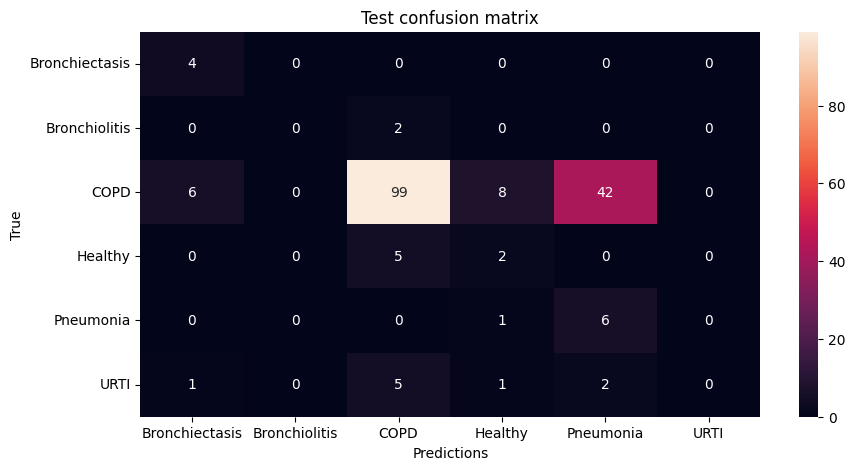


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 77:

Train Accuracy: 0.649238782051282

Train Loss: 0.7784064022394327

Train F1 Score: 0.3518568608336724

Test Accuracy: 0.5659722222222222

Test Loss: 3.41046275695165

Test F1 Score: 0.21100871761639914




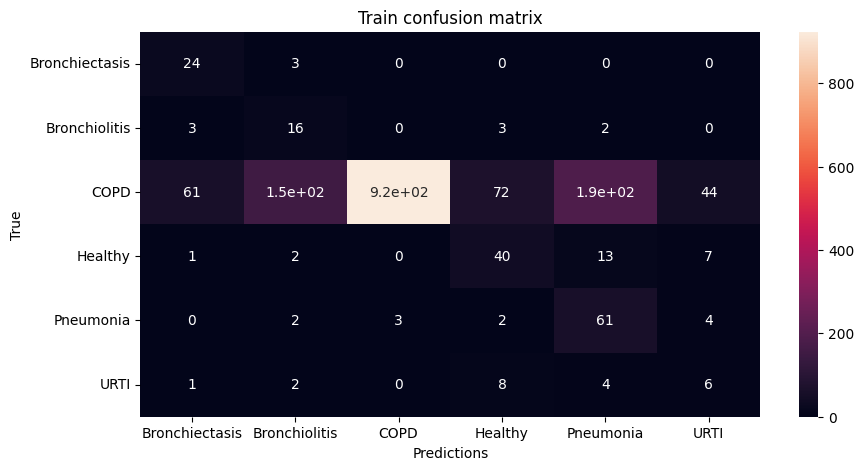

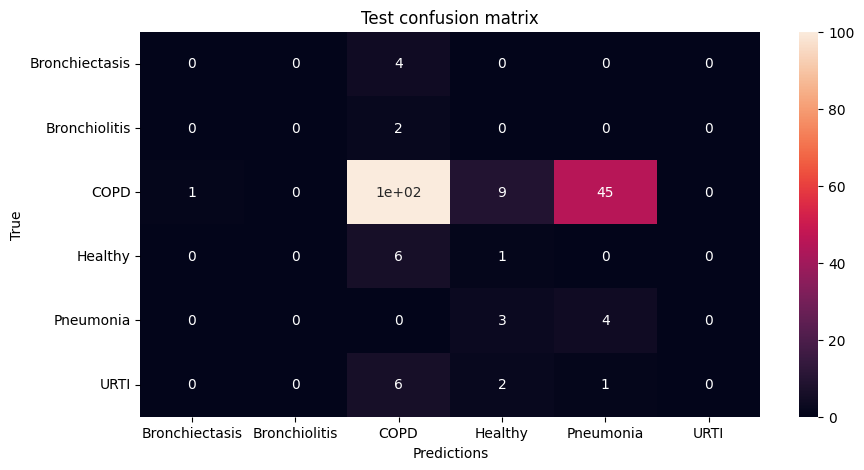


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 78:

Train Accuracy: 0.6971821581196581

Train Loss: 0.9400869709654496

Train F1 Score: 0.3410781008692888

Test Accuracy: 0.5520833333333334

Test Loss: 1.6084129810333252

Test F1 Score: 0.2547104408343633




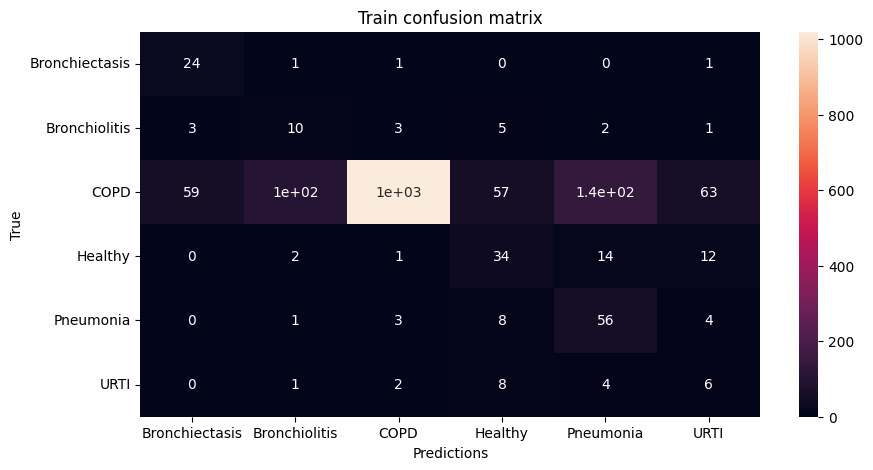

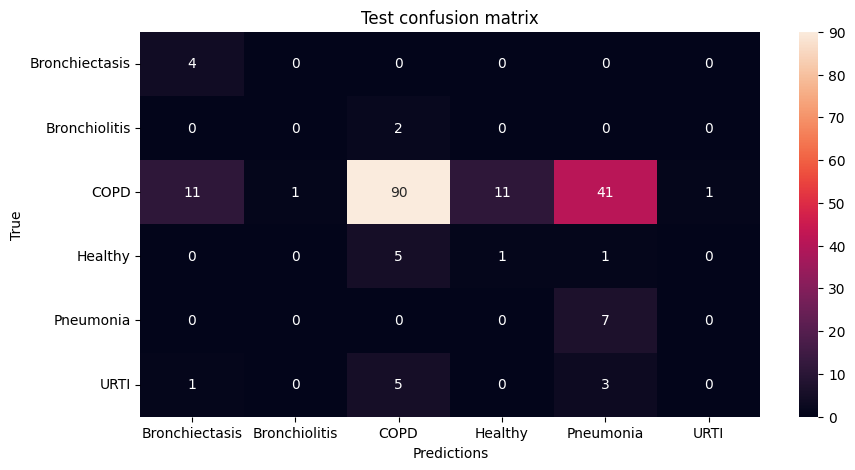


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 79:

Train Accuracy: 0.6696714743589743

Train Loss: 1.0314138531684875

Train F1 Score: 0.329606360827501

Test Accuracy: 0.46875

Test Loss: 1.691874663035075

Test F1 Score: 0.19720839709043503




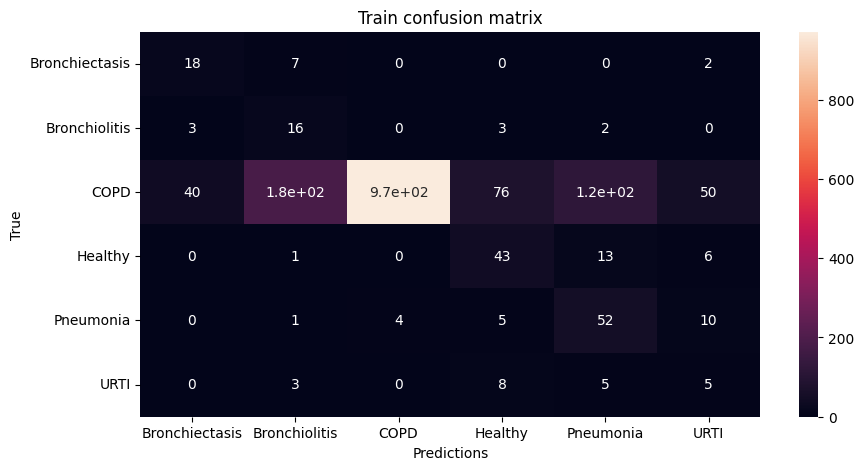

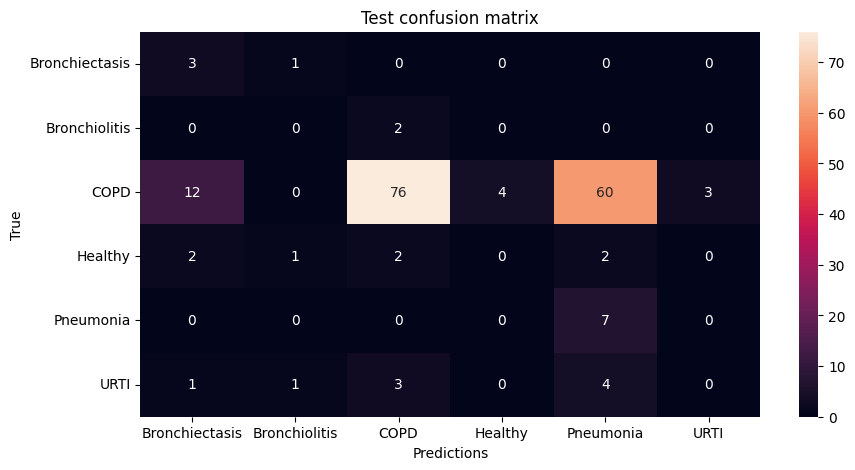


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 80:

Train Accuracy: 0.657051282051282

Train Loss: 0.9196874241416271

Train F1 Score: 0.31580165974222696

Test Accuracy: 0.4548611111111111

Test Loss: 2.121642609437307

Test F1 Score: 0.17182122791806856




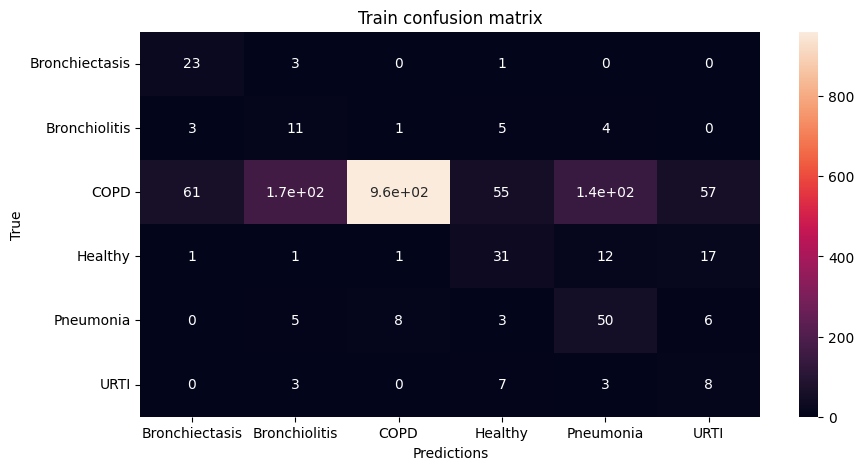

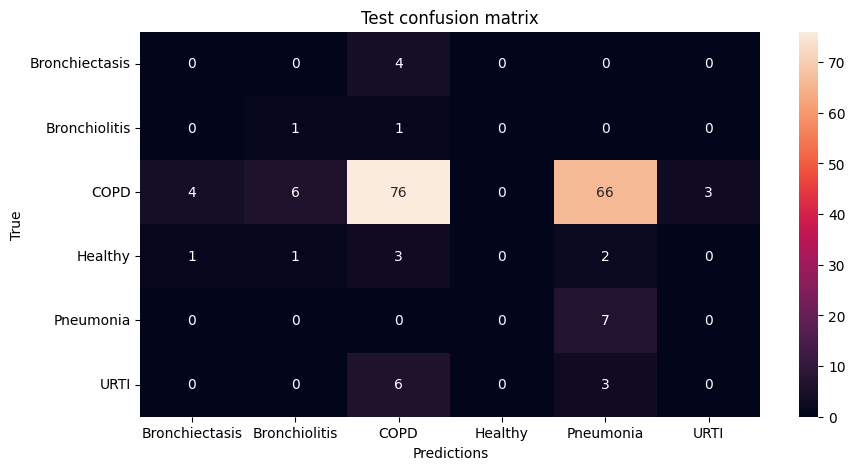


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 81:

Train Accuracy: 0.6591880341880342

Train Loss: 0.95454743418556

Train F1 Score: 0.3508161138743162

Test Accuracy: 0.5034722222222222

Test Loss: 2.2963664531707764

Test F1 Score: 0.24838905284802118




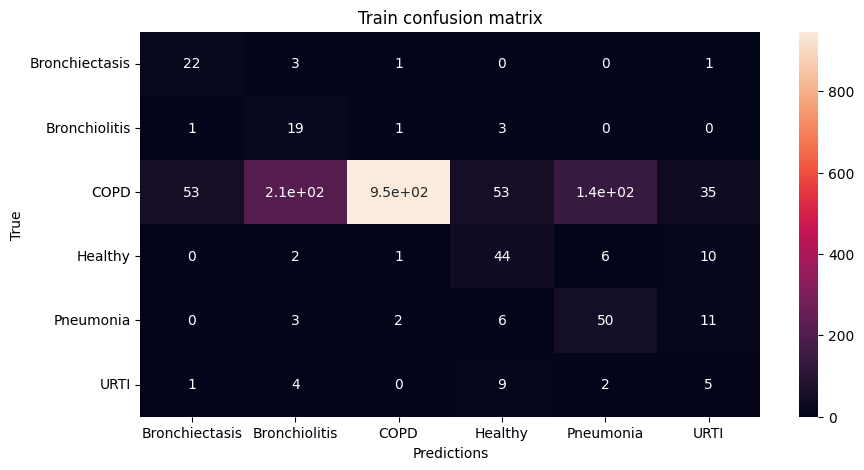

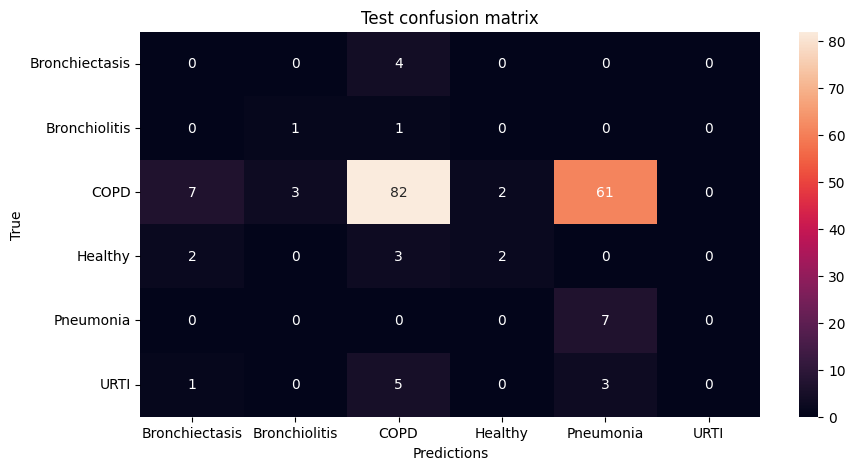


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 82:

Train Accuracy: 0.6613915598290598

Train Loss: 0.9382262596717248

Train F1 Score: 0.3276045107497619

Test Accuracy: 0.5989583333333334

Test Loss: 2.9934035539627075

Test F1 Score: 0.23243934909502664




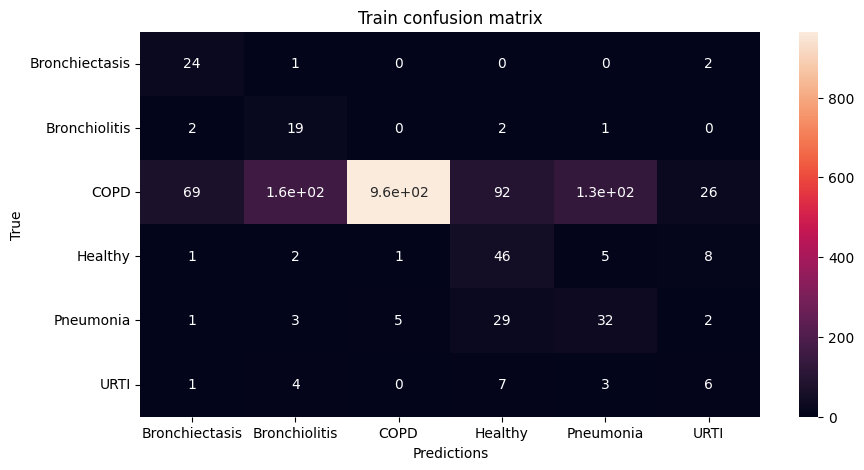

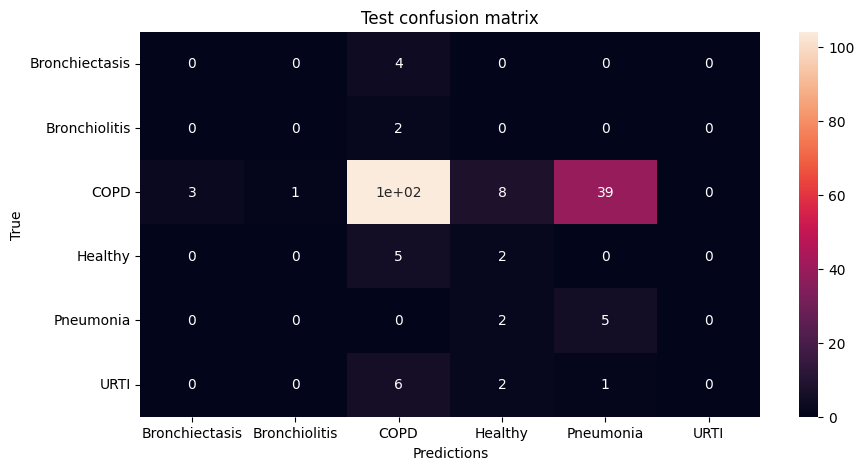


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 83:

Train Accuracy: 0.6944444444444445

Train Loss: 0.7934784599794791

Train F1 Score: 0.37443950371100354

Test Accuracy: 0.6336805555555556

Test Loss: 4.608999252319336

Test F1 Score: 0.2473768269022306




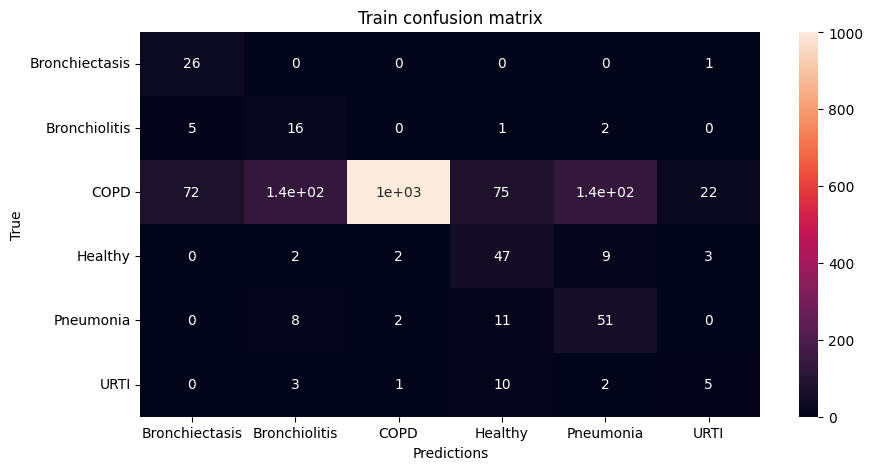

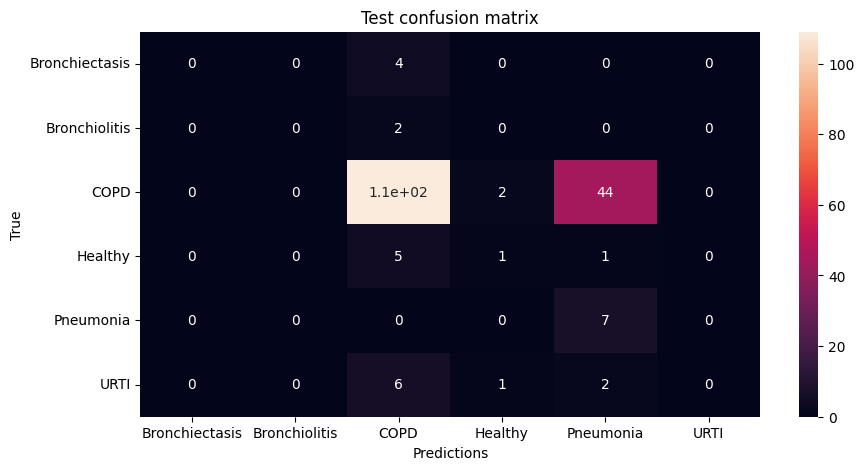


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 84:

Train Accuracy: 0.6451655982905984

Train Loss: 0.9415202077764732

Train F1 Score: 0.3450085036456585

Test Accuracy: 0.548611111111111

Test Loss: 2.5810919801394143

Test F1 Score: 0.21193153907855353




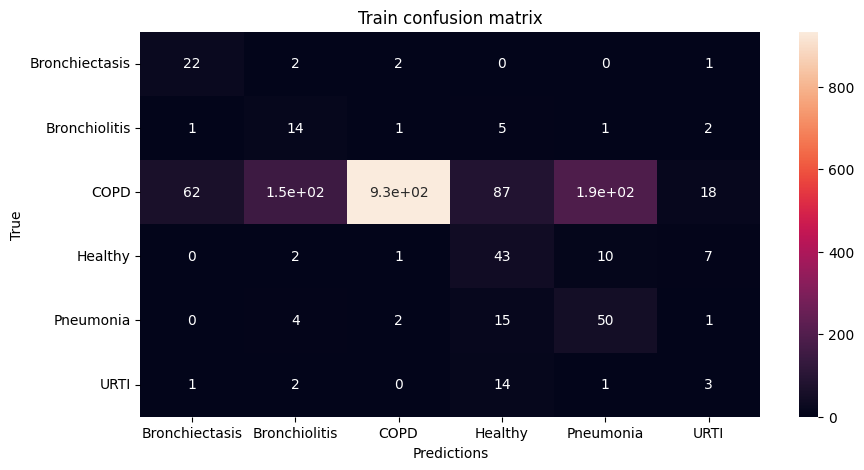

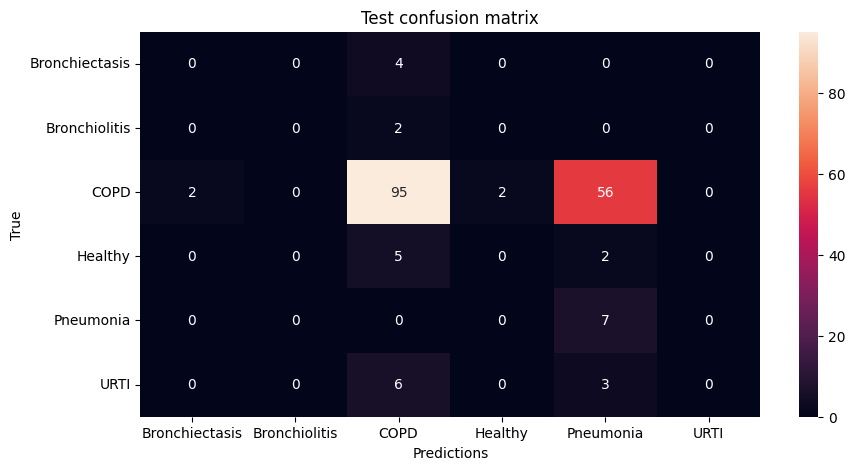


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 85:

Train Accuracy: 0.6902377136752137

Train Loss: 0.7589369671275983

Train F1 Score: 0.3669865435132614

Test Accuracy: 0.5208333333333334

Test Loss: 3.8310351769129434

Test F1 Score: 0.18476596226294836




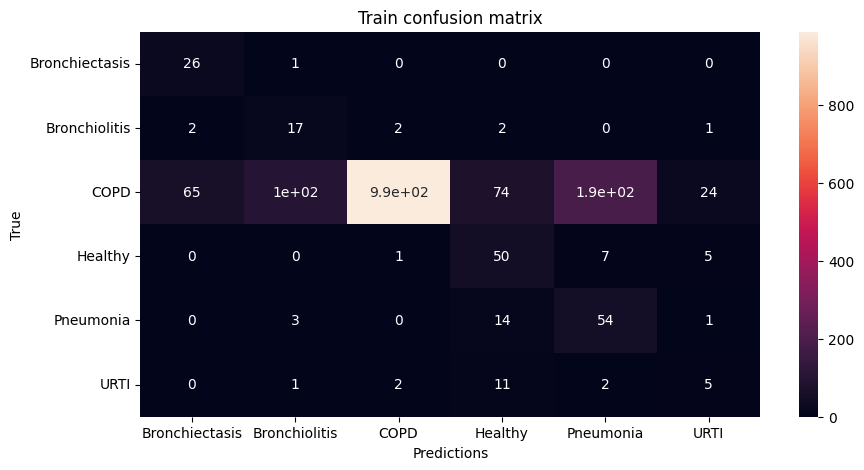

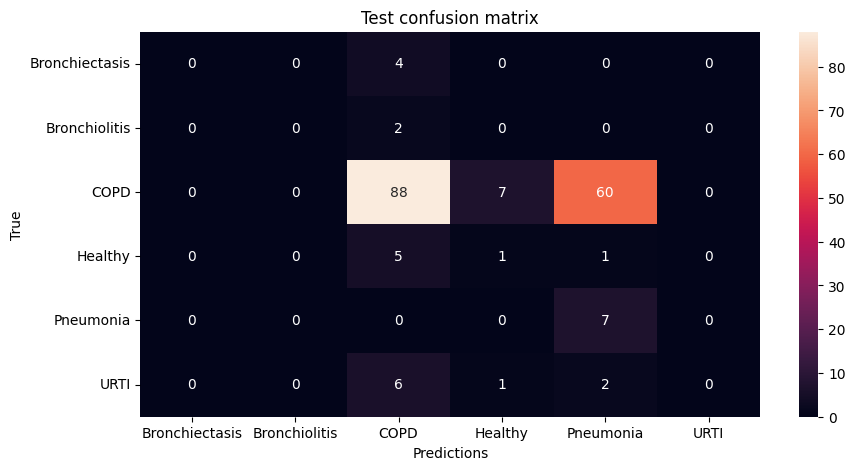


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 86:

Train Accuracy: 0.655715811965812

Train Loss: 0.8021955553155679

Train F1 Score: 0.34603211455620253

Test Accuracy: 0.545138888888889

Test Loss: 2.8894907434781394

Test F1 Score: 0.23721703638633093




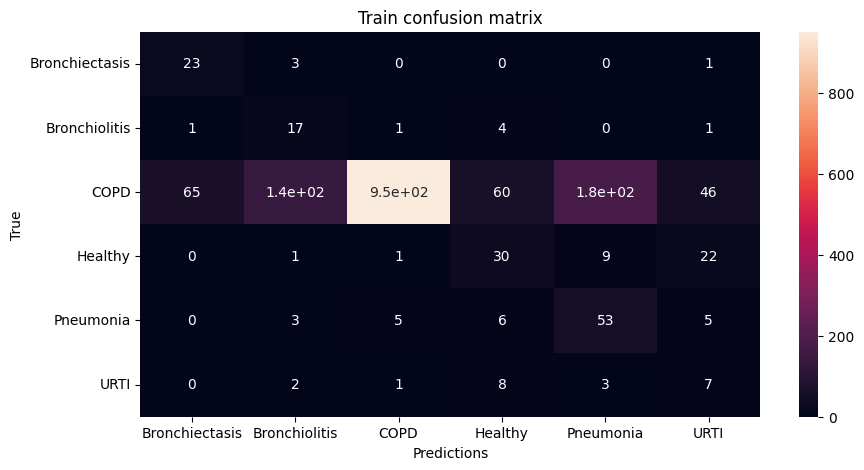

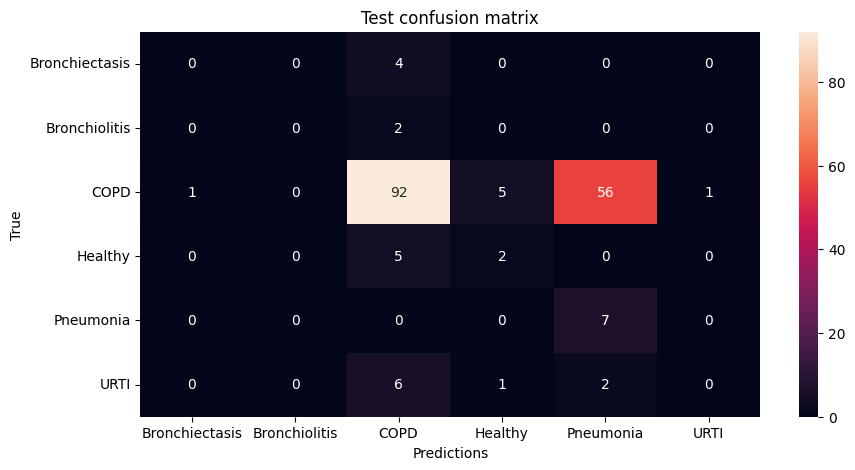


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 87:

Train Accuracy: 0.686030982905983

Train Loss: 0.8028317684164414

Train F1 Score: 0.37629013565870434

Test Accuracy: 0.5729166666666666

Test Loss: 3.8418712615966797

Test F1 Score: 0.2344943086306254




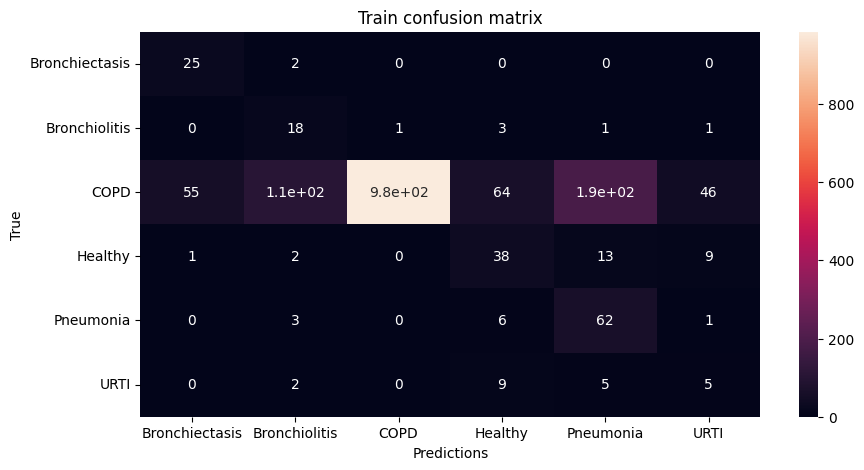

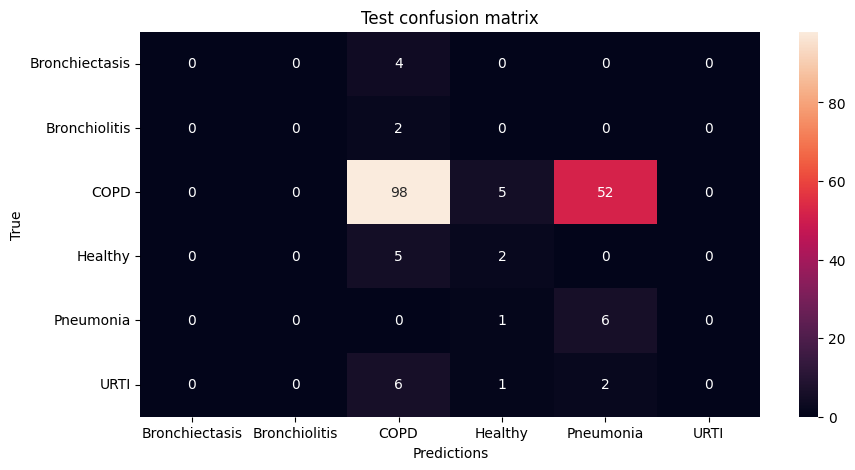


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 88:

Train Accuracy: 0.7083333333333334

Train Loss: 0.7285353845128646

Train F1 Score: 0.3636540535550851

Test Accuracy: 0.6163194444444444

Test Loss: 4.0931780735651655

Test F1 Score: 0.2255805085102717




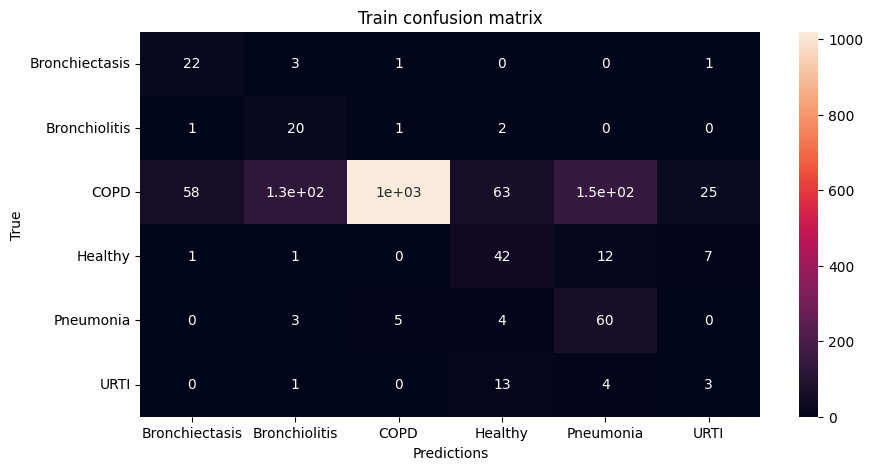

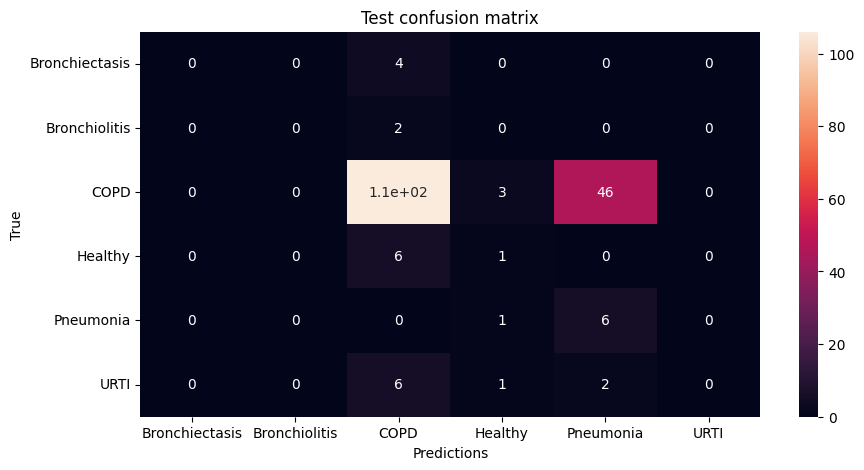


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 89:

Train Accuracy: 0.7286992521367522

Train Loss: 0.6946254289494112

Train F1 Score: 0.3885343447327614

Test Accuracy: 0.671875

Test Loss: 4.270010908444722

Test F1 Score: 0.2670338377356529




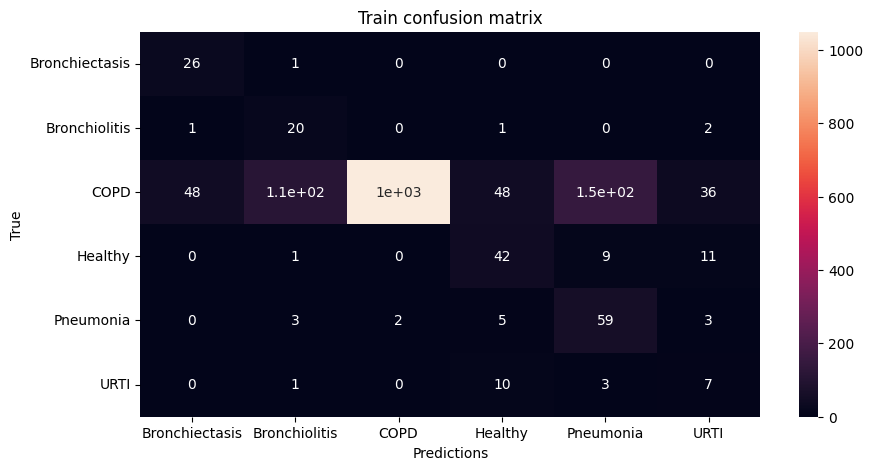

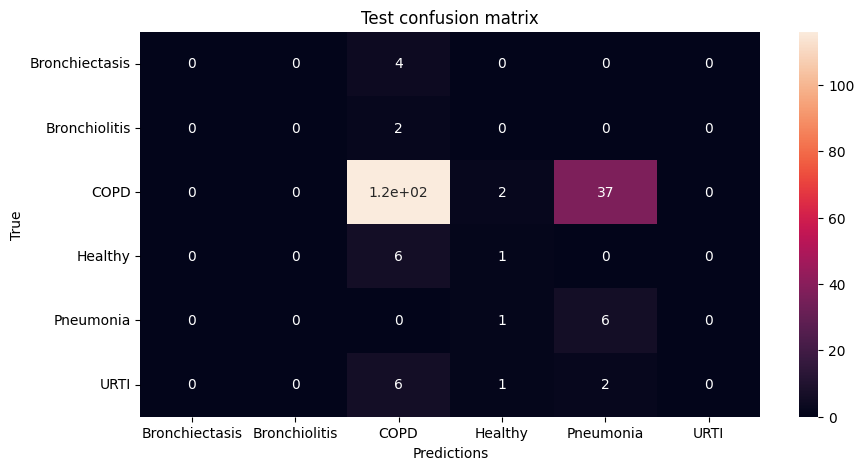


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 90:

Train Accuracy: 0.7284321581196581

Train Loss: 0.777771441409221

Train F1 Score: 0.3897500178561761

Test Accuracy: 0.5850694444444444

Test Loss: 2.8297651608784995

Test F1 Score: 0.2817617431282997




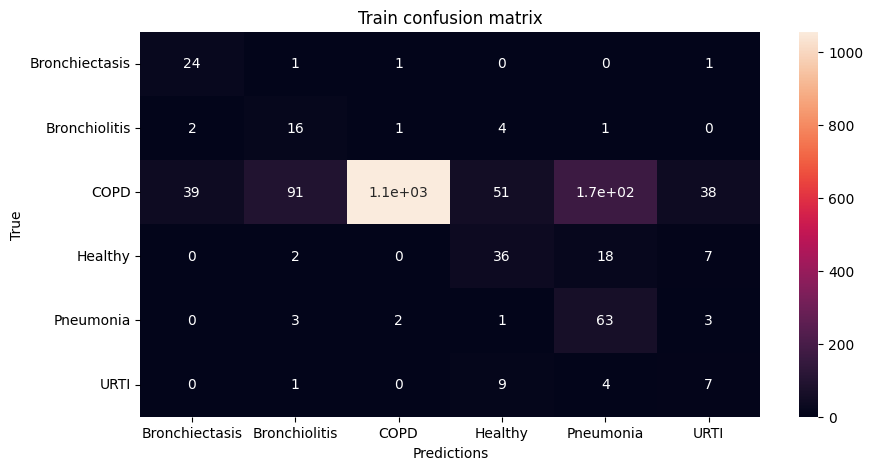

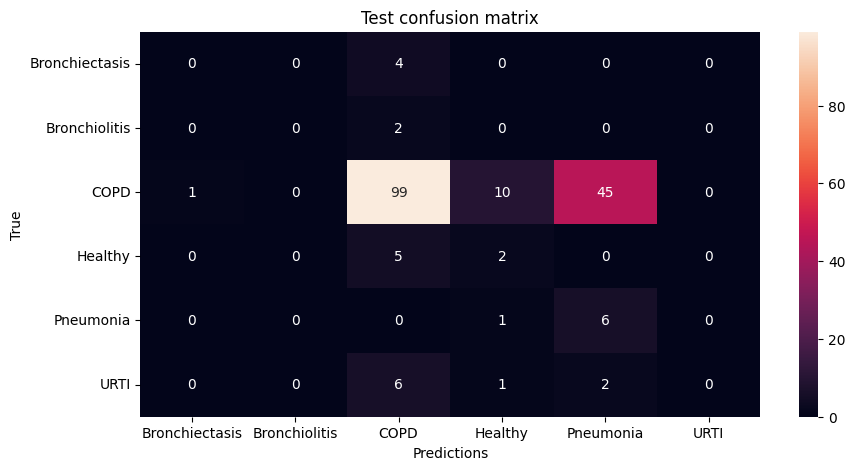


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 91:

Train Accuracy: 0.7118723290598291

Train Loss: 0.695941649377346

Train F1 Score: 0.40842291196951497

Test Accuracy: 0.6180555555555556

Test Loss: 3.4380414485931396

Test F1 Score: 0.2216705158352852




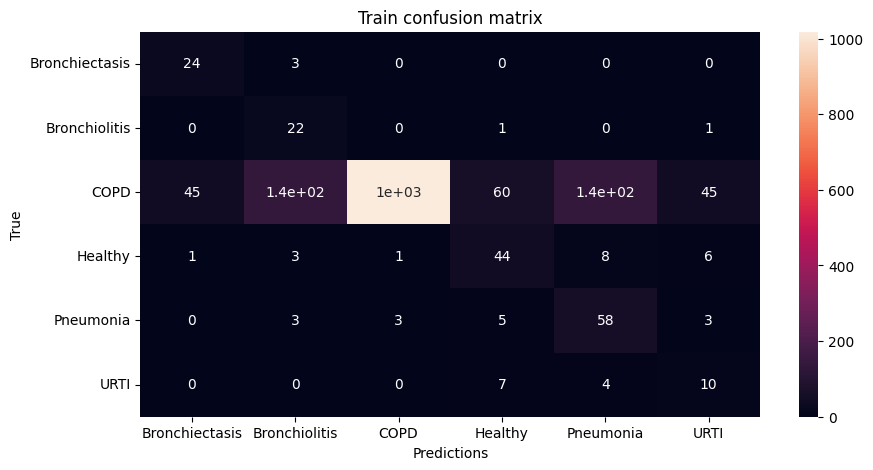

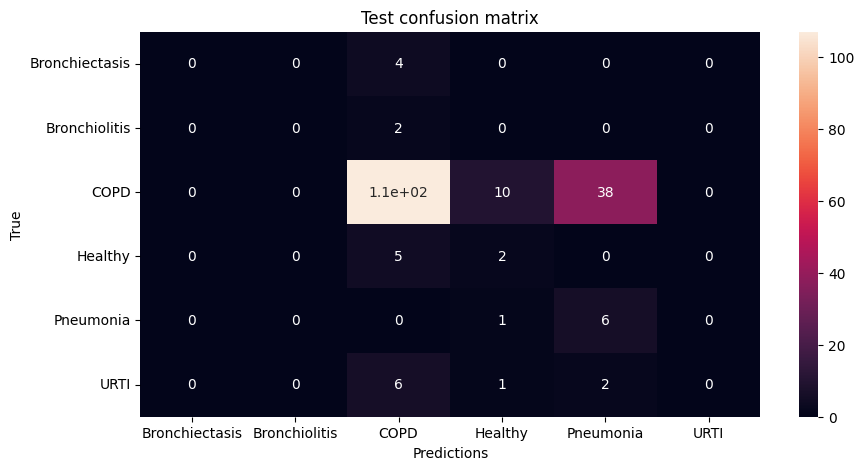


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 92:

Train Accuracy: 0.7266292735042735

Train Loss: 0.7059838267473074

Train F1 Score: 0.3886115579650952

Test Accuracy: 0.611111111111111

Test Loss: 3.2256380915641785

Test F1 Score: 0.23449575901031494




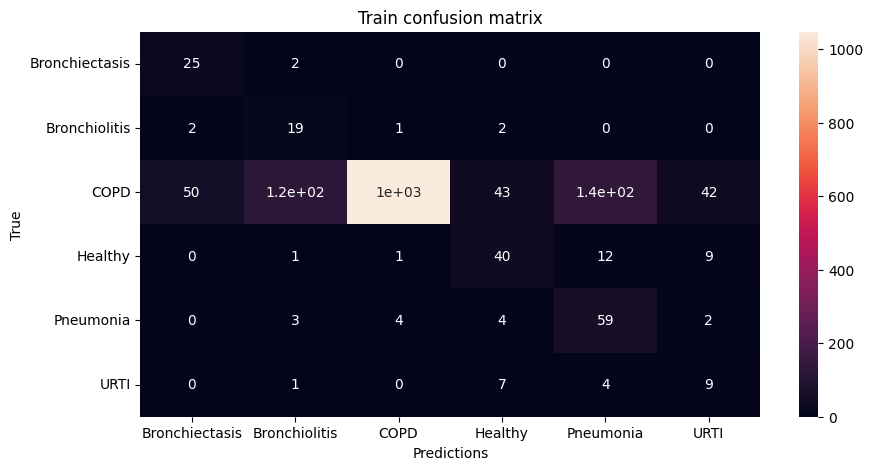

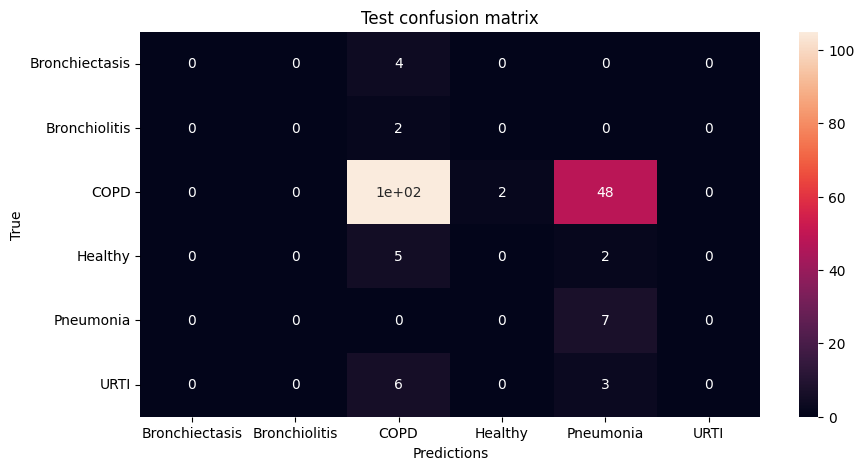


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 93:

Train Accuracy: 0.7307024572649573

Train Loss: 0.6530871206464676

Train F1 Score: 0.40512410236092716

Test Accuracy: 0.65625

Test Loss: 3.702438394228617

Test F1 Score: 0.2635646586616834




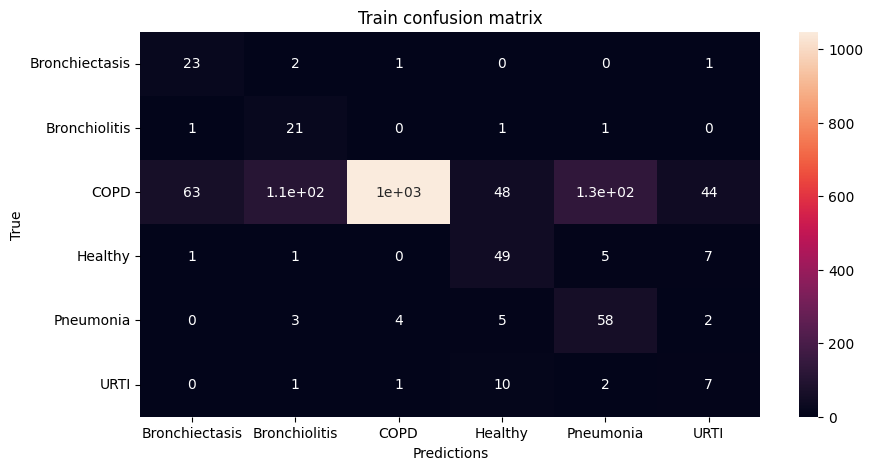

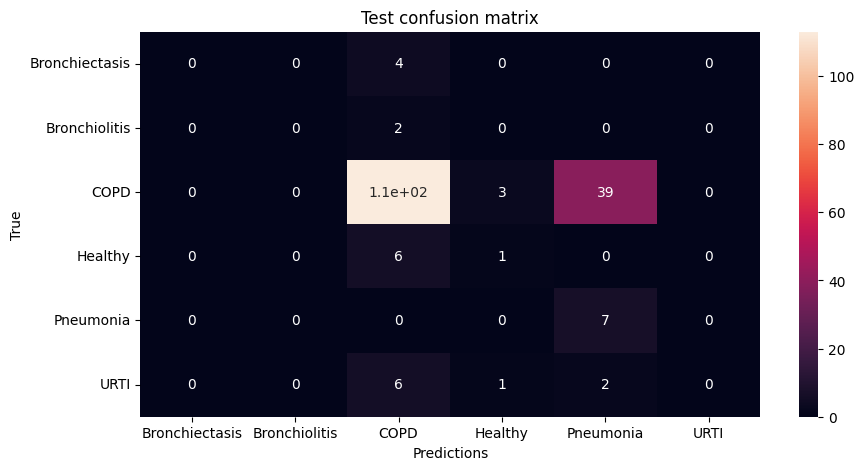


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 94:

Train Accuracy: 0.6567174145299146

Train Loss: 0.9909473158992254

Train F1 Score: 0.3464018123654219

Test Accuracy: 0.6041666666666666

Test Loss: 2.5323921839396157

Test F1 Score: 0.25460534046093625




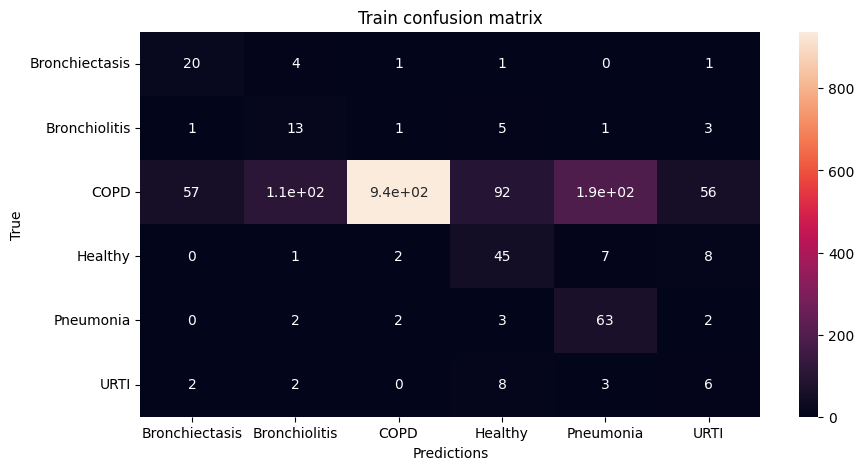

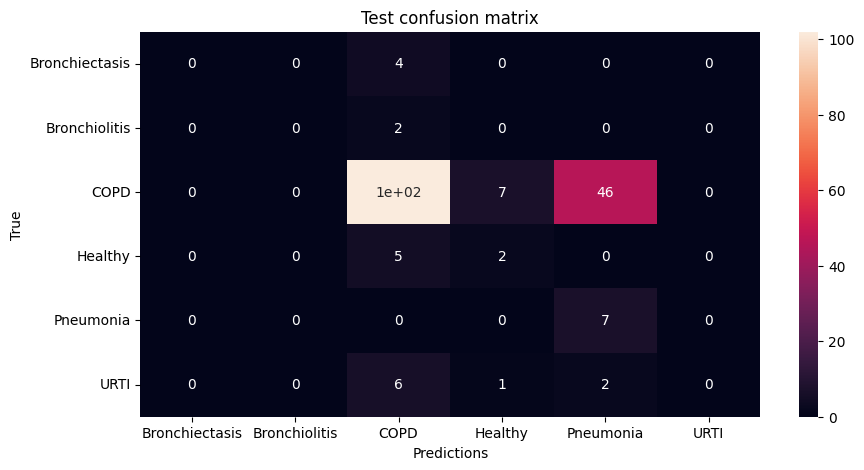


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 95:

Train Accuracy: 0.6962473290598291

Train Loss: 0.7963283274036187

Train F1 Score: 0.34862217135154283

Test Accuracy: 0.6180555555555556

Test Loss: 4.457650125026703

Test F1 Score: 0.25038545082012814




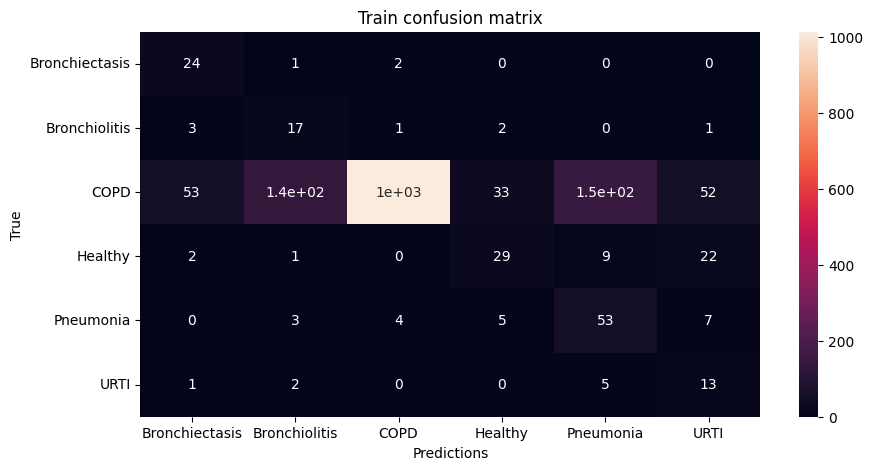

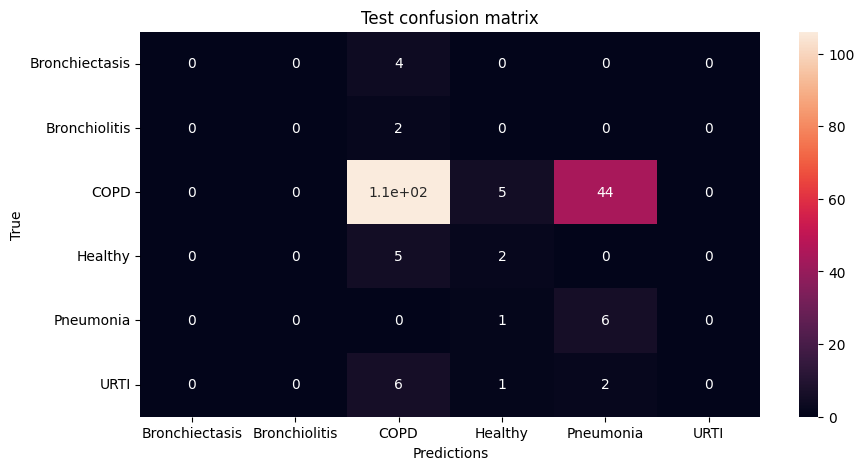


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 96:

Train Accuracy: 0.7481303418803419

Train Loss: 0.835206052288413

Train F1 Score: 0.42881654833371824

Test Accuracy: 0.579861111111111

Test Loss: 3.395022173722585

Test F1 Score: 0.23153243213891983




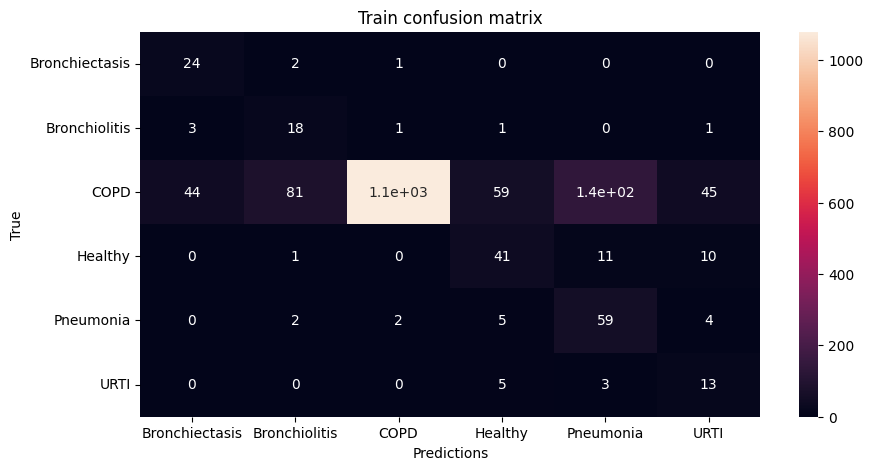

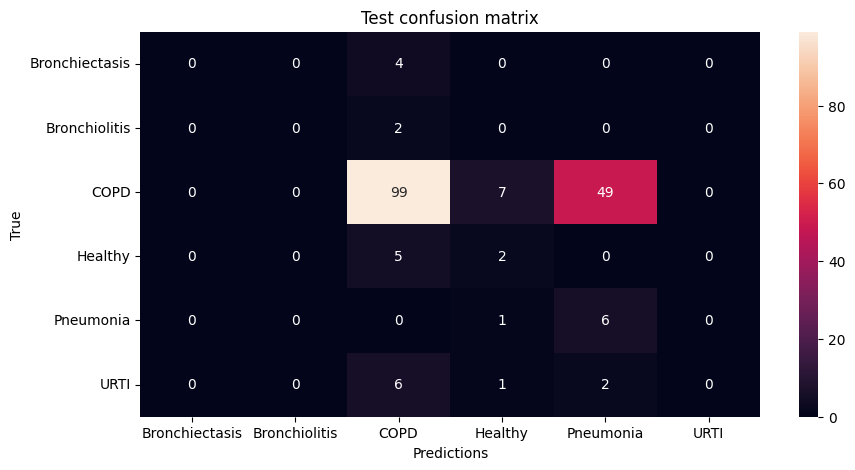


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 97:

Train Accuracy: 0.6890357905982907

Train Loss: 0.7543318466498301

Train F1 Score: 0.3626488676437965

Test Accuracy: 0.548611111111111

Test Loss: 3.5937618811925254

Test F1 Score: 0.25394046182433766




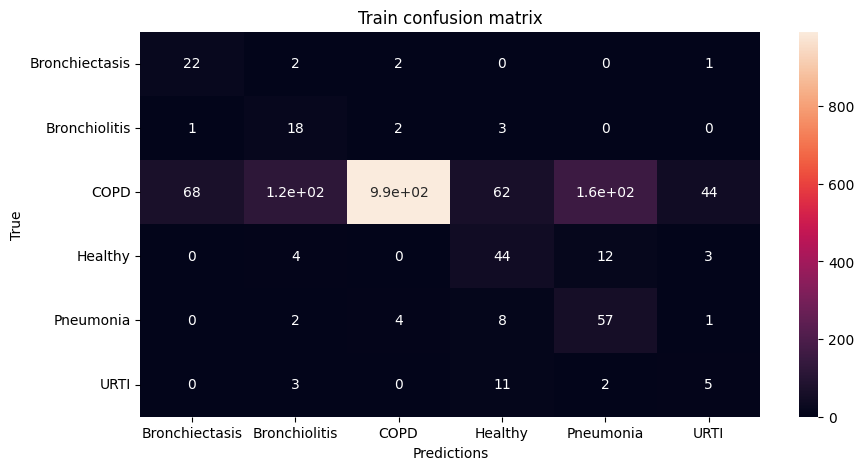

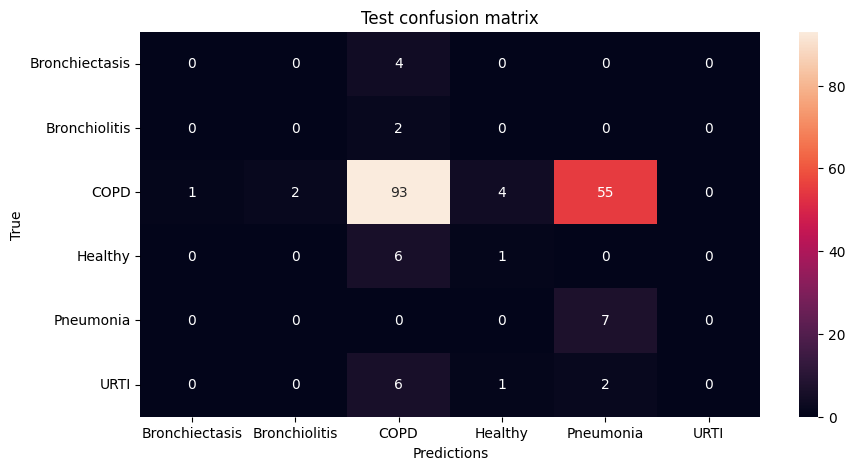


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 98:

Train Accuracy: 0.6897035256410257

Train Loss: 0.6941124773942507

Train F1 Score: 0.35664976846713287

Test Accuracy: 0.5625

Test Loss: 3.3720539212226868

Test F1 Score: 0.22493661319216093




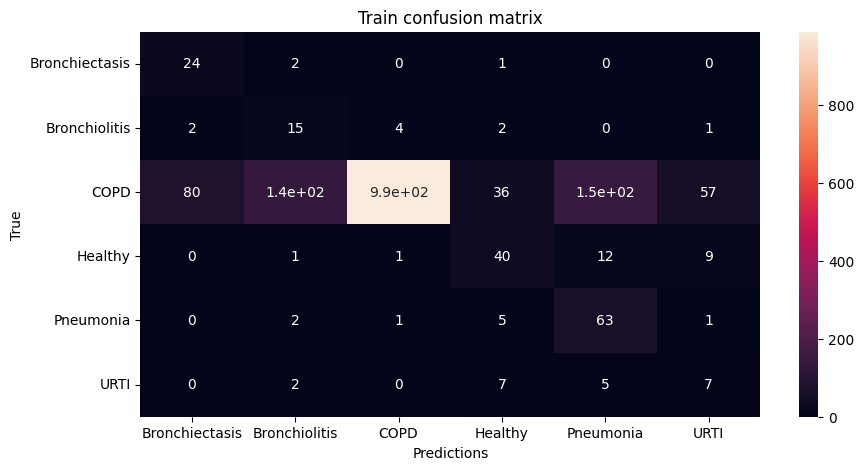

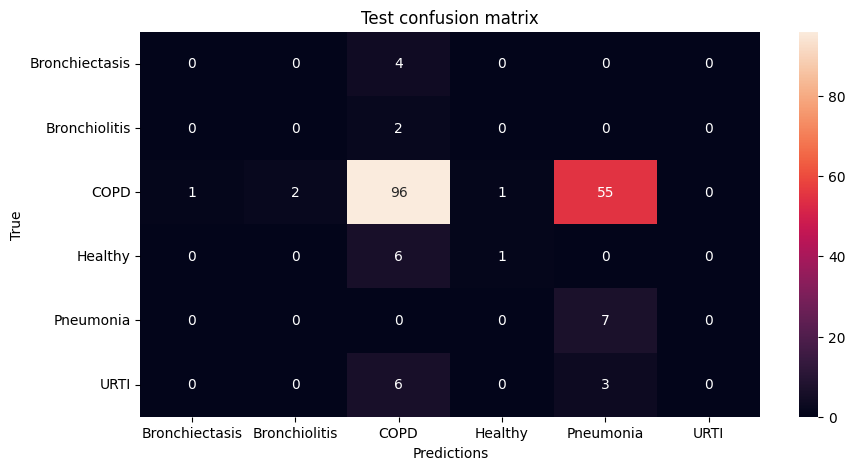


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 99:

Train Accuracy: 0.7279647435897435

Train Loss: 0.694345792898765

Train F1 Score: 0.4011689192400529

Test Accuracy: 0.560763888888889

Test Loss: 2.6527581810951233

Test F1 Score: 0.2103682110706965




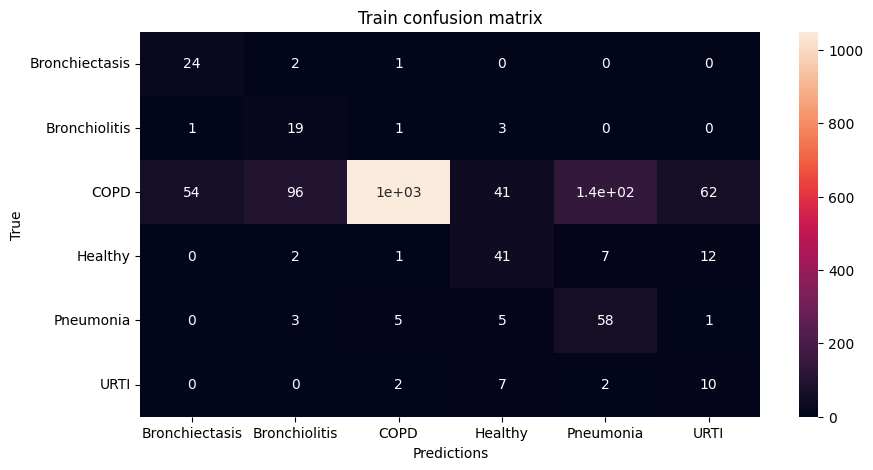

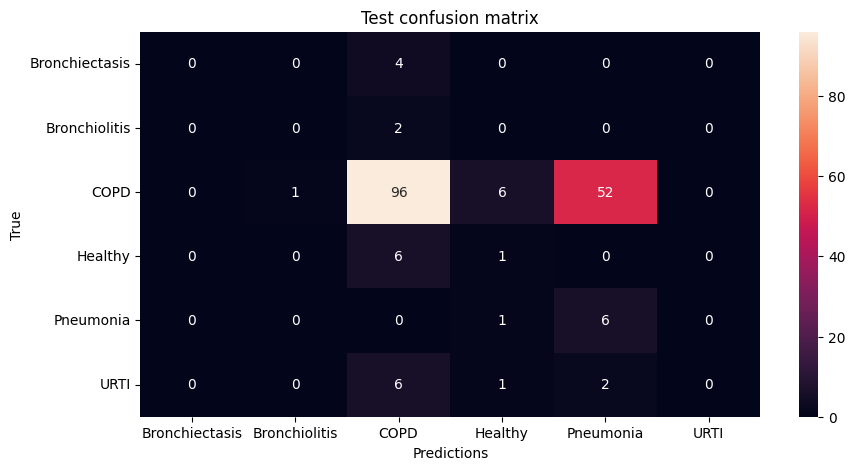


Training:


  0%|          | 0/52 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 100:

Train Accuracy: 0.7240251068376069

Train Loss: 0.6937623824924231

Train F1 Score: 0.3949975414344898

Test Accuracy: 0.546875

Test Loss: 5.59203843275706

Test F1 Score: 0.20208106189966202




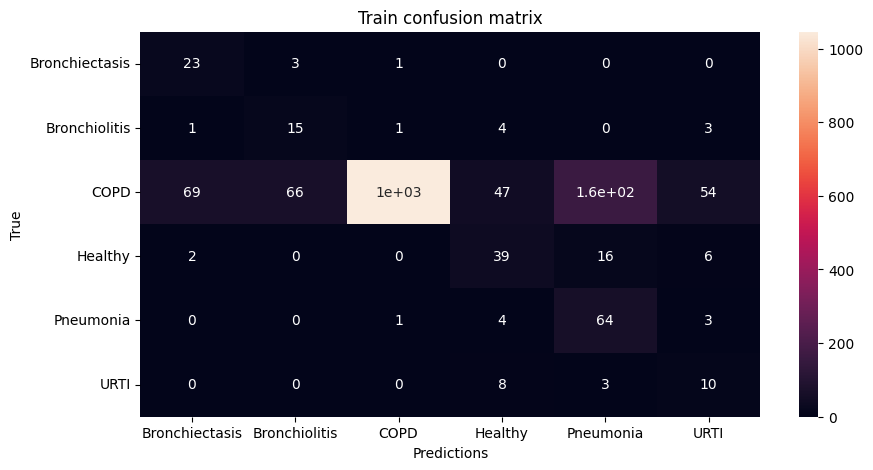

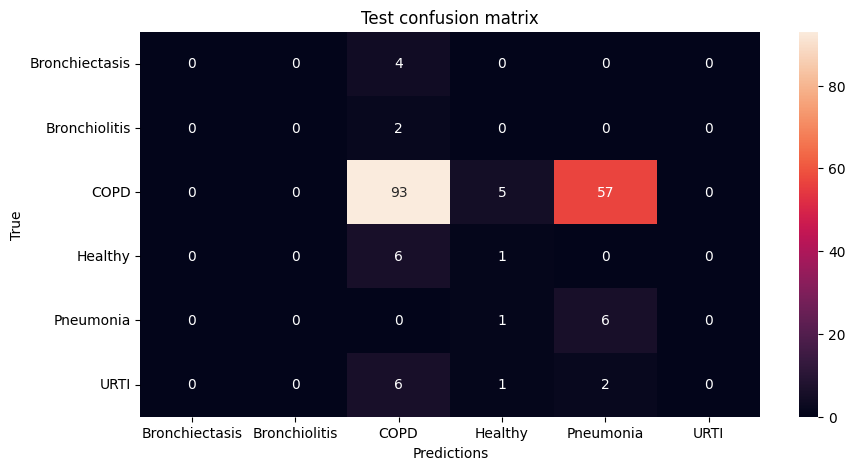

In [41]:
epochs=100
train_model(model,epochs)